<a href="https://colab.research.google.com/github/ATLAS097/Deep-Learning-CA-2/blob/Swam/GAN_Part_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Adversarial Network - New Image Generation
### Group Member: Swam Htet Aung, Kaung Myat San
### Class: DAAA/FT/2B/22
---



### Setup
---

### Importing Modules

In [2]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

# Deep learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms

# Utilities
import os
import warnings
from PIL import Image
from scipy import linalg
import random
# === Step 1: Load raw dataset and inspect ===
import pandas as pd
import matplotlib.pyplot as plt

# Load the raw EMNIST dataset
data = pd.read_csv(
    'https://media.githubusercontent.com/media/ATLAS097/assets/refs/heads/main/SP_DELE_CA2_YEAR_2/emnist-letters-train.csv',
    header=None
)

# Basic info about the raw dataset
print("=== RAW DATASET OVERVIEW ===")
print(f"Shape: {data.shape}")
print(f"Column count: {len(data.columns)}")
print("\nFirst 5 rows:")
print(data.head())

# Missing values check
print(f"\nTotal missing values: {data.isnull().sum().sum()}")

# Show first few column names
print(f"\nFirst 10 column names: {data.columns[:10].tolist()}")


# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
torch.manual_seed(42)
random.seed(42)

# Suppress warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"PyTorch version: {torch.__version__}")
print(f"GPU available (TensorFlow): {tf.config.list_physical_devices('GPU')}")
print(f"GPU available (PyTorch): {torch.cuda.is_available()}")

gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    tf.config.set_logical_device_configuration(gpu, [tf.config.LogicalDeviceConfiguration(memory_limit=6144)]) # 6GB limit per GPU

print(tf.config.list_physical_devices())


=== RAW DATASET OVERVIEW ===
Shape: (64829, 785)
Column count: 785

First 5 rows:
   0    1    2    3    4    5    6    7    8    9    ...  775  776  777  778  \
0   24    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
1   -2  142  142  142  142  142  142  142  142  142  ...  142  142  142  142   
2   15    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
3   14    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
4   -2  120  120  120  120  120  120  120  120  120  ...  120  120  120  120   

   779  780  781  782  783  784  
0    0    0    0    0    0    0  
1  142  142  142  142  142  142  
2    0    0    0    0    0    0  
3    0    0    0    0    0    0  
4  120  120  120  120  120  120  

[5 rows x 785 columns]

Total missing values: 0

First 10 column names: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Libraries imported successfully!
TensorFlow version: 2.19.0
PyTorch version: 2.6.0+cu124
GPU available (TensorFlow): [PhysicalDev

## Background Research & Data Analysis
---
### Data Loading and Exploration
---
Let's load the EMNIST letters dataset and analyze its structure.

In [3]:
# Load the raw EMNIST dataset
data = pd.read_csv(
    'https://media.githubusercontent.com/media/ATLAS097/assets/refs/heads/main/SP_DELE_CA2_YEAR_2/emnist-letters-train.csv',
    header=None
)

# Basic info about the raw dataset
print("=== RAW DATASET OVERVIEW ===")
print(f"Shape: {data.shape}")
print(f"Column count: {len(data.columns)}")
print("\nFirst 5 rows:")
print(data.head())

# Missing values check
print(f"\nTotal missing values: {data.isnull().sum().sum()}")

# Show first few column names
print(f"\nFirst 10 column names: {data.columns[:10].tolist()}")


=== RAW DATASET OVERVIEW ===
Shape: (64829, 785)
Column count: 785

First 5 rows:
   0    1    2    3    4    5    6    7    8    9    ...  775  776  777  778  \
0   24    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
1   -2  142  142  142  142  142  142  142  142  142  ...  142  142  142  142   
2   15    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
3   14    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
4   -2  120  120  120  120  120  120  120  120  120  ...  120  120  120  120   

   779  780  781  782  783  784  
0    0    0    0    0    0    0  
1  142  142  142  142  142  142  
2    0    0    0    0    0    0  
3    0    0    0    0    0    0  
4  120  120  120  120  120  120  

[5 rows x 785 columns]

Total missing values: 0

First 10 column names: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]




- The dataset contains **785 columns** in total.
- The **first column** likely represents the **class label** in numeric form.
- The **remaining 784 columns** are pixel intensity values for a **28×28 grayscale image**, stored in a flattened format.
- No missing values were detected, so the dataset is complete.
- At this stage:
  - Labels are **numeric codes** without explicit mapping to letters.
  - We will later map these numeric labels to their corresponding alphabet characters.


In [4]:
# Rename columns for clarity
column_names = ['label'] + [f'pixel_{i}' for i in range(784)]
data.columns = column_names

# Show dataset statistics for each column
print("\n=== DATASET STATISTICS ===")
print(data.describe())



=== DATASET STATISTICS ===
              label       pixel_0       pixel_1       pixel_2       pixel_3  \
count  64829.000000  64829.000000  64829.000000  64829.000000  64829.000000   
mean       9.680776     20.139135     20.139135     20.139135     20.139228   
std        8.305620     54.998436     54.998436     54.998436     55.002882   
min       -2.000000      0.000000      0.000000      0.000000      0.000000   
25%        2.000000      0.000000      0.000000      0.000000      0.000000   
50%        9.000000      0.000000      0.000000      0.000000      0.000000   
75%       16.000000      0.000000      0.000000      0.000000      0.000000   
max       26.000000    255.000000    255.000000    255.000000    255.000000   

            pixel_4       pixel_5       pixel_6       pixel_7       pixel_8  \
count  64829.000000  64829.000000  64829.000000  64829.000000  64829.000000   
mean      20.142884     20.159049     20.166638     20.158340     25.268445   
std       54.999141    



- The `.describe()` output confirms:
  - **count**: All columns have the same number of entries, meaning there are no missing pixels.
  - **mean**: Average pixel intensity across the dataset is around 20, indicating mostly dark backgrounds with lighter strokes.
  - **std**: High standard deviation (~55) compared to mean suggests strong contrast between background and foreground pixels.
  - **min**/**max**: Pixel values range from **0 (black)** to **255 (white)**, consistent with 8-bit grayscale encoding.
  - **Quartiles (25%, 50%, 75%)**: The majority of pixel values are `0`, meaning most pixels are background.
- These statistics match expectations for a sparse grayscale handwritten character dataset.


### Dataset Summary & Key Observations

- **Total Samples**:  
  The dataset contains a total of **64,829** samples.

- **Image Properties**:  
  - Each sample is a flattened array of **784 pixels**, which can be reshaped into a $28 \times 28$ grayscale image.  
  - The data is highly **sparse**: the 75th percentile for most pixel columns is 0, indicating that the majority of the image area is background.

- **Label Properties**:  
  - Labels are integers ranging from **-2 to 26**.  
  - These labels are not sequential and must be mapped correctly to the **16 target classes** for model training.

- **Required Preprocessing**:  
  - Pixel intensity values currently range from **0 to 255**.  
  - These should be **normalized** (e.g., scaled to a `[-1, 1]` range) to ensure stable and effective model training.




### Visualizing the Images by Class
---

We will visualise the images by class to see what we have in our dataset.

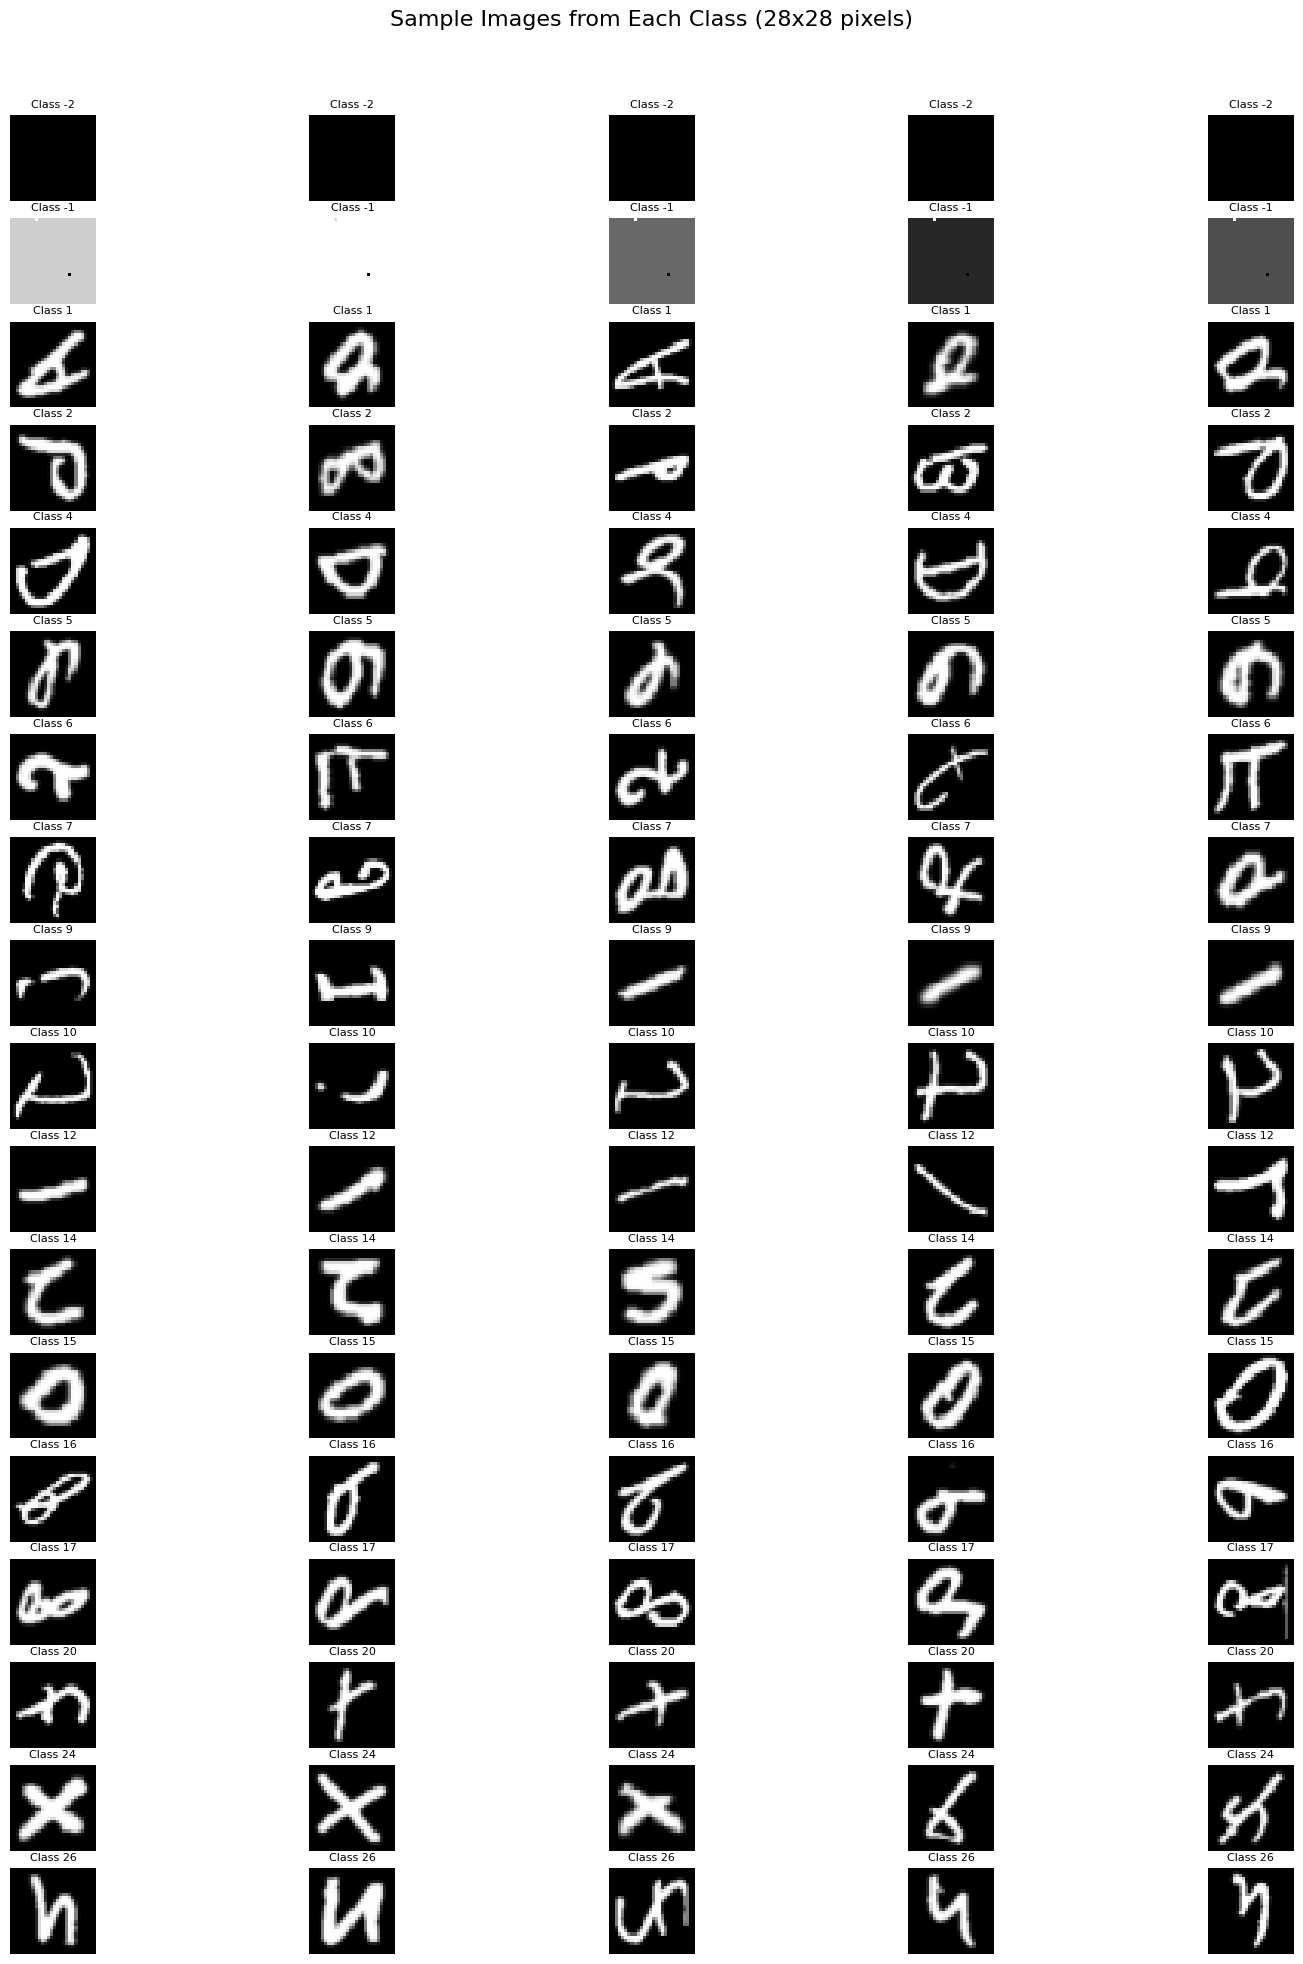

In [5]:
# Visualize sample images from different classes
def visualize_samples(data, n_samples=5, figsize=(15, 20)):
    """Visualize random samples from each class"""
    if 'label' not in data.columns:
        print("Label column not found")
        return

    unique_labels = sorted(data['label'].unique())
    n_classes = len(unique_labels)

    fig, axes = plt.subplots(n_classes, n_samples, figsize=figsize)
    fig.suptitle(f'Sample Images from Each Class (28x28 pixels)', fontsize=16)

    for i, label in enumerate(unique_labels):
        class_data = data[data['label'] == label]
        samples = class_data.sample(n=min(n_samples, len(class_data)))

        for j in range(n_samples):
            if j < len(samples):
                # Get pixel values (excluding the label column)
                pixel_values = samples.iloc[j, 1:].values
                # Reshape to 28x28 image
                image = pixel_values.reshape(28, 28)

                if n_classes == 1:
                    axes[j].imshow(image, cmap='gray')
                    axes[j].set_title(f'Class {label}', fontsize=8)
                    axes[j].axis('off')
                else:
                    axes[i, j].imshow(image, cmap='gray')
                    if j == 0:
                        axes[i, j].set_ylabel(f'Class {label}', fontsize=10)
                    axes[i, j].set_title(f'Class {label}', fontsize=8)
                    axes[i, j].axis('off')
            else:
                if n_classes == 1:
                    axes[j].axis('off')
                else:
                    axes[i, j].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.subplots_adjust(hspace=0.2, wspace=0.1)
    plt.show()

# Visualize samples
visualize_samples(data, n_samples=5)


#### Observations
After visualizing the dataset, we made the following key observations:

1. **Blank Classes**  
   - **Class -1** and **Class -2** contain only blank images.  
   - These classes are **not useful** for model training and will be **removed** from the dataset.

2. **Label Mapping**  
   - The remaining class labels start from `1` and follow **alphabetical order**, but not sequential, i.e.,  
     - Class `1` = `A`  
     - Class `2` = `B`, and `C` was skipped
     - Class `3` = `D`  
     - ... and so on.

3. **Mirrored Images**  
   - The characters appear to be **mirrored** (flipped horizontally).  
   - This needs to be corrected for accurate training.

---

#### Preprocessing & Augmentation Plan

To prepare the dataset for model training, we will apply the following steps:

1. **Remove Blank Images**  
   - Drop all entries with class `-1` and `-2`.

2. **Fix Image Orientation**  
   - Horizontally flip all images to correct the mirrored effect.

3. **Augment the Dataset**  
   - Apply data augmentation techniques to increase dataset robustness:
     - Random rotation
     - Slight scaling
     - Translation
     - Noise injection
     - Inversion (if applicable)

These steps will help ensure our model receives clean, diverse, and correctly labeled input data.


=== DATA CLEANING AND PREPROCESSING ===
Original dataset shape: (64829, 785)

1. Removing blank classes (-1 and -2)...
   Class -1: 5384 samples (to be removed)
   Class -2: 4856 samples (to be removed)
   Dataset shape after removing blank classes: (54589, 785)

2. Fixing image orientation (horizontal flip)...
   Applying horizontal flip to all images...

3. Creating proper label mapping...
   Remaining classes: [np.int64(1), np.int64(2), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(9), np.int64(10), np.int64(12), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(20), np.int64(24), np.int64(26)]
   Label to Letter mapping: {1: 'A', 2: 'B', 3: 'C', 4: 'D', 5: 'E', 6: 'F', 7: 'G', 8: 'H', 9: 'I', 10: 'J', 11: 'K', 12: 'L', 13: 'M', 14: 'N', 15: 'O', 16: 'P', 17: 'Q', 18: 'R', 19: 'S', 20: 'T', 21: 'U', 22: 'V', 23: 'W', 24: 'X', 25: 'Y', 26: 'Z'}

4. Visualizing samples after preprocessing...


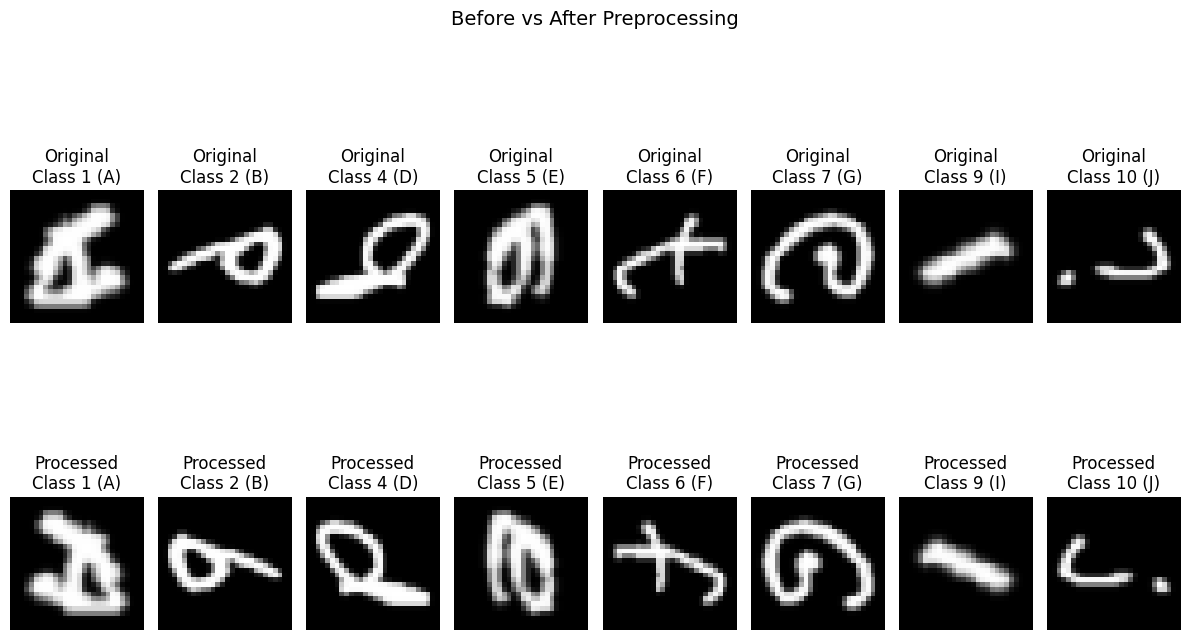


5. Final dataset statistics:
   Final dataset shape: (54589, 785)
   Number of classes: 16
   Classes removed: [-1, -2]
   Images per class:
     Class 1 (A): 3396 samples
     Class 2 (B): 3396 samples
     Class 4 (D): 3398 samples
     Class 5 (E): 3437 samples
     Class 6 (F): 3394 samples
     Class 7 (G): 3385 samples
     Class 9 (I): 3428 samples
     Class 10 (J): 3402 samples
     Class 12 (L): 3415 samples
     Class 14 (N): 3365 samples
     Class 15 (O): 3408 samples
     Class 16 (P): 3430 samples
     Class 17 (Q): 3435 samples
     Class 20 (T): 3436 samples
     Class 24 (X): 3437 samples
     Class 26 (Z): 3427 samples


In [6]:
# Data Cleaning and Preprocessing
def clean_and_preprocess_dataset(data):
    """Clean the dataset by removing blank classes and fixing image orientation"""

    print("=== DATA CLEANING AND PREPROCESSING ===")
    print(f"Original dataset shape: {data.shape}")

    # 1. Remove blank classes (-1 and -2)
    print(f"\n1. Removing blank classes (-1 and -2)...")
    blank_classes = [-1, -2]

    # Show samples before removal
    for blank_class in blank_classes:
        count = len(data[data['label'] == blank_class])
        print(f"   Class {blank_class}: {count} samples (to be removed)")

    # Remove blank classes
    cleaned_data = data[~data['label'].isin(blank_classes)].copy()
    print(f"   Dataset shape after removing blank classes: {cleaned_data.shape}")

    # 2. Fix image orientation (horizontal flip)
    print(f"\n2. Fixing image orientation (horizontal flip)...")

    # Extract pixel columns
    pixel_columns = [col for col in cleaned_data.columns if col.startswith('pixel_')]

    # Function to flip image horizontally
    def flip_image_horizontal(pixel_row):
        # Reshape to 28x28, flip horizontally, then flatten back
        image = pixel_row.values.reshape(28, 28)
        flipped_image = np.fliplr(image)  # Flip left-right
        return flipped_image.flatten()

    # Apply horizontal flip to all images
    print("   Applying horizontal flip to all images...")
    flipped_pixels = cleaned_data[pixel_columns].apply(flip_image_horizontal, axis=1, result_type='expand')

    # Replace pixel columns with flipped versions
    cleaned_data[pixel_columns] = flipped_pixels

    # 3. Update label mapping for alphabetical order
    print(f"\n3. Creating proper label mapping...")

    # Get unique labels (should be 1, 2, 4, 5, 6, 7, 9, 10, 12, 14, 15, 16, 17, 20, 24, 26)
    remaining_labels = sorted(cleaned_data['label'].unique())
    print(f"   Remaining classes: {remaining_labels}")

    # Create mapping to letters (A=1, B=2, C=3, etc., skipping missing letters)
    letter_mapping = {}
    for i in range(1, 27):
        letter = chr(ord('A') + i - 1)  # Convert to letters A, B, C, etc.
        letter_mapping[i] = letter

    print(f"   Label to Letter mapping: {letter_mapping}")

    # 4. Visualize samples after preprocessing
    print(f"\n4. Visualizing samples after preprocessing...")

    # Show before and after comparison for a few samples
    def compare_before_after(original_data, cleaned_data, n_samples=8):
        fig, axes = plt.subplots(2, n_samples, figsize=(12, 8))
        fig.suptitle('Before vs After Preprocessing', fontsize=14)

        # Select samples that exist in both datasets
        common_labels = [label for label in remaining_labels[:n_samples]]

        for i, label in enumerate(common_labels):
            # Original (before cleaning)
            orig_sample = original_data[original_data['label'] == label].iloc[0]
            orig_pixels = orig_sample[pixel_columns].values.reshape(28, 28)

            # Cleaned (after preprocessing)
            clean_sample = cleaned_data[cleaned_data['label'] == label].iloc[0]
            clean_pixels = clean_sample[pixel_columns].values.reshape(28, 28)

            # Plot original
            axes[0, i].imshow(orig_pixels, cmap='gray')
            axes[0, i].set_title(f'Original\nClass {label} ({letter_mapping[label]})')
            axes[0, i].axis('off')

            # Plot cleaned
            axes[1, i].imshow(clean_pixels, cmap='gray')
            axes[1, i].set_title(f'Processed\nClass {label} ({letter_mapping[label]})')
            axes[1, i].axis('off')

        plt.tight_layout()
        plt.show()

    # Show comparison
    compare_before_after(data, cleaned_data, n_samples=8)

    # 5. Final statistics
    print(f"\n5. Final dataset statistics:")
    print(f"   Final dataset shape: {cleaned_data.shape}")
    print(f"   Number of classes: {len(remaining_labels)}")
    print(f"   Classes removed: {blank_classes}")
    print(f"   Images per class:")

    class_distribution = cleaned_data['label'].value_counts().sort_index()
    for label, count in class_distribution.items():
        letter = letter_mapping[label]
        print(f"     Class {label} ({letter}): {count} samples")

    # map labels to letters
    cleaned_data['label'] = cleaned_data['label'].map(letter_mapping)

    return cleaned_data, letter_mapping

# Apply cleaning and preprocessing
cleaned_data, letter_mapping = clean_and_preprocess_dataset(data)

#### After Preprocessing Observation

After applying the initial preprocessing steps (horizontal flipping and relabeling the classes), we made an additional observation:

- **Rotated Letters**  
  - All the characters are still **rotated sideways**.
  - To correct this, we need to **rotate each image by 90 degrees anti-clockwise** so that the letters are properly upright.

---

#### Updated Preprocessing Steps

1. **Remove Blank Images** (`Class -1` and `Class -2`)
2. **Relabel Classes** (Class `1` = `A`, Class `2` = `B`, ...)
3. **Flip Images Horizontally** (to fix mirrored effect)
4. **Rotate Images 90° Anti-Clockwise** (to orient characters correctly)

This ensures the images are in the correct visual format before we apply any further augmentation or training.


=== ROTATING IMAGES 90° ANTI-CLOCKWISE ===
Dataset shape before rotation: (54589, 785)
   Applying 90° anti-clockwise rotation to all images...
   Visualizing before vs after rotation...


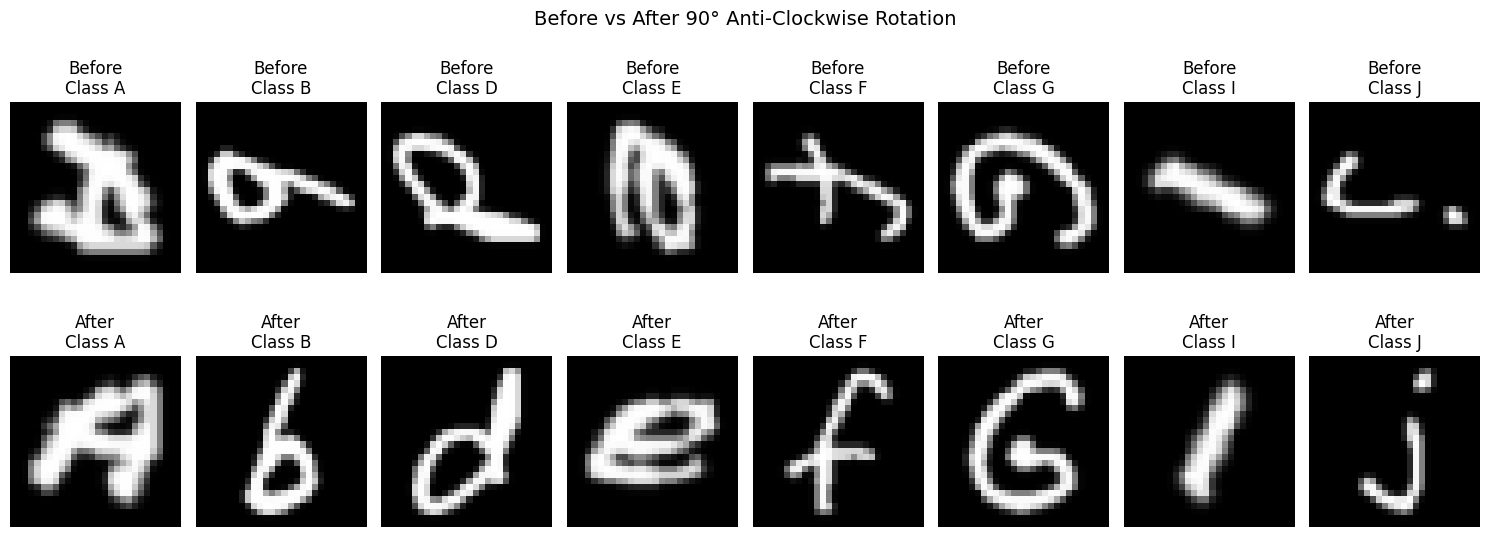

   Final dataset shape after rotation: (54589, 785)
   Rotation completed successfully!


In [7]:
# Rotate all images 90 degrees anti-clockwise
def rotate_images_90_anticlockwise(data):
    """Rotate all images in the dataset 90 degrees anti-clockwise"""

    print("=== ROTATING IMAGES 90° ANTI-CLOCKWISE ===")
    print(f"Dataset shape before rotation: {data.shape}")

    # Extract pixel columns
    pixel_columns = [col for col in data.columns if col.startswith('pixel_')]

    def rotate_image_90_anticlockwise(pixel_row):
        # Reshape to 28x28, rotate 90° anti-clockwise, then flatten back
        image = pixel_row.values.reshape(28, 28)
        rotated_image = np.rot90(image, k=1)  # k=1 means 90° counter-clockwise
        return pd.Series(rotated_image.flatten())

    # Apply rotation to all images
    print("   Applying 90° anti-clockwise rotation to all images...")
    rotated_pixels = data[pixel_columns].apply(rotate_image_90_anticlockwise, axis=1, result_type='expand')
    rotated_pixels = rotated_pixels.astype(np.float32)  # Ensure pixel values are float32

    # Create a copy of the data and replace pixel columns with rotated versions
    rotated_data = data.copy()
    rotated_data[pixel_columns] = rotated_pixels

    # Visualize before and after comparison
    print("   Visualizing before vs after rotation...")

    def compare_rotation(original_data, rotated_data, n_samples=8):
        fig, axes = plt.subplots(2, n_samples, figsize=(15, 6))
        fig.suptitle('Before vs After 90° Anti-Clockwise Rotation', fontsize=14)

        # Select sample labels to visualize
        sample_labels = sorted(original_data['label'].unique())[:n_samples]

        for i, label in enumerate(sample_labels):
            if label in original_data['label'].values:
                # Original (before rotation)
                orig_sample = original_data[original_data['label'] == label].iloc[0]
                orig_pixels = orig_sample[pixel_columns].values.astype(np.float32).reshape(28, 28)

                # Rotated (after rotation)
                rot_sample = rotated_data[rotated_data['label'] == label].iloc[0]
                rot_pixels = rot_sample[pixel_columns].values.astype(np.float32).reshape(28, 28)

                # Plot original
                axes[0, i].imshow(orig_pixels, cmap='gray')
                axes[0, i].set_title(f'Before\nClass {label}')
                axes[0, i].axis('off')

                # Plot rotated
                axes[1, i].imshow(rot_pixels, cmap='gray')
                axes[1, i].set_title(f'After\nClass {label}')
                axes[1, i].axis('off')
            else:
                axes[0, i].axis('off')
                axes[1, i].axis('off')

        plt.tight_layout()
        plt.show()

    # Show comparison
    compare_rotation(data, rotated_data, n_samples=8)

    print(f"   Final dataset shape after rotation: {rotated_data.shape}")
    print("   Rotation completed successfully!")

    return rotated_data

# Apply rotation to the cleaned data
rotated_data = rotate_images_90_anticlockwise(cleaned_data)



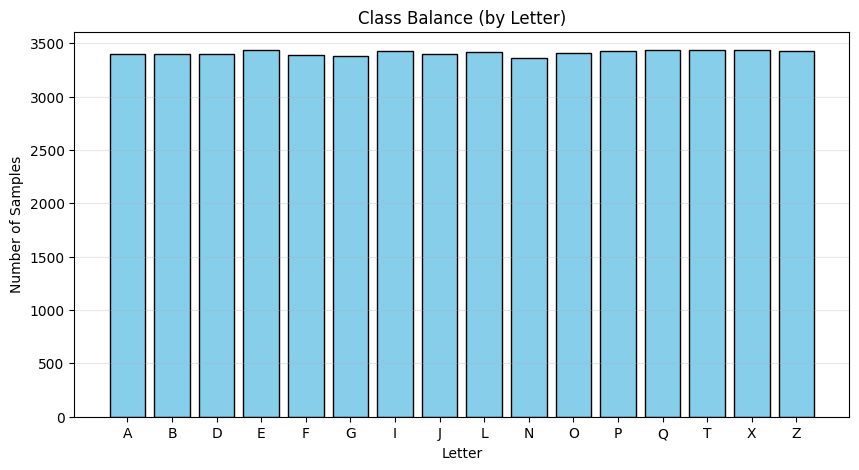

label
A    3396
B    3396
D    3398
E    3437
F    3394
G    3385
I    3428
J    3402
L    3415
N    3365
O    3408
P    3430
Q    3435
T    3436
X    3437
Z    3427


In [8]:
# === Class balance (bar chart) ===
import matplotlib.pyplot as plt

# Count samples per letter (first column is 'label' containing letters)
counts = (
    rotated_data['label']
    .dropna()              # drop blanks if any remained
    .value_counts()
    .sort_index()          # alphabetical order
)

# Plot
plt.figure(figsize=(10, 5))
plt.bar(counts.index, counts.values, color='skyblue', edgecolor='black')
plt.title("Class Balance (by Letter)")
plt.xlabel("Letter")
plt.ylabel("Number of Samples")
plt.grid(axis='y', alpha=0.3)
plt.show()

# Print exact counts
print(counts.to_string())



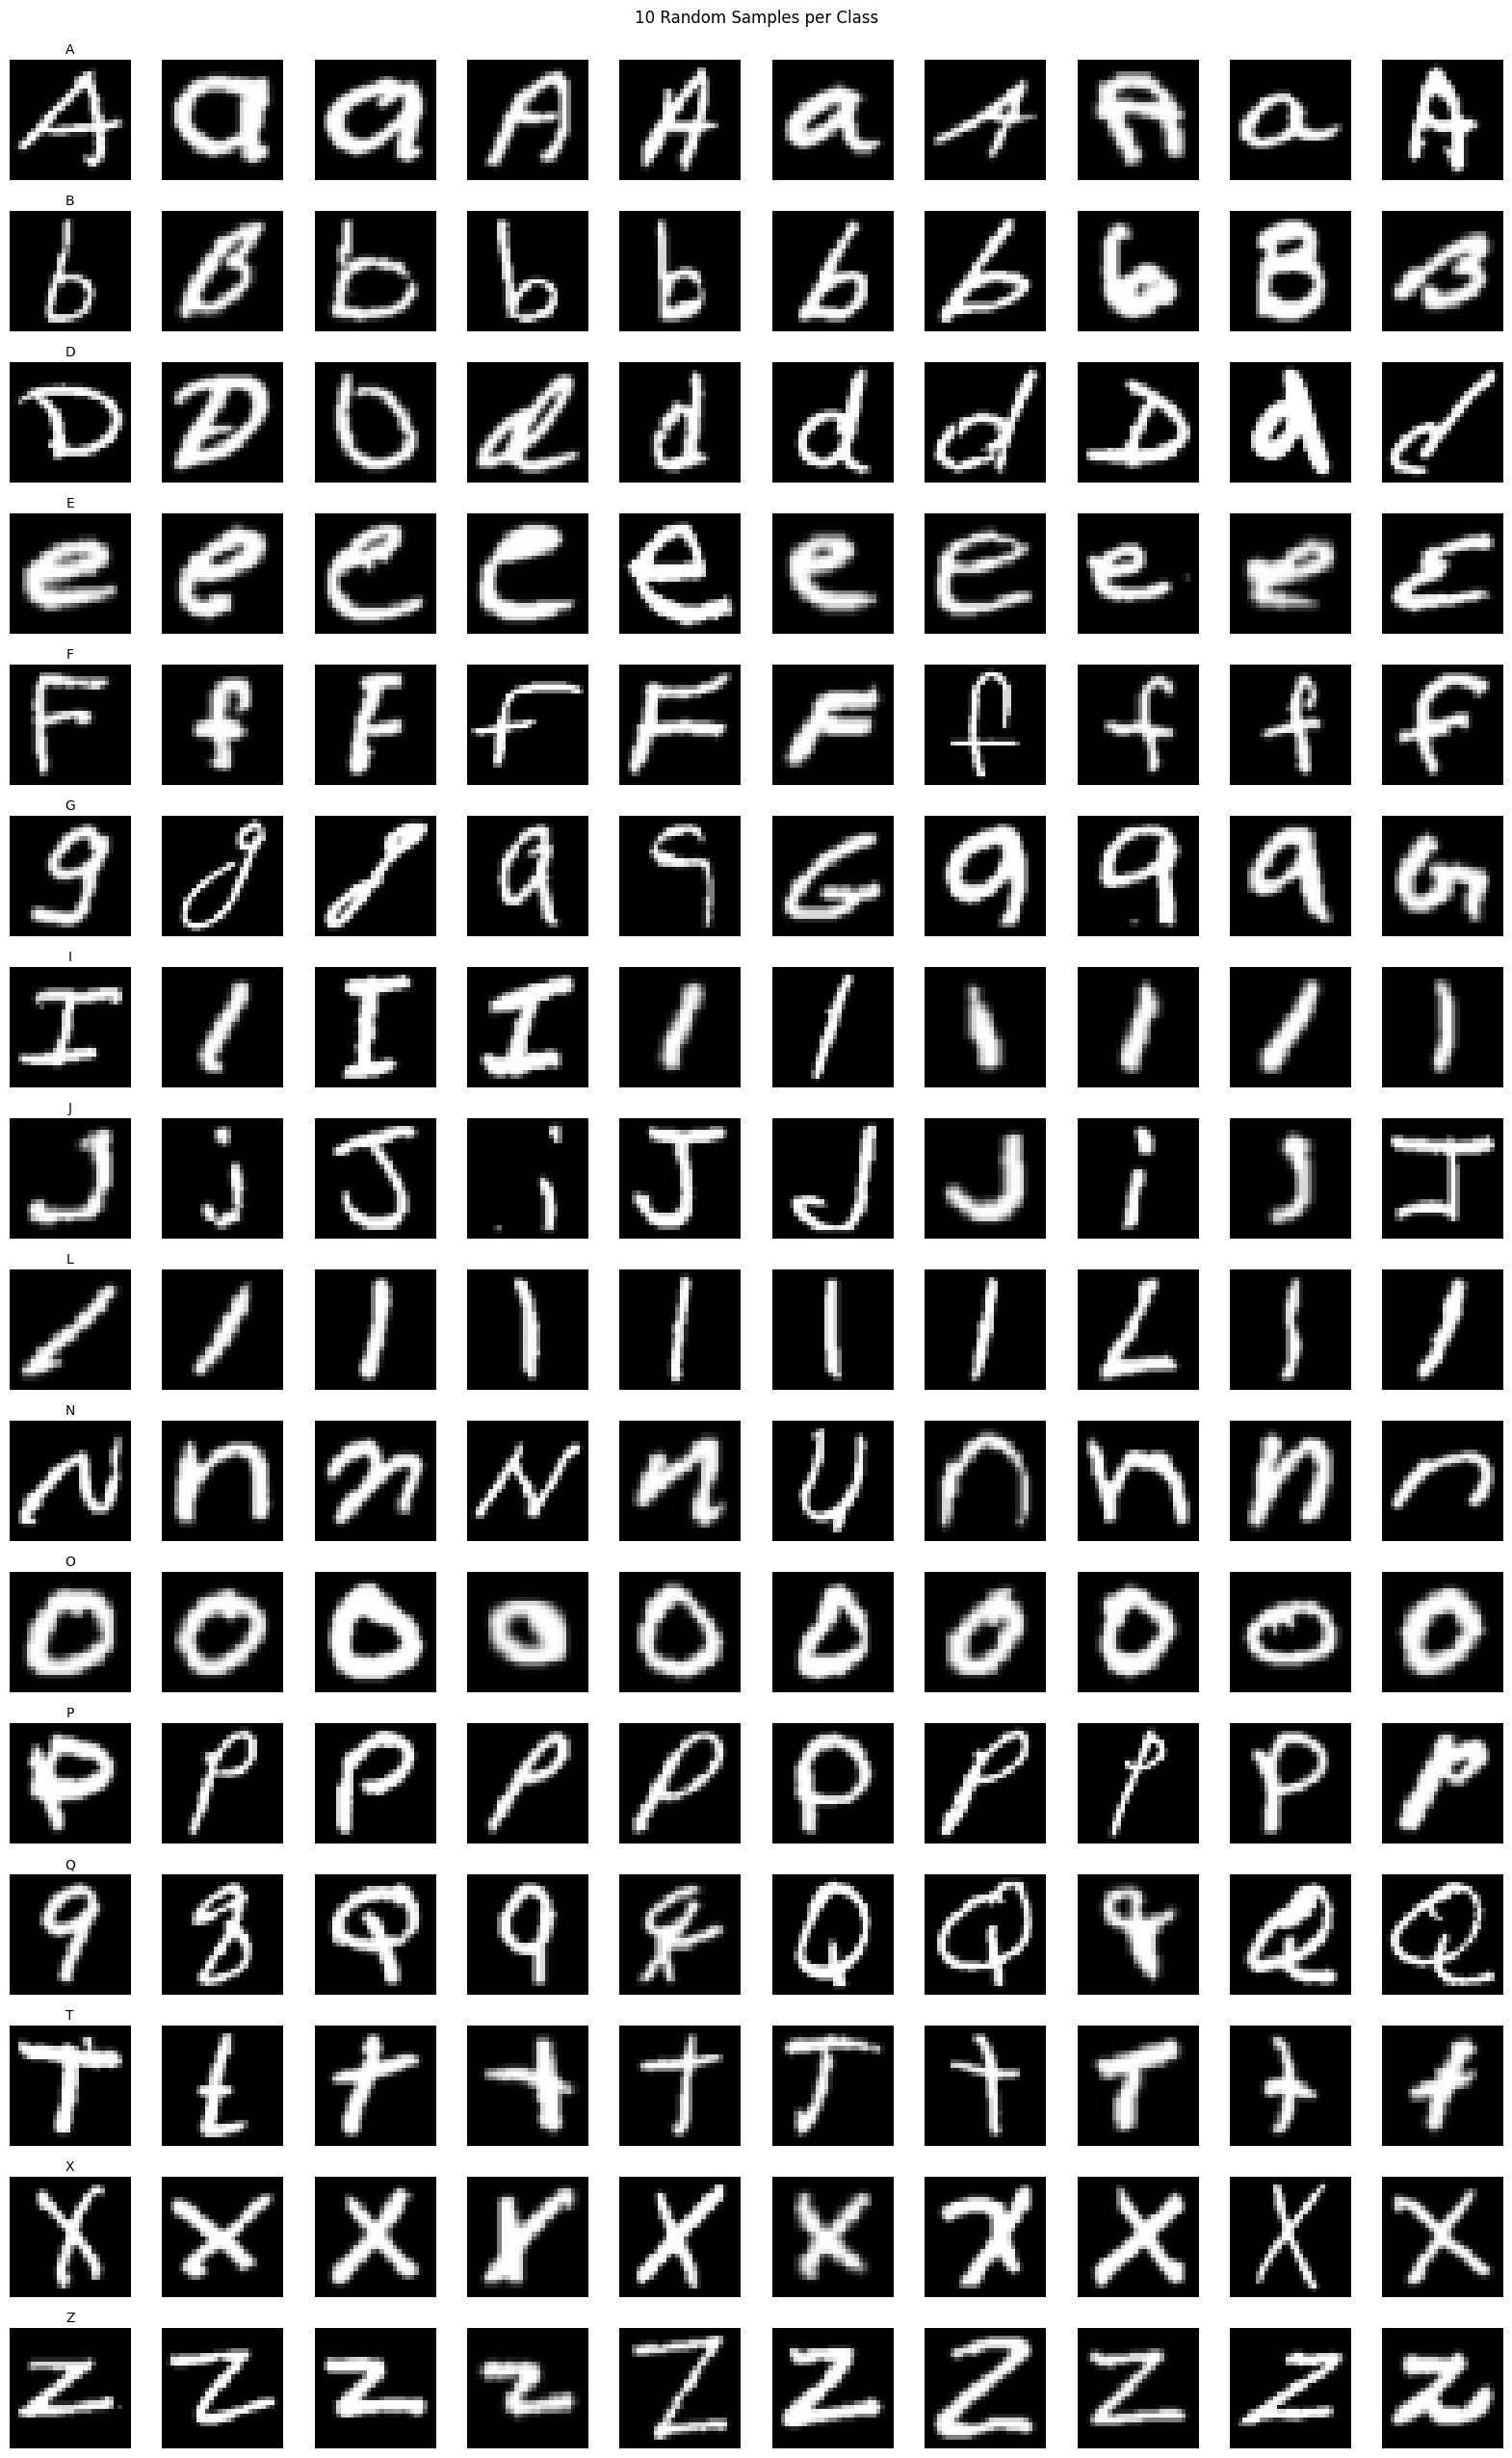

In [9]:
# === Visual inspection: 10 random samples per class ===
import numpy as np
import matplotlib.pyplot as plt

def get_pixel_columns(df):
    """Return list of pixel column names."""
    return [c for c in df.columns if c.startswith("pixel_")]

def show_samples_per_class(df, label_col="label", n_per_class=10, seed=42):
    """
    Display n_per_class random samples for each letter class.

    Args:
        df: DataFrame with a label column (letters) and pixel_0..pixel_783 columns.
        label_col: Column name containing letter labels.
        n_per_class: Number of samples to display per class.
        seed: Random seed for reproducibility.
    """
    pix_cols = get_pixel_columns(df)
    letters = sorted(df[label_col].dropna().unique())
    rng = np.random.default_rng(seed)

    rows = len(letters)
    cols = n_per_class
    fig, axes = plt.subplots(rows, cols, figsize=(1.6*cols, 1.6*rows))
    if rows == 1:
        axes = np.array([axes])  # normalize to 2D array

    for i, letter in enumerate(letters):
        subset = df[df[label_col] == letter]
        take = min(n_per_class, len(subset))
        idx = rng.choice(subset.index, size=take, replace=False)
        samples = subset.loc[idx, pix_cols].values.reshape(take, 28, 28)

        for j in range(cols):
            ax = axes[i, j]
            ax.axis("off")
            if j < take:
                ax.imshow(samples[j], cmap="gray")
            if j == 0:
                ax.set_title(f"{letter}", fontsize=10, pad=4)

    plt.suptitle(f"{n_per_class} Random Samples per Class", y=0.995)
    plt.tight_layout()
    plt.show()

# Run for rotated_data
show_samples_per_class(rotated_data, label_col="label", n_per_class=10, seed=123)


In [10]:
# from sklearn.manifold import TSNE
# import seaborn as sns
# import matplotlib.pyplot as plt
# pixel_columns = [f'pixel_{i}' for i in range(784)]
# # Flatten pixel data
# X_flat = rotated_data[pixel_columns].values
# labels = rotated_data['label'].values

# # Reduce to 2D for visualization
# tsne = TSNE(n_components=2, perplexity=30, random_state=42)
# X_tsne = tsne.fit_transform(X_flat)

# # Plot
# plt.figure(figsize=(10, 8))
# sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=labels, palette='tab20', s=10, alpha=0.6)
# plt.title("t-SNE projection of letters")
# plt.legend(title="Label", bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.show()


### Outliers detection with TSNE and DBSCAN

In [11]:
# from sklearn.manifold import TSNE
# from sklearn.cluster import DBSCAN
# import matplotlib.pyplot as plt
# import pandas as pd
# import numpy as np

# # Prepare t-SNE input
# X_flat = rotated_data[pixel_columns].values
# labels = rotated_data['label'].values

# # Run t-SNE on entire dataset
# tsne = TSNE(n_components=2, perplexity=30, random_state=42)
# X_tsne = tsne.fit_transform(X_flat)

# # Attach t-SNE results to dataframe
# rotated_data['tsne_x'] = X_tsne[:, 0]
# rotated_data['tsne_y'] = X_tsne[:, 1]

# # Store suspected outliers
# outlier_rows = []
# tsne_outlier_indices_by_label = {}

# # For each label, cluster in t-SNE space
# for label in np.unique(labels):
#     subset = rotated_data[rotated_data['label'] == label]
#     coords = subset[['tsne_x', 'tsne_y']].values

#     # DBSCAN: density-based clustering
#     dbscan = DBSCAN(eps=5.0, min_samples=10)
#     cluster_labels = dbscan.fit_predict(coords)

#     # Add cluster labels
#     subset = subset.copy()
#     subset['tsne_cluster'] = cluster_labels

#     # Select outliers: cluster == -1 or rare clusters
#     cluster_counts = subset['tsne_cluster'].value_counts()
#     rare_clusters = cluster_counts[cluster_counts < 15].index
#     is_outlier = subset['tsne_cluster'].isin(rare_clusters)
#     outliers = subset[is_outlier]

#     outlier_rows.append(outliers)
#     print(f"Label {label}: Found {len(outliers)} potential outliers")

# # Combine all outliers
# all_tsne_outliers = pd.concat(outlier_rows, ignore_index=False) if outlier_rows else pd.DataFrame()

# print(f"\n=== t-SNE + DBSCAN: VISUALIZING ALL {len(all_tsne_outliers)} OUTLIERS ===")

# # Visualization function: show original index in full dataset
# def visualize_all_outliers_tsne(df, pixel_columns, max_per_row=10):
#     if df.empty:
#         print("No outliers found!")
#         return

#     labels = sorted(df['label'].unique())

#     for label in labels:
#         subset = df[df['label'] == label]
#         if len(subset) == 0:
#             continue

#         print(f"\nLabel {label}: {len(subset)} outliers")

#         # Grid dimensions
#         n_outliers = len(subset)
#         n_rows = (n_outliers + max_per_row - 1) // max_per_row
#         n_cols = min(max_per_row, n_outliers)

#         fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))

#         # Normalize axes structure
#         if n_rows == 1 and n_cols == 1:
#             axes = np.array([[axes]])
#         elif n_rows == 1:
#             axes = np.array([axes])
#         elif n_cols == 1:
#             axes = axes.reshape(-1, 1)

#         for i, (idx, row) in enumerate(subset.iterrows()):
#             row_idx = i // max_per_row
#             col_idx = i % max_per_row
#             ax = axes[row_idx, col_idx]

#             img = row[pixel_columns].values.astype(np.float32).reshape(28, 28)
#             ax.imshow(img, cmap='gray')
#             ax.set_title(f"Idx {idx}", fontsize=8)
#             ax.axis('off')

#         # Hide any empty subplots
#         total_subplots = n_rows * n_cols
#         for i in range(n_outliers, total_subplots):
#             row_idx = i // max_per_row
#             col_idx = i % max_per_row
#             axes[row_idx, col_idx].axis('off')

#         plt.suptitle(f"t-SNE + DBSCAN: ALL Outliers for Label {label}", fontsize=14)
#         plt.tight_layout()
#         plt.show()

# # Visualize
# visualize_all_outliers_tsne(all_tsne_outliers, pixel_columns)


### Outliers detection with IsolationForest


Anomaly Detection: Isolation-based Approach

This method focuses on identifying anomalies based on how easily they can be "isolated" from the rest of the data points.

* **Global Approach:** The algorithm operates directly on the raw data in its full 784-dimensional pixel space, without any dimensionality reduction. This makes it a "global" approach, considering all features simultaneously.

* **Contamination Parameter:** We assume that **1% of the data are outliers**, which is specified by the `contamination` parameter set to `0.01`. This value helps the model to set a threshold for what constitutes an anomaly.

* **Efficiency:** The key advantage of this method is its speed. It's **faster** than many other techniques because it doesn't require any time-consuming dimensionality reduction steps.

In [12]:
# from sklearn.ensemble import IsolationForest
# import matplotlib.pyplot as plt
# import numpy as np

# # Function to find ALL outliers and visualize them
# def find_and_visualize_all_outliers_iso(data, pixel_columns, contamination=0.01, max_per_row=10):
#     outlier_indices_by_label = {}
#     labels = sorted(data['label'].unique())

#     print(f"=== ISOLATION FOREST: FINDING AND VISUALIZING ALL OUTLIERS ===")

#     for label in labels:
#         subset = data[data['label'] == label]
#         X = subset[pixel_columns].values.astype(np.float32)

#         # Use IsolationForest to detect outliers
#         iso = IsolationForest(contamination=contamination, random_state=42)
#         preds = iso.fit_predict(X)
#         outlier_mask = preds == -1
#         outlier_indices = subset.index[outlier_mask].tolist()
#         outlier_indices_by_label[label] = outlier_indices

#         print(f"Label {label}: Found {len(outlier_indices)} outliers out of {len(subset)} samples.")

#         # Visualize ALL outliers for this label
#         if len(outlier_indices) > 0:
#             outlier_data = subset.loc[outlier_indices]

#             # Calculate grid dimensions
#             n_outliers = len(outlier_data)
#             n_rows = (n_outliers + max_per_row - 1) // max_per_row
#             n_cols = min(max_per_row, n_outliers)

#             fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*2, n_rows*2))

#             # Handle single row/column cases
#             if n_rows == 1 and n_cols == 1:
#                 axes = [axes]
#             elif n_rows == 1:
#                 axes = axes.reshape(1, -1)
#             elif n_cols == 1:
#                 axes = axes.reshape(-1, 1)

#             # Plot each outlier
#             for i, (_, row) in enumerate(outlier_data.iterrows()):
#                 row_idx = i // max_per_row
#                 col_idx = i % max_per_row

#                 img = row[pixel_columns].values.astype(np.float32).reshape(28, 28)

#                 if n_rows == 1:
#                     ax = axes[col_idx]
#                 else:
#                     ax = axes[row_idx, col_idx]

#                 ax.imshow(img, cmap='gray')
#                 ax.set_title(f"Idx {row.name}", fontsize=8)
#                 ax.axis('off')

#             # Hide unused subplots
#             total_subplots = n_rows * n_cols
#             for i in range(n_outliers, total_subplots):
#                 row_idx = i // max_per_row
#                 col_idx = i % max_per_row
#                 if n_rows == 1:
#                     axes[col_idx].axis('off')
#                 else:
#                     axes[row_idx, col_idx].axis('off')

#             plt.suptitle(f"Isolation Forest: ALL Outliers for Label {label}", fontsize=14)
#             plt.tight_layout()
#             plt.show()
#         else:
#             print(f"No outliers to visualize for label {label}")

#     return outlier_indices_by_label

# # Run outlier detection and visualize ALL outliers
# iso_outlier_indices = find_and_visualize_all_outliers_iso(rotated_data, pixel_columns, contamination=0.01)

# # Print summary
# total_iso_outliers = sum(len(indices) for indices in iso_outlier_indices.values())
# print(f"\nTotal Isolation Forest outliers: {total_iso_outliers}")

From visual inspection, we will remove the images, that are too noisy, and move some to correct class.

In [13]:
# Function to remove outliers and update class labels
def process_outliers(data, outliers_to_remove, updates_to_classes):
    """
    Removes specified rows (outliers) and updates labels of specific rows.

    Args:
        data (pd.DataFrame): The dataset to process.
        outliers_to_remove (list): List of indices to remove from the dataset.
        updates_to_classes (dict): Dictionary mapping indices to new class labels.

    Returns:
        pd.DataFrame: The processed dataset.
    """
    print(f"Original dataset shape: {data.shape}")

    # Remove specified outlier rows
    print(f"Removing {len(outliers_to_remove)} rows...")
    data = data.drop(index=outliers_to_remove, errors='ignore')
    print(f"Dataset shape after removal: {data.shape}")

    # Update specified rows to new class labels
    print(f"Updating {len(updates_to_classes)} rows to new labels...")
    for idx, new_label in updates_to_classes.items():
        if idx in data.index:
            data.at[idx, 'label'] = new_label
    print("Label updates completed.")

    return data

# Outliers to remove
outliers_to_remove = [
    5362, 8105, 32140, 30073, 40199, 40364, 49327, 54408, 54665, 56188, 60695, 2424, 3568, 59481, 43186, 48902, 256,
    4249, 6879, 9001, 17046, 32857, 29673, 26107, 35297, 40375, 41278, 44397, 47035, 50432, 50702, 55808, 64400, 18220,
    47810, 51376, 1266, 1647, 13929, 18368, 18411, 21182, 36521, 46041, 52252, 57499, 12751, 3268, 15145, 30626, 44091,
    58212, 9300, 19117, 26187, 26374, 28260, 1388, 11830, 17078, 19585, 19723, 24231, 42125, 3422, 31606, 4208, 6942,
    26121, 41075, 41398, 1041, 32965, 4453, 6936, 13417, 18385, 25194, 27321, 30821, 34134, 34346, 40403, 52909, 58284,
    59675, 61653, 3115, 9284, 20048, 26066, 53852, 8874, 21936, 22151, 54099, 54738, 19940, 22261, 24282, 35728, 37168,
    37701, 37794, 39589, 40233, 57717, 43926, 37338, 17360, 5671, 21688, 64765, 13445, 19584, 20131, 45410, 50703, 61004,
    63433, 12645
]

# Rows to update to new class labels
updates_to_classes = {
    7596: 'A',
    11873: 'D',
    13170: 'E',
    34881: 'E',
    22261: 'O',
    59806: 'B'
}

# Apply the processing function
processed_data = process_outliers(rotated_data, outliers_to_remove, updates_to_classes)

# Summary of changes
print(f"\nProcessed dataset shape: {processed_data.shape}")
print("Changes applied successfully!")

Original dataset shape: (54589, 785)
Removing 121 rows...
Dataset shape after removal: (54468, 785)
Updating 6 rows to new labels...
Label updates completed.

Processed dataset shape: (54468, 785)
Changes applied successfully!


### Seperating Upper and Lower-case Letters
---

 Why Not Split Uppercase/Lowercase Letters into Separate Classes?

We initially thought that separating uppercase and lowercase letters might help us generate cleaner images.  
However, after careful consideration and discussion, we decided **not** to split them.

 Reasons:
1. **Assignment Requirement**  
   - The marking criteria specifies **16 classes only**.  
   - We have already identified the remaining 16 classes after data cleaning.  
   - Splitting upper/lower would result in **more than 16 classes**, breaking the requirement.

2. **Dataset Annotation**  
   - The **EMNIST Letters** dataset often contains **both uppercase and lowercase forms in the same label** — that’s how it was annotated.  
   - Many handwritten letters are ambiguous:  
     - Lowercase **"o"** often looks like uppercase **"O"**  
     - Lowercase **"x"** often looks like uppercase **"X"**

3. **Potential Issues if Split**  
   - **Label noise:** The same visual shape might appear in two different classes depending on interpretation.  
   - **Data imbalance:** Some new “subclasses” may have too few samples, which will hurt GAN training.


## GAN Implementation

In [14]:
# # === Preprocess for Vanilla GAN (unconditional) ===
# def preprocess_data_vanilla_gan(df):
#     """Return flattened images as float32 in [-1,1], shape (N,784)."""
#     pix_cols = [c for c in df.columns if c.startswith("pixel_")]
#     x = df[pix_cols].values.astype(np.float32)  # (N, 784)
#     x = (x - 127.5) / 127.5                     # -> [-1, 1]
#     print(f"Vectors shape: {x.shape}, range [{x.min():.3f}, {x.max():.3f}]")
#     return x

# X_train_gan = preprocess_data_vanilla_gan(rotated_data)

# # tf.data input pipeline
# BATCH_SIZE_GAN = 256
# BUFFER_SIZE_GAN = len(X_train_gan)

# train_ds_gan = (
#     tf.data.Dataset.from_tensor_slices(X_train_gan)
#     .cache()
#     .shuffle(BUFFER_SIZE_GAN)
#     .batch(BATCH_SIZE_GAN, drop_remainder=True)
#     .prefetch(tf.data.AUTOTUNE)
# )


In [15]:
# === Vanilla GAN (Dense-only) ===
class VanillaGAN:
    def __init__(self, vec_dim=784, latent_dim=100, g_lr=2e-4, d_lr=2e-4, beta1=0.5):
        self.vec_dim = vec_dim
        self.latent_dim = latent_dim
        self.ce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()

        self.g_opt = optimizers.Adam(g_lr, beta_1=beta1)
        self.d_opt = optimizers.Adam(d_lr, beta_1=beta1)

        self.d_losses, self.g_losses = [], []

    def build_generator(self):
        z = layers.Input(shape=(self.latent_dim,))
        x = layers.Dense(256, use_bias=False)(z)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)

        x = layers.Dense(512, use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)

        x = layers.Dense(1024, use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)

        out = layers.Dense(self.vec_dim, activation="tanh")(x)  # [-1,1]
        return models.Model(z, out, name="gen_dense")

    def build_discriminator(self):
        v = layers.Input(shape=(self.vec_dim,))
        x = layers.Dense(512)(v)
        x = layers.LeakyReLU()(x)
        x = layers.Dropout(0.3)(x)

        x = layers.Dense(256)(x)
        x = layers.LeakyReLU()(x)
        x = layers.Dropout(0.3)(x)

        out = layers.Dense(1)(x)  # logits
        return models.Model(v, out, name="disc_dense")

    def d_loss(self, real_out, fake_out):
        real = self.ce(tf.ones_like(real_out), real_out)
        fake = self.ce(tf.zeros_like(fake_out), fake_out)
        return real + fake

    def g_loss(self, fake_out):
        return self.ce(tf.ones_like(fake_out), fake_out)


In [16]:
# # === Trainer for Vanilla GAN ===
# class VanillaGANTrainer:
#     def __init__(self, gan, train_ds, latent_dim=100, label_smooth=0.9):
#         self.gan = gan
#         self.ds = train_ds
#         self.latent_dim = latent_dim
#         self.fixed_noise = tf.random.normal([16, latent_dim])
#         self.label_smooth = label_smooth  # set to 1.0 to disable smoothing

#     @tf.function
#     def train_step(self, real_vecs):
#         bsz = tf.shape(real_vecs)[0]
#         noise = tf.random.normal([bsz, self.latent_dim])

#         with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
#             fake_vecs = self.gan.generator(noise, training=True)

#             real_out = self.gan.discriminator(real_vecs, training=True)
#             fake_out = self.gan.discriminator(fake_vecs, training=True)

#             # optional label smoothing on reals
#             real_targets = self.label_smooth * tf.ones_like(real_out)
#             fake_targets_zeros = tf.zeros_like(fake_out)

#             g_loss = self.gan.ce(tf.ones_like(fake_out), fake_out)
#             d_loss = self.gan.ce(real_targets, real_out) + self.gan.ce(fake_targets_zeros, fake_out)

#         g_grads = g_tape.gradient(g_loss, self.gan.generator.trainable_variables)
#         d_grads = d_tape.gradient(d_loss, self.gan.discriminator.trainable_variables)

#         self.gan.g_opt.apply_gradients(zip(g_grads, self.gan.generator.trainable_variables))
#         self.gan.d_opt.apply_gradients(zip(d_grads, self.gan.discriminator.trainable_variables))
#         return d_loss, g_loss

#     def sample_grid(self, epoch):
#         vecs = self.gan.generator(self.fixed_noise, training=False).numpy()
#         imgs = (vecs.reshape(-1,28,28) + 1.0) / 2.0  # -> [0,1]

#         fig, axs = plt.subplots(4, 4, figsize=(6,6))
#         k = 0
#         for i in range(4):
#             for j in range(4):
#                 axs[i,j].imshow(imgs[k], cmap='gray')
#                 axs[i,j].axis('off')
#                 k += 1
#         plt.suptitle(f"Vanilla GAN samples @ epoch {epoch}")
#         plt.tight_layout()
#         plt.show()

#     def train(self, epochs=50, sample_interval=5):
#         for epoch in range(1, epochs+1):
#             d_epoch = g_epoch = 0.0
#             n = 0
#             for batch in self.ds:
#                 d_loss, g_loss = self.train_step(batch)
#                 d_epoch += float(d_loss); g_epoch += float(g_loss); n += 1
#             d_epoch /= max(n,1); g_epoch /= max(n,1)
#             self.gan.d_losses.append(d_epoch); self.gan.g_losses.append(g_epoch)
#             print(f"Epoch {epoch:03d} | D: {d_epoch:.4f} | G: {g_epoch:.4f}")

#             if epoch % sample_interval == 0 or epoch == 1:
#                 self.sample_grid(epoch)


In [17]:
# # === Train Vanilla GAN ===
# vanilla = VanillaGAN(vec_dim=784, latent_dim=100)
# trainer_gan = VanillaGANTrainer(vanilla, train_ds_gan, latent_dim=100, label_smooth=0.9)

# EPOCHS_GAN = 50
# SAMPLE_INTERVAL_GAN = 5
# trainer_gan.train(epochs=EPOCHS_GAN, sample_interval=SAMPLE_INTERVAL_GAN)


In [18]:
# # === Plot loss curves (D & G) ===
# plt.figure(figsize=(7,4))
# plt.plot(vanilla.d_losses, label="D loss")
# plt.plot(vanilla.g_losses, label="G loss")
# plt.title("Training Losses (Vanilla GAN)")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.legend()
# plt.grid(alpha=0.3)
# plt.show()


In [19]:
# # === Generate 7×7 grid for by-eye evaluation ===
# def sample_grid_7x7(gan, latent_dim=100):
#     rng = np.random.default_rng()  # uses the global seed set earlier
#     z = tf.convert_to_tensor(rng.standard_normal((49, latent_dim)).astype(np.float32))
#     vecs = gan.generator(z, training=False).numpy()
#     imgs = (vecs.reshape(-1,28,28) + 1.0) / 2.0  # scale back to [0,1]

#     fig, axs = plt.subplots(7, 7, figsize=(7,7))
#     k = 0
#     for i in range(7):
#         for j in range(7):
#             axs[i,j].imshow(imgs[k], cmap='gray')
#             axs[i,j].axis('off')
#             k += 1
#     plt.suptitle("Vanilla GAN: 7×7 By-Eye Evaluation Grid")
#     plt.tight_layout()
#     plt.show()

# # Call function
# sample_grid_7x7(vanilla, latent_dim=100)



## DCGAN Implementation
---

### Data Preprocessing for GAN Training
---
Let's prepare the data for GAN training by normalizing and reshaping the images.

In [20]:
rotated_data

,label,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,...,pixel_774,pixel_775,pixel_776,pixel_777,pixel_778,pixel_779,pixel_780,pixel_781,pixel_782,pixel_783
0,X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,O,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,J,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64823,Z,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64825,P,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64826,B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64827,T,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
# def preprocess_data_basic_gan(data):
#     """Preprocess the dataset for Basic GAN training."""
#     # Extract pixel data (skip labels)
#     pixels = data.iloc[:, 1:].values

#     # Reshape to 28x28 images and normalize to [-1, 1]
#     images = pixels.reshape(-1, 28, 28)
#     images = (images.astype(np.float32) - 127.5) / 127.5  # Normalize to [-1, 1]

#     # Add channel dimension for compatibility with CNN layers
#     images = np.expand_dims(images, axis=-1)

#     print(f"Images shape: {images.shape}")
#     print(f"Images range: [{images.min():.3f}, {images.max():.3f}]")

#     return images

# # Preprocess the data for Basic GAN
# X_train_gan = preprocess_data_basic_gan(rotated_data)

### 3. GAN Training Implementation
---
Let's implement the training loop for our conditional GAN.

In [22]:
# class BasicGAN:
#     def __init__(self, img_shape=(28, 28, 1), latent_dim=100):
#         """
#         Initialize Basic GAN components: generator and discriminator.
#         Args:
#             img_shape (tuple): Shape of input images (28x28 grayscale).
#             latent_dim (int): Dimensionality of the random noise vector.
#         """
#         self.img_shape = img_shape
#         self.latent_dim = latent_dim
#         self.cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

#         # Build generator and discriminator models
#         self.generator = self.build_generator()
#         self.discriminator = self.build_discriminator()

#         # Optimizers for training
#         self.gen_optimizer = optimizers.Adam(1e-4)
#         self.disc_optimizer = optimizers.Adam(1e-4)

#         # Track losses for visualization
#         self.d_losses = []
#         self.g_losses = []

#     def build_generator(self):
#         """
#         Build the generator model.
#         Returns:
#             tf.keras.Model: Generator model that takes noise as input and outputs synthetic images.
#         """
#         noise_input = layers.Input(shape=(self.latent_dim,))

#         # Dense layer to project noise into feature maps
#         x = layers.Dense(7 * 7 * 256, use_bias=False)(noise_input)
#         x = layers.BatchNormalization()(x)
#         x = layers.LeakyReLU()(x)

#         # Reshape projected features to spatial dimensions
#         x = layers.Reshape((7, 7, 256))(x)

#         # Deconvolutional layers to upsample
#         x = layers.Conv2DTranspose(128, kernel_size=5, strides=1, padding='same', use_bias=False)(x)
#         x = layers.BatchNormalization()(x)
#         x = layers.LeakyReLU()(x)

#         x = layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding='same', use_bias=False)(x)
#         x = layers.BatchNormalization()(x)
#         x = layers.LeakyReLU()(x)

#         # Final layer to output a single channel grayscale image
#         x = layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding='same', use_bias=False, activation='tanh')(x)

#         return models.Model(noise_input, x)

#     def build_discriminator(self):
#         """
#         Build the discriminator model.
#         Returns:
#             tf.keras.Model: Discriminator model that takes images as input and outputs a binary classification.
#         """
#         image_input = layers.Input(shape=self.img_shape)

#         # Convolutional layers to downsample
#         x = layers.Conv2D(64, kernel_size=5, strides=2, padding='same')(image_input)
#         x = layers.LeakyReLU()(x)
#         x = layers.Dropout(0.3)(x)

#         x = layers.Conv2D(128, kernel_size=5, strides=2, padding='same')(x)
#         x = layers.LeakyReLU()(x)
#         x = layers.Dropout(0.3)(x)

#         # Flatten the spatial dimensions and output binary classification
#         x = layers.Flatten()(x)
#         x = layers.Dense(1)(x)

#         return models.Model(image_input, x)

#     def discriminator_loss(self, real_output, fake_output):
#         """
#         Calculate discriminator loss.
#         Args:
#             real_output: Discriminator output for real images
#             fake_output: Discriminator output for fake images
#         Returns:
#             tf.Tensor: Discriminator loss
#         """
#         real_loss = self.cross_entropy(tf.ones_like(real_output), real_output)
#         fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
#         total_loss = real_loss + fake_loss
#         return total_loss

#     def generator_loss(self, fake_output):
#         """
#         Calculate generator loss.
#         Args:
#             fake_output: Discriminator output for fake images
#         Returns:
#             tf.Tensor: Generator loss
#         """
#         return self.cross_entropy(tf.ones_like(fake_output), fake_output)

### 4. GAN Training and Generation
---
Let's train our GAN and generate the required 160 images (10 per class for 16 classes).

In [23]:
# import tensorflow as tf
# from tensorflow.keras import layers, models, optimizers
# import matplotlib.pyplot as plt
# import numpy as np

# class BasicGANTrainer:
#     def __init__(self, gan, train_dataset, latent_dim=100):
#         """
#         Initialize the GAN trainer.
#         Args:
#             gan (BasicGAN): The GAN model containing generator and discriminator.
#             train_dataset (tf.data.Dataset): Dataset of real images for training.
#             latent_dim (int): Dimensionality of the random noise vector.
#         """
#         self.gan = gan
#         self.train_dataset = train_dataset
#         self.latent_dim = latent_dim

#     def train_step(self, images):
#         """
#         A single training step for GAN.
#         Args:
#             images (tf.Tensor): Batch of real images from the dataset.
#         Returns:
#             tuple: Discriminator and generator losses.
#         """
#         noise = tf.random.normal([images.shape[0], self.latent_dim])

#         with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
#             generated_images = self.gan.generator(noise, training=True)
#             real_output = self.gan.discriminator(images, training=True)
#             fake_output = self.gan.discriminator(generated_images, training=True)
#             g_loss = self.gan.generator_loss(fake_output)
#             d_loss = self.gan.discriminator_loss(real_output, fake_output)

#         gradients_gen = gen_tape.gradient(g_loss, self.gan.generator.trainable_variables)
#         gradients_disc = disc_tape.gradient(d_loss, self.gan.discriminator.trainable_variables)

#         self.gan.gen_optimizer.apply_gradients(zip(gradients_gen, self.gan.generator.trainable_variables))
#         self.gan.disc_optimizer.apply_gradients(zip(gradients_disc, self.gan.discriminator.trainable_variables))

#         return d_loss, g_loss

#     def train(self, epochs=30, sample_interval=5):
#         """
#         Train the GAN for a specified number of epochs.
#         Args:
#             epochs (int): Number of epochs for training.
#             sample_interval (int): Interval for sampling and visualizing generated images.
#         """
#         fixed_noise = tf.random.normal([16, self.latent_dim])

#         for epoch in range(epochs):
#             for batch_images in self.train_dataset:
#                 d_loss, g_loss = self.train_step(batch_images)

#             self.gan.d_losses.append(d_loss.numpy())
#             self.gan.g_losses.append(g_loss.numpy())

#             if (epoch + 1) % sample_interval == 0 or epoch == 0:
#                 print(f"Epoch {epoch+1} [D loss: {d_loss:.4f}] [G loss: {g_loss:.4f}]")
#                 self.sample_images(epoch, fixed_noise)

#     def sample_images(self, epoch, noise):
#         """
#         Generate and visualize a batch of images during training.
#         Args:
#             epoch (int): Current epoch number.
#             noise (tf.Tensor): Noise vector for the generator.
#         """
#         gen_imgs = self.gan.generator(noise, training=False)
#         gen_imgs = (gen_imgs + 1) / 2.0  # Rescale [-1, 1] to [0, 1]

#         fig, axs = plt.subplots(4, 4, figsize=(8, 8))
#         cnt = 0
#         for i in range(4):
#             for j in range(4):
#                 axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
#                 axs[i, j].axis('off')
#                 cnt += 1
#         plt.suptitle(f"Generated Images at Epoch {epoch+1}")
#         plt.tight_layout()
#         plt.show()


# # Hyperparameters
# BATCH_SIZE = 256
# BUFFER_SIZE = len(X_train_gan)

# # Create TensorFlow dataset
# train_dataset = tf.data.Dataset.from_tensor_slices(X_train_gan)
# train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# # Initialize the GAN
# gan = BasicGAN(img_shape=(28, 28, 1), latent_dim=100)

# # Initialize the trainer
# trainer = BasicGANTrainer(gan, train_dataset, latent_dim=100)

# # Train the GAN
# trainer.train(epochs=50, sample_interval=5)

As observed, the imges are generated are not classified, in fact, because we are using GAN, which is unable to specify class of the image they produce, meaning we cannot guarantee that we will get images for all 16 classes, so we will find other type of GAN.

## CGAN Implementation
---

### Data Preprocessing for CGAN Training

First, we will have to process the data, so that it is ready to be fed into CGAN.

In [24]:
# === Preprocess for CGAN (letters → ints, images → [-1,1] with channel) ===
import numpy as np

def preprocess_data_cgan(df, label_col="label"):
    """
    Prepare data for CGAN:
      - images: (N, 28, 28, 1) float32 in [-1, 1]
      - labels_encoded: int32 in [0..num_classes-1]
      - classes: sorted list of class letters
      - letter_to_idx / idx_to_letter: mappings for readability
    """
    # Pixels (assumes pixel_0..pixel_783)
    pix_cols = [c for c in df.columns if c.startswith("pixel_")]
    pixels = df[pix_cols].values.astype(np.float32)           # (N, 784)

    images = pixels.reshape(-1, 28, 28)                       # (N, 28, 28)
    images = (images - 127.5) / 127.5                         # [-1, 1]
    images = np.expand_dims(images, axis=-1)                  # (N, 28, 28, 1)

    # Labels: letters → ints (stable alphabetical order)
    labels_letter = df[label_col].astype(str).values
    classes = sorted(np.unique(labels_letter).tolist())       # e.g., 16 letters
    letter_to_idx = {ch: i for i, ch in enumerate(classes)}
    idx_to_letter = {i: ch for ch, i in letter_to_idx.items()}
    labels_encoded = np.array([letter_to_idx[ch] for ch in labels_letter], dtype=np.int32)

    # Diagnostics (concise)
    print(f"Images: {images.shape}, range [{images.min():.3f}, {images.max():.3f}]")
    print(f"Classes ({len(classes)}): {classes}")
    print(f"Mapping (letter→idx): {letter_to_idx}")

    return images, labels_encoded, classes, letter_to_idx, idx_to_letter

# Use it
X_train_cgan, y_train_cgan, classes_cgan, letter_to_idx, idx_to_letter = preprocess_data_cgan(rotated_data)


Images: (54589, 28, 28, 1), range [-1.000, 1.000]
Classes (16): ['A', 'B', 'D', 'E', 'F', 'G', 'I', 'J', 'L', 'N', 'O', 'P', 'Q', 'T', 'X', 'Z']
Mapping (letter→idx): {'A': 0, 'B': 1, 'D': 2, 'E': 3, 'F': 4, 'G': 5, 'I': 6, 'J': 7, 'L': 8, 'N': 9, 'O': 10, 'P': 11, 'Q': 12, 'T': 13, 'X': 14, 'Z': 15}


### CGAN Training Implementation

In [25]:
# ——— Improved ConditionalGAN (with stronger conditioning & anti–mode collapse) ———
# Minimal changes from your version:
#  • Generator: spatial label map + GaussianNoise to keep z influential
#  • Discriminator: input noise + MinibatchStdDev + spatial conditioning
#  • Hinge/BCE losses + optional label smoothing (unchanged)

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, optimizers
import os
from PIL import Image
import matplotlib.pyplot as plt

class MinibatchStdDev(layers.Layer):
    def call(self, x):
        # x: (N,H,W,C)
        mean = tf.reduce_mean(x, axis=0, keepdims=True)
        var  = tf.reduce_mean(tf.square(x - mean), axis=0, keepdims=True)
        std  = tf.sqrt(var + 1e-8)
        stat = tf.reduce_mean(std, axis=[1,2,3], keepdims=True)            # (1,1,1,1)
        stat = tf.tile(stat, [tf.shape(x)[0], x.shape[1], x.shape[2], 1])  # (N,H,W,1)
        return tf.concat([x, stat], axis=-1)

class ConditionalGAN:
    def __init__(self,
                 img_shape=(28, 28, 1),
                 latent_dim=100,
                 num_classes=16,
                 embedding_dim=50,
                 idx_to_letter=None,
                 lr=2e-4, beta1=0.5,
                 use_hinge=False,          # set True to use hinge loss
                 label_smooth=1.0):        # e.g., 0.9 for smoothing, 1.0 to disable
        self.img_shape = img_shape
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.embedding_dim = embedding_dim
        self.idx_to_letter = idx_to_letter or {}
        self.use_hinge = use_hinge
        self.label_smooth = label_smooth

        self.cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

        # Build models
        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()

        # Optimizers (DCGAN-friendly)
        self.gen_optimizer  = optimizers.Adam(learning_rate=lr, beta_1=beta1)
        self.disc_optimizer = optimizers.Adam(learning_rate=lr, beta_1=beta1)

        # Track losses
        self.d_losses = []
        self.g_losses = []

    def build_generator(self):
        noise_input = layers.Input(shape=(self.latent_dim,))
        label_input = layers.Input(shape=(1,), dtype='int32')

        # 1) Label embedding as vector
        lab_vec = layers.Embedding(self.num_classes, self.embedding_dim)(label_input)
        lab_vec = layers.Flatten()(lab_vec)

        # 2) Dense to 7x7 spatial label map (stronger conditioning)
        lab_map = layers.Dense(7 * 7, use_bias=False)(lab_vec)
        lab_map = layers.Reshape((7, 7, 1))(lab_map)  # 1 channel label map

        # 3) Project noise to 7x7x256
        x = layers.Dense(7 * 7 * 256, use_bias=False)(noise_input)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)
        x = layers.Reshape((7, 7, 256))(x)

        # 4) Inject small Gaussian noise so z matters
        x = layers.GaussianNoise(0.05)(x)

        # 5) Concatenate spatial label map early
        x = layers.Concatenate()([x, lab_map])  # (7,7,256+1)

        # Up-sampling stack
        x = layers.Conv2DTranspose(128, 5, strides=1, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)

        x = layers.Conv2DTranspose(64, 5, strides=2, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)

        out = layers.Conv2DTranspose(1, 5, strides=2, padding='same', use_bias=False, activation='tanh')(x)
        return tf.keras.Model([noise_input, label_input], out)

    def build_discriminator(self):
        image_input = layers.Input(shape=self.img_shape)
        label_input = layers.Input(shape=(1,), dtype='int32')

        # Project labels to a spatial map matching the image
        lab_map = layers.Embedding(self.num_classes, np.prod(self.img_shape))(label_input)
        lab_map = layers.Reshape(self.img_shape)(lab_map)

        # Slight input noise to stabilize D
        x_img = layers.GaussianNoise(0.05)(image_input)

        # Concatenate image and label map
        x = layers.Concatenate()([x_img, lab_map])  # (H,W,2)

        x = layers.Conv2D(64, 5, strides=2, padding='same')(x)
        x = layers.LeakyReLU()(x)
        x = layers.Dropout(0.3)(x)

        x = layers.Conv2D(128, 5, strides=2, padding='same')(x)
        x = layers.LeakyReLU()(x)
        x = layers.Dropout(0.3)(x)

        # Minibatch stddev to discourage identical outputs
        x = MinibatchStdDev()(x)
        x = layers.Conv2D(128, 3, strides=1, padding='same')(x)
        x = layers.LeakyReLU()(x)

        x = layers.Flatten()(x)
        out = layers.Dense(1)(x)  # logits
        return tf.keras.Model([image_input, label_input], out)

    # ----- Losses -----
    def d_loss_bce(self, real_out, fake_out):
        real_targets = self.label_smooth * tf.ones_like(real_out)
        fake_targets = tf.zeros_like(fake_out)
        return self.cross_entropy(real_targets, real_out) + self.cross_entropy(fake_targets, fake_out)

    def g_loss_bce(self, fake_out):
        return self.cross_entropy(tf.ones_like(fake_out), fake_out)

    def d_loss_hinge(self, real_out, fake_out):
        # max(0, 1 - real) + max(0, 1 + fake)
        return tf.reduce_mean(tf.nn.relu(1.0 - real_out)) + tf.reduce_mean(tf.nn.relu(1.0 + fake_out))

    def g_loss_hinge(self, fake_out):
        # -E[D(fake)]
        return -tf.reduce_mean(fake_out)

    @tf.function
    def train_step(self, images, labels):
        labels = tf.cast(labels, tf.int32)         # (B,)
        labels_2d = tf.expand_dims(labels, 1)      # (B,1)
        bsz = tf.shape(images)[0]
        noise = tf.random.normal([bsz, self.latent_dim])
        gen_labels = tf.random.uniform([bsz, 1], minval=0, maxval=self.num_classes, dtype=tf.int32)

        with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
            fake_imgs = self.generator([noise, gen_labels], training=True)

            real_out = self.discriminator([images, labels_2d], training=True)
            fake_out = self.discriminator([fake_imgs, gen_labels], training=True)

            if self.use_hinge:
                g_loss = self.g_loss_hinge(fake_out)
                d_loss = self.d_loss_hinge(real_out, fake_out)
            else:
                g_loss = self.g_loss_bce(fake_out)
                d_loss = self.d_loss_bce(real_out, fake_out)

        g_grads = g_tape.gradient(g_loss, self.generator.trainable_variables)
        d_grads = d_tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.gen_optimizer.apply_gradients(zip(g_grads, self.generator.trainable_variables))
        self.disc_optimizer.apply_gradients(zip(d_grads, self.discriminator.trainable_variables))
        return d_loss, g_loss

    def train(self, dataset, epochs=30, sample_interval=5):
        panel = min(16, self.num_classes)
        fixed_noise  = tf.random.normal([panel, self.latent_dim])
        fixed_labels = tf.constant([[i % self.num_classes] for i in range(panel)], dtype=tf.int32)

        for epoch in range(1, epochs + 1):
            d_sum = g_sum = 0.0
            n_batches = 0
            for batch_images, batch_labels in dataset:
                d_loss, g_loss = self.train_step(batch_images, batch_labels)
                d_sum += float(d_loss); g_sum += float(g_loss); n_batches += 1

            d_epoch = d_sum / max(n_batches, 1)
            g_epoch = g_sum / max(n_batches, 1)
            self.d_losses.append(d_epoch); self.g_losses.append(g_epoch)

            if epoch % sample_interval == 0 or epoch == 1:
                print(f"Epoch {epoch:03d} | D: {d_epoch:.4f} | G: {g_epoch:.4f}")
                self.sample_images(epoch, fixed_noise, fixed_labels)

    def sample_images(self, epoch, noise, labels):
        gen = self.generator([noise, labels], training=False)
        gen = (gen + 1.0) / 2.0  # [-1,1] -> [0,1]

        rows = int(np.ceil(gen.shape[0] / 4))
        cols = 4
        fig, axs = plt.subplots(rows, cols, figsize=(2.2*cols, 2.2*rows))
        axs = np.array(axs).reshape(rows, cols)
        k = 0
        for i in range(rows):
            for j in range(cols):
                ax = axs[i, j]
                if k < gen.shape[0]:
                    ax.imshow(gen[k, :, :, 0], cmap='gray')
                    lab_id = int(labels[k].numpy()[0])
                    ax.set_title(self.idx_to_letter.get(lab_id, str(lab_id)))
                ax.axis('off')
                k += 1
        plt.suptitle(f"Generated Images @ Epoch {epoch}")
        plt.tight_layout()
        plt.show()

    # ----- Convenience helpers -----
    def generate_specific_class(self, class_label, num_samples=16):
        noise  = tf.random.normal([num_samples, self.latent_dim])
        labels = tf.constant([[class_label]] * num_samples, dtype=tf.int32)
        gen = self.generator([noise, labels], training=False)
        return (gen + 1.0) / 2.0  # [0,1]

    def save_160_by_class(self, out_dir="cgan_generated_160"):
        """Save 10 images per class (total 160) for submission."""
        os.makedirs(out_dir, exist_ok=True)
        for cls in range(self.num_classes):
            z = tf.random.normal([10, self.latent_dim])
            y = tf.constant([[cls]] * 10, dtype=tf.int32)
            imgs = self.generator([z, y], training=False)
            imgs = ((imgs + 1.0) * 127.5).numpy().astype("uint8")
            for i in range(10):
                Image.fromarray(imgs[i, :, :, 0], mode="L").save(
                    os.path.join(out_dir, f"{cls:02d}_{i:02d}.png")
                )


### CGAN Training and Generation

In [26]:
# # === CGAN input pipeline & training ===
# BATCH_SIZE_CGAN  = 256
# BUFFER_SIZE_CGAN = len(X_train_cgan)
# NUM_CLASSES_CGAN = len(classes_cgan)   # use the classes list from preprocess

# # Build tf.data pipeline (fast + stable)
# def _to_tf_dtype(image, label):
#     # ensure correct dtypes/shapes
#     return (tf.cast(image, tf.float32), tf.cast(label, tf.int32))

# train_dataset_cgan = (
#     tf.data.Dataset.from_tensor_slices((X_train_cgan, y_train_cgan))
#       .shuffle(min(BUFFER_SIZE_CGAN, 10000))     # good shuffle without huge RAM
#       .map(_to_tf_dtype, num_parallel_calls=tf.data.AUTOTUNE)
#       .batch(BATCH_SIZE_CGAN, drop_remainder=True)
#       .cache()
#       .prefetch(tf.data.AUTOTUNE)
# )

# # Initialize CGAN (pass idx_to_letter if you want letter titles in sample grids)
# cgan = ConditionalGAN(
#     img_shape=(28, 28, 1),
#     latent_dim=100,
#     num_classes=NUM_CLASSES_CGAN,
#     embedding_dim=50,
#     idx_to_letter=idx_to_letter  # optional; remove if not defined
# )

# # Train
# cgan.train(train_dataset_cgan, epochs=50, sample_interval=5)



### 5. Generate Required 160 Images (10 per class)
---
Now let's generate 10 images for each of the 16 classes as required by the task.

In [27]:
# from google.colab import drive
# drive.mount('/content/drive')  # Mount Google Drive

# # === Path inside Google Drive ===
# output_dir = "/content/drive/MyDrive/CGAN"

# import os
# from PIL import Image
# import numpy as np
# import tensorflow as tf
# import matplotlib.pyplot as plt

# def save_160_images_cgan(cgan,
#                          num_classes,
#                          out_dir,
#                          latent_dim=100,
#                          seed=42,
#                          idx_to_letter=None,
#                          make_per_class_grid=True):
#     """
#     Saves 10 images per class (total 160) as PNGs to Google Drive.
#     Optionally also saves a per-class grid image (10 samples) for each class.
#     """
#     os.makedirs(out_dir, exist_ok=True)
#     rng = np.random.default_rng(seed)

#     for cls in range(num_classes):
#         # 10 samples for this class
#         z = tf.convert_to_tensor(rng.standard_normal((10, latent_dim)).astype(np.float32))
#         y = tf.constant([[cls]] * 10, dtype=tf.int32)

#         imgs = cgan.generator([z, y], training=False).numpy()
#         imgs = ((imgs + 1.0) * 127.5).clip(0, 255).astype(np.uint8)  # (10, 28, 28, 1)

#         # Save individual images
#         letter = idx_to_letter.get(cls, str(cls)) if idx_to_letter else str(cls)
#         class_dir = os.path.join(out_dir, f"class_{cls:02d}_{letter}")
#         os.makedirs(class_dir, exist_ok=True)

#         for i in range(10):
#             Image.fromarray(imgs[i, :, :, 0], mode="L").save(
#                 os.path.join(class_dir, f"{letter}_c{cls:02d}_{i:02d}.png")
#             )

#         # Optional: save a 2×5 grid per class
#         if make_per_class_grid:
#             rows, cols = 2, 5
#             fig, axs = plt.subplots(rows, cols, figsize=(cols*1.6, rows*1.6))
#             k = 0
#             for r in range(rows):
#                 for c in range(cols):
#                     axs[r, c].imshow(imgs[k, :, :, 0], cmap="gray")
#                     axs[r, c].axis("off")
#                     k += 1
#             fig.suptitle(f"Class {cls:02d} – {letter}", y=0.98)
#             plt.tight_layout()
#             grid_path = os.path.join(out_dir, f"class_{cls:02d}_{letter}_grid.png")
#             plt.savefig(grid_path, dpi=140, bbox_inches="tight")
#             plt.close(fig)

#     print(f"✅ Saved 10 images per class ({num_classes} classes) to: {out_dir}")

# # Run it
# save_160_images_cgan(
#     cgan,
#     num_classes=len(classes_cgan),
#     out_dir=output_dir,
#     latent_dim=100,
#     seed=42,
#     idx_to_letter=idx_to_letter,
#     make_per_class_grid=True
# )


The generated images are visually poor with some classes containing accpetable images, the rest are indistinguishable. Let us analyse current GAN performance.

In [28]:
# from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
# from scipy.linalg import sqrtm
# import numpy as np
# import matplotlib.pyplot as plt
# import tensorflow as tf

# def evaluate_cgan(cgan, X_real, y_real, latent_dim=100, n_samples=1000):
#     """Quick CGAN evaluation: loss curves, sample grid, and FID score."""
#     # 1️⃣ Plot loss curves
#     plt.plot(cgan.g_losses, label="Generator Loss")
#     plt.plot(cgan.d_losses, label="Discriminator Loss")
#     plt.xlabel("Epoch")
#     plt.ylabel("Loss")
#     plt.legend()
#     plt.title("Training Losses")
#     plt.grid(True, alpha=0.3)
#     plt.show()

#     # 2️⃣ Sample grid
#     noise = tf.random.normal([25, latent_dim])
#     labels = tf.constant([[i % cgan.num_classes] for i in range(25)], dtype=tf.int32)
#     gen_imgs = (cgan.generator([noise, labels], training=False) + 1) / 2.0

#     fig, axs = plt.subplots(5, 5, figsize=(6, 6))
#     k = 0
#     for i in range(5):
#         for j in range(5):
#             axs[i, j].imshow(gen_imgs[k, :, :, 0], cmap="gray")
#             axs[i, j].axis("off")
#             k += 1
#     plt.suptitle("Generated Samples")
#     plt.show()

#     # 3️⃣ FID score (downsample to n_samples)
#     idx = np.random.choice(len(X_real), n_samples, replace=False)
#     real_imgs = (X_real[idx] + 1) / 2.0  # normalize to [0,1]
#     z = tf.random.normal([n_samples, latent_dim])
#     gen_labels = tf.random.uniform([n_samples, 1], minval=0, maxval=cgan.num_classes, dtype=tf.int32)
#     fake_imgs = (cgan.generator([z, gen_labels], training=False) + 1) / 2.0

#     fid = calculate_fid(real_imgs, fake_imgs)
#     print(f"FID Score: {fid:.2f}")

# def calculate_fid(images1, images2):
#     """Fréchet Inception Distance for 28x28 grayscale images."""
#     # Resize to 75x75x3 for InceptionV3
#     images1 = tf.image.resize(images1, (75, 75))
#     images2 = tf.image.resize(images2, (75, 75))
#     images1 = tf.image.grayscale_to_rgb(images1)
#     images2 = tf.image.grayscale_to_rgb(images2)

#     # Preprocess
#     images1 = preprocess_input(images1 * 255.0)
#     images2 = preprocess_input(images2 * 255.0)

#     model = InceptionV3(include_top=False, pooling='avg', input_shape=(75, 75, 3))
#     act1 = model.predict(images1, verbose=0)
#     act2 = model.predict(images2, verbose=0)

#     # Calculate FID
#     mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
#     mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
#     ssdiff = np.sum((mu1 - mu2)**2.0)
#     covmean = sqrtm(sigma1.dot(sigma2))
#     if np.iscomplexobj(covmean):
#         covmean = covmean.real
#     fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
#     return fid

# # Example:
# evaluate_cgan(cgan, X_train_cgan, y_train_cgan, latent_dim=100, n_samples=500)


In [29]:
# import numpy as np
# import matplotlib.pyplot as plt

# def plot_training_stability(cgan):
#     """Check if your training was stable (most important for GANs!)"""

#     if not hasattr(cgan, 'g_losses') or not hasattr(cgan, 'd_losses'):
#         print("No training history found. Make sure to store losses during training.")
#         return

#     fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

#     # Plot 1: Basic loss curves
#     ax1.plot(cgan.g_losses, label='Generator Loss', color='blue', linewidth=2)
#     ax1.plot(cgan.d_losses, label='Discriminator Loss', color='red', linewidth=2)
#     ax1.set_title('Training Losses Over Time')
#     ax1.set_xlabel('Epoch')
#     ax1.set_ylabel('Loss')
#     ax1.legend()
#     ax1.grid(True, alpha=0.3)

#     # Plot 2: Loss balance (very important!)
#     loss_ratio = np.array(cgan.g_losses) / (np.array(cgan.d_losses) + 1e-8)
#     ax2.plot(loss_ratio, color='purple', linewidth=2)
#     ax2.axhline(y=1, color='green', linestyle='--', alpha=0.7, label='Perfect Balance')
#     ax2.axhline(y=0.5, color='orange', linestyle='--', alpha=0.7, label='Acceptable Range')
#     ax2.axhline(y=2.0, color='orange', linestyle='--', alpha=0.7)
#     ax2.set_title('Generator/Discriminator Balance')
#     ax2.set_xlabel('Epoch')
#     ax2.set_ylabel('G_Loss / D_Loss')
#     ax2.legend()
#     ax2.grid(True, alpha=0.3)

#     # Plot 3: Recent stability (last 20% of training)
#     recent_epochs = max(10, len(cgan.g_losses) // 5)
#     recent_g = cgan.g_losses[-recent_epochs:]
#     recent_d = cgan.d_losses[-recent_epochs:]

#     ax3.plot(recent_g, label='Generator (Recent)', color='blue', linewidth=2)
#     ax3.plot(recent_d, label='Discriminator (Recent)', color='red', linewidth=2)
#     ax3.set_title('Recent Training Stability')
#     ax3.set_xlabel('Recent Epochs')
#     ax3.set_ylabel('Loss')
#     ax3.legend()
#     ax3.grid(True, alpha=0.3)

#     # Plot 4: Loss smoothness (shows if training is chaotic)
#     window = max(5, len(cgan.g_losses) // 10)
#     g_smooth = np.convolve(cgan.g_losses, np.ones(window)/window, mode='valid')
#     d_smooth = np.convolve(cgan.d_losses, np.ones(window)/window, mode='valid')

#     ax4.plot(g_smooth, label='Generator (Smooth)', color='blue', linewidth=2)
#     ax4.plot(d_smooth, label='Discriminator (Smooth)', color='red', linewidth=2)
#     ax4.set_title('Smoothed Training Curves')
#     ax4.set_xlabel('Epoch')
#     ax4.set_ylabel('Loss (Smoothed)')
#     ax4.legend()
#     ax4.grid(True, alpha=0.3)

#     plt.tight_layout()
#     plt.show()

# # Usage example:
# plot_training_stability(cgan)


### Hyperparameter Tuning

In [30]:
# # ===================== CGAN HYPERPARAMETER TUNING — FULL, FINAL, COLAB-READY =====================
# # Assumes you already defined:
# #   - ConditionalGAN  (your improved class)
# #   - X_train_cgan    (float32, [-1,1], shape [N,28,28,1])
# #   - y_train_cgan    (int labels [0..num_classes-1])
# #   - train_dataset_cgan (tf.data.Dataset of (image,label))
# #   - classes_cgan, idx_to_letter

# import os, json, numpy as np, matplotlib.pyplot as plt, tensorflow as tf
# from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
# from scipy.linalg import sqrtm

# # ---------- 1) Mount Google Drive & set output paths ----------
# from google.colab import drive
# drive.mount('/content/drive')

# BASE_DIR = "/content/drive/MyDrive/CGAN"
# TUNED_DIR = os.path.join(BASE_DIR, "tuned_cgan")
# os.makedirs(TUNED_DIR, exist_ok=True)

# # ---------- 2) Metrics: FID and robust Diversity (MS-SSIM with upscaling) ----------
# def _prep_for_inception(imgs):
#     """
#     imgs: float32 tensor/ndarray in [0,1], shape [N,28,28,1] (grayscale)
#     Returns: preprocessed [N,75,75,3] for InceptionV3 (smaller than 299 to speed up).
#     """
#     imgs = tf.convert_to_tensor(imgs, dtype=tf.float32)
#     imgs = tf.image.resize(imgs, (75, 75))
#     imgs = tf.image.grayscale_to_rgb(imgs)      # 1->3 channels
#     imgs = preprocess_input(imgs * 255.0)       # Inception expects [-1,1] after preprocess_input
#     return imgs

# _inception = None
# def _get_inception():
#     global _inception
#     if _inception is None:
#         _inception = InceptionV3(include_top=False, pooling='avg', input_shape=(75, 75, 3))
#     return _inception

# def calculate_fid(real_imgs_01, fake_imgs_01):
#     """
#     real_imgs_01, fake_imgs_01: [N,H,W,1] in [0,1]
#     """
#     model = _get_inception()
#     real_prep = _prep_for_inception(real_imgs_01)
#     fake_prep = _prep_for_inception(fake_imgs_01)

#     act1 = model.predict(real_prep, verbose=0)
#     act2 = model.predict(fake_prep, verbose=0)

#     mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
#     mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
#     ssdiff = np.sum((mu1 - mu2)**2.0)
#     covmean = sqrtm(sigma1.dot(sigma2))
#     if np.iscomplexobj(covmean):
#         covmean = covmean.real
#     fid = float(ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean))
#     return fid

# def diversity_score(imgs_01, pairs=128, upscale_to=64, use_ms_ssim=True):
#     """
#     imgs_01: float32 in [0,1], shape [N,28,28,1]
#     Returns mean similarity (lower => more diverse).
#     Upsamples to avoid negative output sizes in MS-SSIM on tiny images.
#     """
#     imgs_01 = tf.convert_to_tensor(imgs_01, dtype=tf.float32)
#     n = int(imgs_01.shape[0])
#     if n < 2:
#         return 1.0

#     pairs = min(int(pairs), max(1, n * (n - 1) // 2))
#     i = tf.random.uniform((pairs,), 0, n, dtype=tf.int32)
#     j = tf.random.uniform((pairs,), 0, n, dtype=tf.int32)
#     a = tf.gather(imgs_01, i)
#     b = tf.gather(imgs_01, j)

#     if upscale_to is not None:
#         a = tf.image.resize(a, (upscale_to, upscale_to), method="bilinear")
#         b = tf.image.resize(b, (upscale_to, upscale_to), method="bilinear")

#     try:
#         if use_ms_ssim:
#             scores = tf.image.ssim_multiscale(a, b, max_val=1.0)  # [pairs]
#         else:
#             scores = tf.image.ssim(a, b, max_val=1.0)             # [pairs]
#         return float(tf.reduce_mean(scores).numpy())
#     except Exception:
#         scores = tf.image.ssim(a, b, max_val=1.0, filter_size=7)
#         return float(tf.reduce_mean(scores).numpy())

# def sample_generated(cgan, n, latent_dim=None):
#     if latent_dim is None: latent_dim = cgan.latent_dim
#     z = tf.random.normal([n, latent_dim])
#     y = tf.random.uniform([n, 1], minval=0, maxval=cgan.num_classes, dtype=tf.int32)
#     g = cgan.generator([z, y], training=False)
#     g01 = (g + 1.0)/2.0
#     return g01.numpy()

# # ---------- 3) Single run (train + eval) ----------
# def run_experiment(config,
#                    train_ds,
#                    X_real,                # normalized [-1,1]
#                    n_epochs=15,
#                    eval_samples=512,
#                    sample_interval=5,
#                    save_preview=False,
#                    preview_dir=None):
#     """
#     config: dict of args for ConditionalGAN (e.g., latent_dim, embedding_dim, lr, beta1, use_hinge, label_smooth)
#     Returns: dict with metrics and the trained cgan
#     """
#     tf.keras.backend.clear_session()

#     cfg_copy = dict(config)
#     cfg_copy.pop("name", None)  # don't pass 'name' to the constructor

#     cgan = ConditionalGAN(
#         img_shape=(28,28,1),
#         num_classes=len(classes_cgan),
#         idx_to_letter=idx_to_letter,
#         **cfg_copy
#     )

#     # ---- Train ----
#     for epoch in range(1, n_epochs+1):
#         d_sum = g_sum = 0.0; n = 0
#         for batch_images, batch_labels in train_ds:
#             d_loss, g_loss = cgan.train_step(batch_images, batch_labels)
#             d_sum += float(d_loss); g_sum += float(g_loss); n += 1
#         cgan.d_losses.append(d_sum/max(n,1))
#         cgan.g_losses.append(g_sum/max(n,1))

#         if epoch % sample_interval == 0 or epoch == 1:
#             print(f"[{config.get('name','cfg')}] Epoch {epoch:03d} | D={cgan.d_losses[-1]:.4f} G={cgan.g_losses[-1]:.4f}")
#             if save_preview and preview_dir:
#                 os.makedirs(preview_dir, exist_ok=True)
#                 # quick 5x5 grid
#                 z = tf.random.normal([25, cgan.latent_dim])
#                 y = tf.constant([[i % cgan.num_classes] for i in range(25)], dtype=tf.int32)
#                 gen = (cgan.generator([z, y], training=False) + 1.0)/2.0
#                 fig, axs = plt.subplots(5,5, figsize=(6,6))
#                 k=0
#                 for i in range(5):
#                     for j in range(5):
#                         axs[i,j].imshow(gen[k,:,:,0], cmap='gray'); axs[i,j].axis('off'); k+=1
#                 plt.tight_layout()
#                 plt.savefig(os.path.join(preview_dir, f"{config.get('name','cfg')}_epoch{epoch:03d}.png"), dpi=140)
#                 plt.close(fig)

#     # ---- Evaluate ----
#     idx = np.random.choice(len(X_real), min(eval_samples, len(X_real)), replace=False)
#     real01 = ((X_real[idx] + 1.0) / 2.0).astype(np.float32)

#     fake01 = sample_generated(cgan, n=len(idx), latent_dim=cgan.latent_dim)
#     fid = calculate_fid(real01, fake01)

#     # lower => more diverse (we report the mean similarity, not 1-SSIM)
#     div = diversity_score(fake01, pairs=min(256, len(idx)//2), upscale_to=64, use_ms_ssim=True)

#     return {
#         "config": config,   # keep original (with 'name') for logging
#         "cgan": cgan,
#         "FID": fid,
#         "MS_SSIM": div,
#         "D_losses": cgan.d_losses,
#         "G_losses": cgan.g_losses
#     }

# # ---------- 4) Define search space (adjust/expand as you like) ----------
# search_space = [
#     {"name":"A_lat128_emb64_bce_smooth0.9", "latent_dim":128, "embedding_dim":64, "lr":2e-4, "beta1":0.5, "use_hinge":False, "label_smooth":0.9},
#     {"name":"B_lat128_emb64_hinge",         "latent_dim":128, "embedding_dim":64, "lr":2e-4, "beta1":0.5, "use_hinge":True,  "label_smooth":1.0},
#     {"name":"C_lat100_emb50_bce_smooth1.0", "latent_dim":100, "embedding_dim":50, "lr":2e-4, "beta1":0.5, "use_hinge":False, "label_smooth":1.0},
# ]

# # ---------- 5) Run tuning ----------
# results = []
# PREVIEWS_DIR = os.path.join(TUNED_DIR, "previews")
# for cfg in search_space:
#     res = run_experiment(
#         cfg,
#         train_dataset_cgan,
#         X_train_cgan,           # [-1,1]
#         n_epochs=15,            # keep short for tuning; increase for final training
#         eval_samples=512,
#         sample_interval=5,
#         save_preview=True,
#         preview_dir=PREVIEWS_DIR
#     )
#     print(f"==> {cfg['name']} | FID={res['FID']:.2f} | MS-SSIM={res['MS_SSIM']:.4f}")
#     results.append(res)

# # ---------- 6) Pick best by FID (lower is better) ----------
# best = min(results, key=lambda r: r["FID"])
# best_name = best["config"]["name"]
# print(f"\nBEST: {best_name} | FID={best['FID']:.2f} | MS-SSIM={best['MS_SSIM']:.4f}")

# # ---------- 7) Save best models (.h5) and 160 images (10/class) ----------
# BEST_DIR = os.path.join(TUNED_DIR, f"best_{best_name}")
# os.makedirs(BEST_DIR, exist_ok=True)

# # Save generator & discriminator
# best["cgan"].generator.save(os.path.join(BEST_DIR, "generator_best.h5"))
# best["cgan"].discriminator.save(os.path.join(BEST_DIR, "discriminator_best.h5"))

# # Save metrics & config
# with open(os.path.join(BEST_DIR, "metrics.json"), "w") as f:
#     json.dump({
#         "name": best_name,
#         "FID": best["FID"],
#         "MS_SSIM": best["MS_SSIM"],
#         "config": {k: v for k, v in best["config"].items() if k != "name"}
#     }, f, indent=2)

# # Save 160 images (10 per class) into Drive
# best["cgan"].save_160_by_class(out_dir=os.path.join(BEST_DIR, "generated_160"))

# print(f"\nAll artifacts saved under: {BEST_DIR}")
# print(f"Previews saved under: {PREVIEWS_DIR}")
# ================================================================================================


In [31]:
# # ==== Load best generator and preview 10 images per class ====
# from tensorflow.keras.models import load_model
# import matplotlib.pyplot as plt
# import numpy as np
# import tensorflow as tf

# # Load generator
# gen_path = os.path.join(BEST_DIR, "generator_best.h5")
# generator_best = load_model(gen_path)

# num_classes = len(classes_cgan)  # same as in training
# latent_dim = best["config"]["latent_dim"]

# # Generate 10 images per class
# rows, cols = num_classes, 10
# fig, axes = plt.subplots(rows, cols, figsize=(cols*1.5, rows*1.5))
# for c in range(num_classes):
#     z = tf.random.normal([cols, latent_dim])
#     labels = tf.constant([[c]] * cols, dtype=tf.int32)
#     gen_imgs = (generator_best([z, labels], training=False) + 1) / 2.0  # scale to [0,1]
#     gen_imgs = gen_imgs.numpy()
#     for i in range(cols):
#         axes[c, i].imshow(gen_imgs[i, :, :, 0], cmap='gray')
#         axes[c, i].axis("off")
#         if i == 0:
#             axes[c, i].set_ylabel(classes_cgan[c], fontsize=10)

# plt.tight_layout()
# plt.show()


 Fréchet Inception Distance (FID)
True meaning: Measures similarity between distributions of real and generated features extracted by InceptionV3. Lower is better.
Typical interpretation (natural image datasets):
<10 → Excellent realism
10–50 → Good/Acceptable
50–100 → Fair but noticeable artifacts
>100 → Poor realism or very different distribution from real data
Caveat: On small/grayscale datasets like MNIST or EMNIST, absolute FID numbers tend to be higher than natural images because InceptionV3 was trained on ImageNet. So 142.99 still means poor realism, but you should compare relative improvements between models, not just absolute values.
2. Inception Score (IS)
True meaning: Measures both image quality (confidence of classifier) and diversity (spread over classes). Higher is better.
Typical for ImageNet:
>6 → Excellent (common in natural image GANs)
~2–6 → Acceptable
≤2 → Low quality or diversity
Caveat: On datasets with fewer, simpler classes (like digits), IS will naturally be lower. So 1.367 does mean low quality/diversity for general images, but again, compare relatively between your runs.
3. Kernel Inception Distance (KID)
True meaning: Like FID but unbiased and uses polynomial kernels. Lower is better.
Rule of thumb:
~0.0 → Excellent realism
0.01–0.05 → Good
0.05 → Poorer realism
Your result: 0.0677 suggests realism is not great, but again it’s dataset-dependent.
4. MS-SSIM (Diversity metric)
True meaning: Measures similarity between pairs of generated images. Lower → more diverse.
Typical ranges:
<0.3 → High diversity (good)
0.3–0.7 → Medium diversity
0.9 → Mode collapse (bad)
Your result: 0.2290 means good diversity — the model isn’t just producing clones, even if realism is weak.

## cGAN with Projection Discriminator

In [32]:
# ===== Part 1: Data processing =====
import numpy as np
import pandas as pd
import tensorflow as tf

def preprocess_for_proj_cgan(df, label_col="label"):
    # pixel_0..pixel_783 -> (N,28,28,1) in [-1,1]
    pix_cols = [c for c in df.columns if c.startswith("pixel_")]
    pixels = df[pix_cols].values.astype(np.float32)
    images = pixels.reshape(-1, 28, 28, 1)
    images = (images - 127.5) / 127.5

    # letters -> encoded 0..C-1 (stable alphabetical order)
    labels_letter = df[label_col].astype(str).values
    classes = sorted(np.unique(labels_letter).tolist())
    letter_to_idx = {ch: i for i, ch in enumerate(classes)}
    idx_to_letter = {i: ch for ch, i in letter_to_idx.items()}
    labels_encoded = np.array([letter_to_idx[ch] for ch in labels_letter], dtype=np.int32)

    print(f"Images: {images.shape} in [{images.min():.3f}, {images.max():.3f}]")
    print(f"Classes ({len(classes)}): {classes}")
    return images, labels_encoded, classes, letter_to_idx, idx_to_letter

# Use your rotated_data (already oriented & cleaned)
X_train_proj, y_train_proj, classes_proj, l2i_proj, i2l_proj = preprocess_for_proj_cgan(rotated_data)

# tf.data input pipeline
BATCH_SIZE_PROJ  = 256
BUFFER_SIZE_PROJ = len(X_train_proj)

def _to_tf_dtype(image, label):
    return (tf.cast(image, tf.float32), tf.cast(label, tf.int32))

train_dataset_proj = (
    tf.data.Dataset.from_tensor_slices((X_train_proj, y_train_proj))
      .shuffle(min(BUFFER_SIZE_PROJ, 10000))
      .map(_to_tf_dtype, num_parallel_calls=tf.data.AUTOTUNE)
      .batch(BATCH_SIZE_PROJ, drop_remainder=True)
      .prefetch(tf.data.AUTOTUNE)
)


Images: (54589, 28, 28, 1) in [-1.000, 1.000]
Classes (16): ['A', 'B', 'D', 'E', 'F', 'G', 'I', 'J', 'L', 'N', 'O', 'P', 'Q', 'T', 'X', 'Z']


In [33]:
# ===== Projection cGAN + Spectral Norm + AC-GAN head (FINAL) =====
import os, numpy as np, matplotlib.pyplot as plt, tensorflow as tf
from tensorflow.keras import layers, optimizers
from PIL import Image

# ---------------- Spectral Normalization wrapper ----------------
class SpectralNorm(layers.Wrapper):
    """Applies spectral normalization to a Conv2D/Dense layer (lightweight)."""
    def __init__(self, layer, power_iterations=1, **kwargs):
        super().__init__(layer, **kwargs)
        self.power_iterations = power_iterations

    def build(self, input_shape):
        super().build(input_shape)
        if not hasattr(self.layer, "kernel"):
            raise ValueError("SpectralNorm can only wrap layers with 'kernel' (Conv2D/Dense).")
        w = self.layer.kernel
        self.w_shape = w.shape
        self.u = self.add_weight(
            shape=(1, self.w_shape[-1]),
            initializer=tf.random_normal_initializer(),
            trainable=False,
            name="sn_u"
        )

    def call(self, inputs, training=None):
        w = self.layer.kernel
        w_reshaped = tf.reshape(w, [-1, self.w_shape[-1]])  # (HW*C_in, C_out)

        u_hat = self.u
        for _ in range(self.power_iterations):
            v_hat = tf.linalg.l2_normalize(tf.matmul(u_hat, tf.transpose(w_reshaped)))
            u_hat = tf.linalg.l2_normalize(tf.matmul(v_hat, w_reshaped))

        sigma = tf.matmul(tf.matmul(v_hat, w_reshaped), tf.transpose(u_hat))  # (1,1)
        w_sn = w / (sigma + 1e-12)

        # assign normalized weights back to the wrapped layer
        self.layer.kernel.assign(w_sn)
        self.u.assign(u_hat)

        return self.layer(inputs, training=training)

# ---------------- Projection cGAN with AC head ----------------
class ProjCGAN:
    def __init__(self,
                 img_shape=(28,28,1),
                 latent_dim=128,
                 num_classes=16,
                 embedding_dim=64,
                 idx_to_letter=None,
                 lr=2e-4, beta1=0.5,
                 use_hinge=True,
                 label_smooth=1.0,
                 cls_weight_g=0.5,         # weight for G's class loss
                 cls_weight_d=1.0):        # weight for D's class loss
        self.img_shape = img_shape
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.embedding_dim = embedding_dim
        self.idx_to_letter = idx_to_letter or {}
        self.use_hinge = use_hinge
        self.label_smooth = label_smooth
        self.cls_weight_g = cls_weight_g
        self.cls_weight_d = cls_weight_d

        self.ce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        self.cls_ce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

        self.generator     = self.build_generator()
        self.discriminator = self.build_projection_discriminator_ac()

        self.g_opt = optimizers.Adam(lr, beta_1=beta1)
        self.d_opt = optimizers.Adam(lr, beta_1=beta1)

        self.g_losses, self.d_losses = [], []

    # --------- Generator: noise + label map conditioning ---------
    def build_generator(self):
        z_in  = layers.Input(shape=(self.latent_dim,))
        y_in  = layers.Input(shape=(1,), dtype='int32')

        # Label embedding -> 7x7 spatial map
        e = layers.Embedding(self.num_classes, self.embedding_dim)(y_in)
        e = layers.Flatten()(e)
        lab_map = layers.Dense(7*7, use_bias=False)(e)
        lab_map = layers.Reshape((7,7,1))(lab_map)          # (7,7,1)

        # Noise path
        x = layers.Dense(7*7*256, use_bias=False)(z_in)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)
        x = layers.Reshape((7,7,256))(x)
        x = layers.GaussianNoise(0.05)(x)

        # --- 7x7 block (concat label map at 7x7)
        x = layers.Concatenate()([x, lab_map])              # (7,7,257)

        # --- Upsample to 14x14
        x = layers.Conv2DTranspose(128, 5, strides=2, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)

        # Resize label map to 14x14 via KERAS layers (no tf.image.resize on KerasTensor)
        lab_map_14 = layers.UpSampling2D(size=(2,2), interpolation='nearest')(lab_map)  # (14,14,1)
        x = layers.Concatenate()([x, lab_map_14])            # concat conditioning again

        # --- Upsample to 28x28
        x = layers.Conv2DTranspose(64, 5, strides=2, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)

        # Resize label map to 28x28 (another UpSampling2D)
        lab_map_28 = layers.UpSampling2D(size=(4,4), interpolation='nearest')(lab_map)  # 7->28 directly
        # (or: UpSampling2D(2) on lab_map_14 again)
        x = layers.Concatenate()([x, lab_map_28])

        out = layers.Conv2DTranspose(1, 5, strides=1, padding='same', use_bias=False, activation='tanh')(x)
        return tf.keras.Model([z_in, y_in], out, name="proj_g")

    # --------- Discriminator: projection + AC head ---------
    def build_projection_discriminator_ac(self):
        x_in = layers.Input(shape=self.img_shape)
        y_in = layers.Input(shape=(1,), dtype='int32')

        # SN feature extractor
        x = SpectralNorm(layers.Conv2D(64,  3, strides=2, padding='same'))(x_in)
        x = layers.LeakyReLU()(x); x = layers.Dropout(0.3)(x)
        x = SpectralNorm(layers.Conv2D(128, 3, strides=2, padding='same'))(x)
        x = layers.LeakyReLU()(x); x = layers.Dropout(0.3)(x)
        x = SpectralNorm(layers.Conv2D(128, 3, strides=1, padding='same'))(x)
        x = layers.LeakyReLU()(x)

        h = layers.GlobalAveragePooling2D()(x)                 # (B,C)

        # Adversarial (real/fake) logit with SN + projection
        adv_logit = SpectralNorm(layers.Dense(1))(h)           # (B,1)
        emb = layers.Embedding(self.num_classes, h.shape[-1])(y_in)  # (B,1,C)
        emb = layers.Flatten()(emb)                                  # (B,C)
        proj = layers.Dot(axes=1)([h, emb])                          # (B,1)
        adv_logit = layers.Add()([adv_logit, proj])                  # (B,1)

        # NEW: class logits head (AC-GAN)
        cls_logits = layers.Dense(self.num_classes)(h)         # (B,num_classes)

        return tf.keras.Model([x_in, y_in], [adv_logit, cls_logits], name="proj_d_ac")

    # --------- Losses ---------
    def _d_adv_loss(self, real_out, fake_out):
        if self.use_hinge:
            return tf.reduce_mean(tf.nn.relu(1. - real_out)) + tf.reduce_mean(tf.nn.relu(1. + fake_out))
        else:
            real_targets = self.label_smooth * tf.ones_like(real_out)
            fake_targets = tf.zeros_like(fake_out)
            return self.ce(real_targets, real_out) + self.ce(fake_targets, fake_out)

    def _g_adv_loss(self, fake_out):
        if self.use_hinge:
            return -tf.reduce_mean(fake_out)
        else:
            return self.ce(tf.ones_like(fake_out), fake_out)

    @tf.function
    def train_step(self, images, labels):
        labels = tf.cast(labels, tf.int32)        # (B,)
        labels_2d = tf.expand_dims(labels, 1)     # (B,1)
        bsz = tf.shape(images)[0]
        z = tf.random.normal([bsz, self.latent_dim])
        y_gen = tf.random.uniform([bsz, 1], minval=0, maxval=self.num_classes, dtype=tf.int32)
        y_gen_flat = tf.squeeze(y_gen, axis=1)    # (B,)

        with tf.GradientTape() as d_tape, tf.GradientTape() as g_tape:
            fake = self.generator([z, y_gen], training=True)

            real_adv, real_cls = self.discriminator([images, labels_2d], training=True)
            fake_adv, fake_cls = self.discriminator([fake,   y_gen],     training=True)

            # adversarial parts
            d_adv = self._d_adv_loss(real_adv, fake_adv)
            g_adv = self._g_adv_loss(fake_adv)

            # classification parts (force correct class on real & fake)
            d_cls = self.cls_ce(labels, real_cls) + self.cls_ce(y_gen_flat, fake_cls)
            g_cls = self.cls_ce(y_gen_flat, fake_cls)

            d_loss = d_adv + self.cls_weight_d * d_cls
            g_loss = g_adv + self.cls_weight_g * g_cls

        d_grads = d_tape.gradient(d_loss, self.discriminator.trainable_variables)
        g_grads = g_tape.gradient(g_loss, self.generator.trainable_variables)
        self.d_opt.apply_gradients(zip(d_grads, self.discriminator.trainable_variables))
        self.g_opt.apply_gradients(zip(g_grads, self.generator.trainable_variables))
        return d_loss, g_loss

    # --------- Training & convenience ---------
    def train(self, dataset, epochs=30, sample_interval=5):
        panel = min(16, self.num_classes)
        fixed_z  = tf.random.normal([panel, self.latent_dim])
        fixed_y  = tf.constant([[i % self.num_classes] for i in range(panel)], dtype=tf.int32)

        for ep in range(1, epochs+1):
            d_sum = g_sum = 0.0; n=0
            for imgs, lbls in dataset:
                d_l, g_l = self.train_step(imgs, lbls)
                d_sum += float(d_l); g_sum += float(g_l); n += 1
            self.d_losses.append(d_sum/max(n,1)); self.g_losses.append(g_sum/max(n,1))

            if ep % sample_interval == 0 or ep == 1:
                print(f"[ProjCGAN-AC] Epoch {ep:03d} | D={self.d_losses[-1]:.4f} | G={self.g_losses[-1]:.4f}")
                # (optional) preview:
                # self.sample_grid(fixed_z, fixed_y, title=f"Epoch {ep}")

    def sample_grid(self, z, y, title="Samples"):
        gen = (self.generator([z, y], training=False) + 1.0) / 2.0
        r = int(np.ceil(gen.shape[0] / 4)); c = 4
        fig, axs = plt.subplots(r, c, figsize=(2.2*c, 2.2*r))
        axs = np.array(axs).reshape(r, c)
        k=0
        for i in range(r):
            for j in range(c):
                ax = axs[i,j]
                if k < gen.shape[0]:
                    ax.imshow(gen[k,:,:,0], cmap='gray')
                    lab = int(y[k].numpy()[0])
                    ax.set_title(self.idx_to_letter.get(lab, str(lab)))
                ax.axis('off'); k+=1
        plt.suptitle(title); plt.tight_layout(); plt.show()

    def generate_specific_class(self, class_id, n=16):
        z = tf.random.normal([n, self.latent_dim])
        y = tf.constant([[class_id]] * n, dtype=tf.int32)
        gen = (self.generator([z, y], training=False) + 1.0)/2.0
        return gen.numpy()

    def save_160_by_class(self, out_dir="proj_cgan_160"):
        os.makedirs(out_dir, exist_ok=True)
        for cls in range(self.num_classes):
            z = tf.random.normal([10, self.latent_dim])
            y = tf.constant([[cls]] * 10, dtype=tf.int32)
            imgs = self.generator([z, y], training=False).numpy()
            imgs = ((imgs + 1.0) * 127.5).clip(0,255).astype(np.uint8)
            for i in range(10):
                Image.fromarray(imgs[i,:,:,0], mode="L").save(
                    os.path.join(out_dir, f"{cls:02d}_{i:02d}.png")
                )

In [34]:
# # Instantiate (use your own classes/idx_to_letter)
# proj_cgan = ProjCGAN(
#     img_shape=(28,28,1),
#     latent_dim=128,
#     num_classes=len(classes_proj),
#     embedding_dim=64,
#     idx_to_letter=i2l_proj,
#     lr=2e-4, beta1=0.5,
#     use_hinge=True,
#     label_smooth=1.0,
#     cls_weight_g=0.5,   # weight for generator class loss (0.25–1.0 works)
#     cls_weight_d=1.0    # weight for discriminator class loss
# )

# # Train (silent, no previews)
# proj_cgan.train(train_dataset_proj, epochs=40, sample_interval=5)

# # Quick check: real vs fake for a chosen class id (e.g., 'A' index)
# cid = 0  # <- set to the encoded id of 'A'
# fake = proj_cgan.generate_specific_class(cid, n=10)
# fig, axs = plt.subplots(1, 10, figsize=(12, 1.8))
# for i in range(10):
#     axs[i].imshow(fake[i,:,:,0], cmap='gray'); axs[i].axis('off')
# plt.suptitle(f"FAKE class {cid}: {i2l_proj.get(cid, cid)}"); plt.show()


In [35]:
# # ===== Part 3: Training only (no previews) =====

# # Instantiate Projection cGAN
# proj_cgan = ProjCGAN(
#     img_shape=(28, 28, 1),
#     latent_dim=128,                 # a bit larger for intra-class diversity
#     num_classes=len(classes_proj),
#     embedding_dim=64,
#     idx_to_letter=i2l_proj,
#     lr=2e-4, beta1=0.5,
#     use_hinge=True,                 # hinge + projection + SN = good combo
#     label_smooth=1.0
# )

# # Train silently (sample_interval just controls console prints)
# proj_cgan.train(train_dataset_proj, epochs=40, sample_interval=5)


In [36]:
# # ========= Evaluate the trained Projection cGAN (this model only) =========
# import numpy as np, matplotlib.pyplot as plt, tensorflow as tf, os
# from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
# from scipy.linalg import sqrtm

# # ----- hook up THIS trained model and its data -----
# GEN_MODEL     = proj_cgan           # <— your trained model from Part 3
# X_REAL_ALL    = X_train_proj        # real images in [-1,1], shape [N,28,28,1]
# Y_REAL_ALL    = y_train_proj        # int labels 0..C-1
# CLASS_NAMES   = classes_proj        # list of letters
# IDX_TO_LETTER = i2l_proj            # optional mapping

# # ----- helpers: FID, diversity, sampling -----
# _INCEP = None
# def _get_inception():
#     global _INCEP
#     if _INCEP is None:
#         _INCEP = InceptionV3(include_top=False, pooling='avg', input_shape=(75,75,3))
#     return _INCEP

# def _prep_for_inception(imgs_01):
#     x = tf.convert_to_tensor(imgs_01, dtype=tf.float32)   # [N,28,28,1] in [0,1]
#     x = tf.image.resize(x, (75,75))
#     x = tf.image.grayscale_to_rgb(x)
#     x = preprocess_input(x * 255.0)
#     return x

# def calculate_fid(real01, fake01):
#     model = _get_inception()
#     r = _prep_for_inception(real01); f = _prep_for_inception(fake01)
#     act_r = model.predict(r, verbose=0); act_f = model.predict(f, verbose=0)
#     mu_r, sig_r = act_r.mean(axis=0), np.cov(act_r, rowvar=False)
#     mu_f, sig_f = act_f.mean(axis=0), np.cov(act_f, rowvar=False)
#     ssdiff = np.sum((mu_r - mu_f)**2.0)
#     covmean = sqrtm(sig_r.dot(sig_f))
#     if np.iscomplexobj(covmean): covmean = covmean.real
#     return float(ssdiff + np.trace(sig_r + sig_f - 2.0 * covmean))

# def diversity_ms_ssim(imgs01, pairs=256, upscale_to=64):
#     imgs01 = tf.convert_to_tensor(imgs01, dtype=tf.float32)
#     n = int(imgs01.shape[0])
#     if n < 2: return 1.0
#     pairs = min(pairs, max(1, n*(n-1)//2))
#     i = tf.random.uniform((pairs,), 0, n, dtype=tf.int32)
#     j = tf.random.uniform((pairs,), 0, n, dtype=tf.int32)
#     a = tf.gather(imgs01, i); b = tf.gather(imgs01, j)
#     a = tf.image.resize(a, (upscale_to, upscale_to))
#     b = tf.image.resize(b, (upscale_to, upscale_to))
#     try:
#         scores = tf.image.ssim_multiscale(a, b, max_val=1.0)
#     except Exception:
#         scores = tf.image.ssim(a, b, max_val=1.0, filter_size=7)
#     return float(tf.reduce_mean(scores).numpy())  # lower ⇒ more diverse

# def gen_samples_for_class(model, class_id, n):
#     z = tf.random.normal([n, model.latent_dim])
#     y = tf.constant([[class_id]]*n, dtype=tf.int32)
#     g = model.generator([z, y], training=False)
#     return ((g + 1.0)/2.0).numpy()     # [n,28,28,1] in [0,1]

# def pick_real_subset_per_class(X, y, per_class=32):
#     xs = []
#     for c in range(len(CLASS_NAMES)):
#         idx = np.where(y == c)[0]
#         take = min(per_class, len(idx))
#         sel = np.random.choice(idx, size=take, replace=False)
#         xs.append(X[sel])
#     return np.concatenate(xs, axis=0)

# # ----- 1) Overall metrics (balanced subset) -----
# Xr = pick_real_subset_per_class(X_REAL_ALL, Y_REAL_ALL, per_class=32)
# Xr01 = ((Xr + 1.0) / 2.0).astype(np.float32)

# Xg_parts = [gen_samples_for_class(GEN_MODEL, c, n=32) for c in range(len(CLASS_NAMES))]
# Xg01 = np.concatenate(Xg_parts, axis=0).astype(np.float32)

# fid = calculate_fid(Xr01, Xg01)
# ms = diversity_ms_ssim(Xg01, pairs=min(256, len(Xg01)//2), upscale_to=64)

# print(f"Overall FID (32/class): {fid:.2f}")
# print(f"Mean MS-SSIM on generated set (lower ⇒ more diverse): {ms:.4f}")

# # ----- 2) Per-class FID -----
# print("\nPer-class FID:")
# pc_fid = {}
# for c in range(len(CLASS_NAMES)):
#     # real subset for class c
#     idx = np.where(Y_REAL_ALL == c)[0]
#     take = min(64, len(idx))
#     sel = np.random.choice(idx, size=take, replace=False)
#     real01 = ((X_REAL_ALL[sel] + 1.0) / 2.0).astype(np.float32)
#     fake01 = gen_samples_for_class(GEN_MODEL, c, n=take).astype(np.float32)
#     pc_fid[c] = calculate_fid(real01, fake01)
#     print(f"  {CLASS_NAMES[c]:>2}: {pc_fid[c]:.2f}")

# # ----- 3) Loss curves from this training run -----
# if hasattr(GEN_MODEL, "g_losses") and hasattr(GEN_MODEL, "d_losses"):
#     plt.figure(figsize=(6.5,4))
#     plt.plot(GEN_MODEL.g_losses, label="G loss")
#     plt.plot(GEN_MODEL.d_losses, label="D loss")
#     plt.title("ProjCGAN Training Losses")
#     plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.grid(alpha=0.3); plt.legend(); plt.show()
# else:
#     print("No stored losses on model to plot.")

# # ----- 4) 10 samples per class grid -----
# rows, cols = len(CLASS_NAMES), 10
# fig, axes = plt.subplots(rows, cols, figsize=(cols*1.2, rows*1.2))
# for c in range(rows):
#     gen = gen_samples_for_class(GEN_MODEL, c, n=cols)
#     for j in range(cols):
#         axes[c, j].imshow(gen[j,:,:,0], cmap='gray'); axes[c, j].axis('off')
#     axes[c, 0].set_ylabel(CLASS_NAMES[c], fontsize=10, rotation=0, labelpad=12)
# plt.tight_layout(); plt.show()

# # ----- 5) Quick summary for your report -----
# hard = sorted(pc_fid.items(), key=lambda kv: kv[1], reverse=True)[:3]
# easy = sorted(pc_fid.items(), key=lambda kv: kv[1])[:3]
# print("\nSummary:")
# print(f"- Overall FID: {fid:.2f}; Diversity (MS-SSIM): {ms:.4f}")
# print(f"- Hardest classes: {[CLASS_NAMES[c] for c,_ in hard]}")
# print(f"- Easiest classes: {[CLASS_NAMES[c] for c,_ in easy]}")


## WGAN

In [37]:
import numpy as np
import pandas as pd
import tensorflow as tf

# ---- build arrays for WGAN ----
def to_arrays_for_wgan(df, label_col="label"):
    # pixel columns
    pix_cols = [c for c in df.columns if c.startswith("pixel_")]
    X = df[pix_cols].values.astype(np.float32).reshape(-1, 28, 28, 1)  # [N,28,28,1]
    X = (X - 127.5) / 127.5  # [-1,1]
    # encode letters -> [0..C-1]
    letters = sorted(df[label_col].dropna().unique().tolist())
    l2i = {ch:i for i,ch in enumerate(letters)}
    i2l = {i:ch for ch,i in l2i.items()}
    y = df[label_col].map(l2i).values.astype(np.int32)
    return X, y, letters, l2i, i2l

X_train_wgan, y_train_wgan, classes_wgan, l2i_wgan, i2l_wgan = to_arrays_for_wgan(rotated_data, label_col="label")

# ---- tf.data pipeline ----
BATCH_SIZE_WGAN  = 256
BUFFER_SIZE_WGAN = len(X_train_wgan)

def _cast_pair(x, y):
    return (tf.cast(x, tf.float32), tf.cast(y, tf.int32))

train_dataset_wgan = (tf.data.Dataset
    .from_tensor_slices((X_train_wgan, y_train_wgan))
    .shuffle(min(BUFFER_SIZE_WGAN, 10000))
    .map(_cast_pair, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE_WGAN, drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE))

len(classes_wgan), X_train_wgan.shape


(16, (54589, 28, 28, 1))

In [38]:
import tensorflow as tf
from tensorflow.keras import layers, optimizers
import numpy as np
import matplotlib.pyplot as plt

class CWGANGP:
    def __init__(self,
                 img_shape=(28,28,1),
                 latent_dim=128,
                 num_classes=16,
                 embedding_dim=64,
                 gp_weight=10.0,
                 n_critic=5,
                 lr=1e-4, beta1=0.0, beta2=0.9,
                 idx_to_letter=None):
        self.img_shape = img_shape
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.embedding_dim = embedding_dim
        self.gp_weight = gp_weight
        self.n_critic = n_critic
        self.idx_to_letter = idx_to_letter or {}

        self.generator     = self.build_generator()
        self.critic        = self.build_critic()   # "critic" instead of discriminator

        self.g_opt = optimizers.Adam(lr, beta_1=beta1, beta_2=beta2)
        self.c_opt = optimizers.Adam(lr, beta_1=beta1, beta_2=beta2)

        self.c_scores, self.g_scores = [], []   # WGAN "loss" (critic score stats)

    # --------- Generator: z + label embedding vector -----------
    def build_generator(self):
        z_in = layers.Input(shape=(self.latent_dim,))
        y_in = layers.Input(shape=(1,), dtype='int32')

        y_vec = layers.Embedding(self.num_classes, self.embedding_dim)(y_in)
        y_vec = layers.Flatten()(y_vec)
        z = layers.Concatenate()([z_in, y_vec])

        x = layers.Dense(7*7*256, use_bias=False, kernel_initializer="he_normal")(z)
        x = layers.BatchNormalization()(x); x = layers.LeakyReLU()(x)
        x = layers.Reshape((7,7,256))(x)

        x = layers.Conv2DTranspose(128, 5, strides=2, padding='same', use_bias=False, kernel_initializer="he_normal")(x)
        x = layers.BatchNormalization()(x); x = layers.LeakyReLU()(x)

        x = layers.Conv2DTranspose(64, 5, strides=2, padding='same', use_bias=False, kernel_initializer="he_normal")(x)
        x = layers.BatchNormalization()(x); x = layers.LeakyReLU()(x)

        out = layers.Conv2DTranspose(1, 5, strides=1, padding='same', use_bias=False,
                                     activation='tanh', kernel_initializer="glorot_uniform")(x)
        return tf.keras.Model([z_in, y_in], out, name="wgan_g")

    # --------- Critic: image + label map concatenated as channels -----------
    def build_critic(self):
        x_in = layers.Input(shape=self.img_shape)
        y_in = layers.Input(shape=(1,), dtype='int32')

        # turn label into 28x28 map, concat as extra channel
        y_vec = layers.Embedding(self.num_classes, 28*28)(y_in)
        y_map = layers.Reshape((28,28,1))(y_vec)  # 1 channel mask
        x = layers.Concatenate()([x_in, y_map])   # (28,28,2)

        x = layers.Conv2D(64, 5, strides=2, padding='same', kernel_initializer="he_normal")(x)
        x = layers.LeakyReLU()(x)

        x = layers.Conv2D(128, 5, strides=2, padding='same', kernel_initializer="he_normal")(x)
        x = layers.LeakyReLU()(x)

        x = layers.Conv2D(256, 5, strides=2, padding='same', kernel_initializer="he_normal")(x)
        x = layers.LeakyReLU()(x)

        x = layers.Flatten()(x)
        out = layers.Dense(1)(x)   # real-valued critic score
        return tf.keras.Model([x_in, y_in], out, name="wgan_critic")

    # --------- Gradient penalty ----------
    def gradient_penalty(self, real_imgs, fake_imgs, y):
        eps = tf.random.uniform([tf.shape(real_imgs)[0], 1, 1, 1], 0.0, 1.0)
        inter = eps * real_imgs + (1.0 - eps) * fake_imgs
        with tf.GradientTape() as gp_tape:
            gp_tape.watch(inter)
            pred = self.critic([inter, y], training=True)
        grads = gp_tape.gradient(pred, inter)
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1,2,3]) + 1e-12)
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    # --------- One training step ----------
    @tf.function
    def train_step(self, real_imgs, real_labels):
        batch_size = tf.shape(real_imgs)[0]

        # === Update critic n_critic times ===
        c_loss_total = 0.0
        for _ in tf.range(self.n_critic):
            z = tf.random.normal([batch_size, self.latent_dim])
            y_gen = tf.expand_dims(tf.random.uniform([batch_size], 0, self.num_classes, dtype=tf.int32), 1)

            with tf.GradientTape() as c_tape:
                fake = self.generator([z, y_gen], training=True)
                real_scores = self.critic([real_imgs, tf.expand_dims(real_labels,1)], training=True)
                fake_scores = self.critic([fake, y_gen], training=True)

                # WGAN critic objective: maximize real - fake  => minimize fake - real
                wgan = tf.reduce_mean(fake_scores) - tf.reduce_mean(real_scores)
                gp = self.gradient_penalty(real_imgs, fake, y_gen)
                c_loss = wgan + self.gp_weight * gp

            c_grads = c_tape.gradient(c_loss, self.critic.trainable_variables)
            self.c_opt.apply_gradients(zip(c_grads, self.critic.trainable_variables))
            c_loss_total += c_loss

        c_loss_mean = c_loss_total / tf.cast(self.n_critic, tf.float32)

        # === Update generator once ===
        z = tf.random.normal([batch_size, self.latent_dim])
        y_gen = tf.expand_dims(tf.random.uniform([batch_size], 0, self.num_classes, dtype=tf.int32), 1)
        with tf.GradientTape() as g_tape:
            fake = self.generator([z, y_gen], training=True)
            fake_scores = self.critic([fake, y_gen], training=True)
            # WGAN generator objective: maximize critic(fake) => minimize -mean
            g_loss = -tf.reduce_mean(fake_scores)
        g_grads = g_tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(g_grads, self.generator.trainable_variables))

        return c_loss_mean, g_loss

    # --------- Train loop ----------
    def train(self, dataset, epochs=30, sample_interval=5):
        for ep in range(1, epochs+1):
            c_sum = g_sum = 0.0; n=0
            for imgs, lbls in dataset:
                c_l, g_l = self.train_step(imgs, lbls)
                c_sum += float(c_l); g_sum += float(g_l); n += 1
            self.c_scores.append(c_sum/max(n,1)); self.g_scores.append(g_sum/max(n,1))
            if ep % sample_interval == 0 or ep == 1:
                print(f"[CWGAN-GP] Epoch {ep:03d} | Critic={self.c_scores[-1]:.4f} | Gen={self.g_scores[-1]:.4f}")

    # --------- Sampling helpers ----------
    def generate_specific_class(self, class_id, n=10):
        z = tf.random.normal([n, self.latent_dim])
        y = tf.constant([[class_id]] * n, dtype=tf.int32)
        g = self.generator([z, y], training=False)
        return ((g + 1.0)/2.0).numpy()  # [0,1]


In [39]:
# # Instantiate Conditional WGAN-GP
# wgan = CWGANGP(
#     img_shape=(28,28,1),
#     latent_dim=128,
#     num_classes=len(classes_wgan),
#     embedding_dim=64,
#     gp_weight=10.0,
#     n_critic=5,
#     lr=1e-4, beta1=0.0, beta2=0.9,
#     idx_to_letter=i2l_wgan
# )

# # Train (prints every 5 epochs)
# wgan.train(train_dataset_wgan, epochs=40, sample_interval=5)

# # Plot critic/gen curves (optional)
# import matplotlib.pyplot as plt
# plt.figure(figsize=(6,4))
# plt.plot(wgan.c_scores, label="Critic (lower is better)")
# plt.plot(wgan.g_scores, label="Generator")
# plt.title("WGAN-GP Training Curves"); plt.xlabel("Epoch"); plt.grid(alpha=0.3); plt.legend(); plt.show()


In [40]:
# import matplotlib.pyplot as plt
# rows, cols = len(classes_wgan), 10
# fig, axes = plt.subplots(rows, cols, figsize=(cols*1.2, rows*1.2))
# for c in range(rows):
#     gen = wgan.generate_specific_class(c, n=cols)
#     for j in range(cols):
#         axes[c, j].imshow(gen[j,:,:,0], cmap='gray'); axes[c, j].axis('off')
#     axes[c, 0].set_ylabel(classes_wgan[c], fontsize=10, rotation=0, labelpad=12)
# plt.tight_layout(); plt.show()


In [41]:
# # ======================= WGAN-GP Hyperparameter Tuning (FID-based) =======================
# import os, json, numpy as np, tensorflow as tf, matplotlib.pyplot as plt
# from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
# from scipy.linalg import sqrtm

# # ---------- 0) (Optional) Mount Drive & set output dirs ----------
# try:
#     from google.colab import drive
#     drive.mount('/content/drive')
# except Exception:
#     pass

# BASE_DIR = "/content/drive/MyDrive/CGAN"
# WGAN_TUNED_DIR = os.path.join(BASE_DIR, "WGAN_tuned")
# PREVIEWS_DIR   = os.path.join(WGAN_TUNED_DIR, "previews")
# os.makedirs(PREVIEWS_DIR, exist_ok=True)

# # ---------- 1) FID helpers ----------
# def _prep_for_inception(imgs_01):
#     """
#     imgs_01: float32 [N,H,W,1] in [0,1]
#     Returns [N,75,75,3] preprocessed for InceptionV3 (fast-ish & OK for trends).
#     """
#     x = tf.convert_to_tensor(imgs_01, dtype=tf.float32)
#     x = tf.image.resize(x, (75, 75))
#     x = tf.image.grayscale_to_rgb(x)
#     x = preprocess_input(x * 255.0)
#     return x

# _inception_model = None
# def _get_inception():
#     global _inception_model
#     if _inception_model is None:
#         _inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(75,75,3))
#     return _inception_model

# def calculate_fid(real_imgs_01, fake_imgs_01):
#     """
#     real_imgs_01, fake_imgs_01: [N,H,W,1] in [0,1]
#     """
#     model = _get_inception()
#     a = model.predict(_prep_for_inception(real_imgs_01), verbose=0)
#     b = model.predict(_prep_for_inception(fake_imgs_01),  verbose=0)
#     mu1, mu2 = a.mean(axis=0), b.mean(axis=0)
#     s1,  s2  = np.cov(a, rowvar=False), np.cov(b, rowvar=False)
#     diff = mu1 - mu2
#     covmean = sqrtm(s1.dot(s2))
#     if np.iscomplexobj(covmean): covmean = covmean.real
#     fid = float(diff @ diff + np.trace(s1 + s2 - 2.0 * covmean))
#     return fid

# # ---------- 2) Sampling & saving ----------
# def sample_generated_wgan(wgan, n):
#     z = tf.random.normal([n, wgan.latent_dim])
#     y = tf.random.uniform([n, 1], minval=0, maxval=wgan.num_classes, dtype=tf.int32)
#     g = wgan.generator([z, y], training=False)
#     return ((g + 1.0) / 2.0).numpy()

# def save_160_by_class_wgan(wgan, out_dir):
#     """Save 10 images per class as PNGs"""
#     os.makedirs(out_dir, exist_ok=True)
#     for cls in range(wgan.num_classes):
#         z = tf.random.normal([10, wgan.latent_dim])
#         y = tf.constant([[cls]] * 10, dtype=tf.int32)
#         imgs = wgan.generator([z, y], training=False).numpy()
#         imgs = ((imgs + 1.0) * 127.5).clip(0,255).astype(np.uint8)
#         for i in range(10):
#             from PIL import Image
#             Image.fromarray(imgs[i,:,:,0], mode="L").save(os.path.join(out_dir, f"{cls:02d}_{i:02d}.png"))

# def preview_grid(wgan, path_png, n=25):
#     z = tf.random.normal([n, wgan.latent_dim])
#     y = tf.constant([[i % wgan.num_classes] for i in range(n)], dtype=tf.int32)
#     g = (wgan.generator([z, y], training=False) + 1.0) / 2.0
#     g = g.numpy()
#     r = int(np.sqrt(n)); c = int(np.ceil(n/r))
#     fig, axs = plt.subplots(r, c, figsize=(2*c,2*r))
#     k=0
#     for i in range(r):
#         for j in range(c):
#             if k < n:
#                 axs[i,j].imshow(g[k,:,:,0], cmap='gray')
#                 axs[i,j].axis('off')
#                 k+=1
#     plt.tight_layout()
#     plt.savefig(path_png, dpi=140); plt.close(fig)

# # ---------- 3) Single experiment (train + eval FID) ----------
# def run_experiment_wgan(config,
#                         train_ds,
#                         X_real,                   # [-1,1]
#                         n_epochs=20,
#                         eval_samples=512,
#                         sample_interval=5,
#                         save_preview=True):
#     """
#     config keys (forwarded to CWGANGP):
#       - latent_dim, embedding_dim, gp_weight, n_critic, lr, beta1, beta2
#     """
#     # Avoid leftover graphs
#     tf.keras.backend.clear_session()

#     # Filter out non-constructor keys
#     cfg = dict(config)
#     name = cfg.pop("name", "cfg")

#     # Build model
#     wgan = CWGANGP(
#         img_shape=(28,28,1),
#         num_classes=len(classes_wgan),
#         idx_to_letter=i2l_wgan,
#         **cfg
#     )

#     # Train
#     for ep in range(1, n_epochs+1):
#         c_sum = g_sum = 0.0; n=0
#         for imgs, lbls in train_ds:
#             c_l, g_l = wgan.train_step(imgs, lbls)
#             c_sum += float(c_l); g_sum += float(g_l); n += 1
#         wgan.c_scores.append(c_sum/max(n,1))
#         wgan.g_scores.append(g_sum/max(n,1))

#         if ep % sample_interval == 0 or ep == 1:
#             print(f"[{name}] Epoch {ep:03d} | Critic={wgan.c_scores[-1]:.4f} | Gen={wgan.g_scores[-1]:.4f}")
#             if save_preview:
#                 preview_grid(wgan, os.path.join(PREVIEWS_DIR, f"{name}_ep{ep:03d}.png"), n=25)

#     # Evaluate FID
#     take = min(eval_samples, len(X_real))
#     idx  = np.random.choice(len(X_real), take, replace=False)
#     real01 = ((X_real[idx] + 1.0) / 2.0).astype(np.float32)
#     fake01 = sample_generated_wgan(wgan, n=take)
#     fid = calculate_fid(real01, fake01)

#     return {"name": name, "config": config, "wgan": wgan, "FID": fid}

# # ---------- 4) Define a small search space ----------
# search_space = [
#     # note: these assume your CWGANGP already uses the *label-aligned* GP in the critic
#     {"name":"A_ld128_emb64_nc3_lr1e-4_5e-5_gp10",
#      "latent_dim":128, "embedding_dim":64, "n_critic":3, "lr":1e-4, "beta1":0.0, "beta2":0.9, "gp_weight":10.0},
#     {"name":"B_ld128_emb96_nc3_lr1e-4_5e-5_gp10",
#      "latent_dim":128, "embedding_dim":96, "n_critic":3, "lr":1e-4, "beta1":0.0, "beta2":0.9, "gp_weight":10.0},
#     {"name":"C_ld100_emb96_nc5_lr8e-5_4e-5_gp10",
#      "latent_dim":100, "embedding_dim":96, "n_critic":5, "lr":8e-5, "beta1":0.0, "beta2":0.9, "gp_weight":10.0},
#     {"name":"D_ld128_emb64_nc3_lr8e-5_4e-5_gp5",
#      "latent_dim":128, "embedding_dim":64, "n_critic":3, "lr":8e-5, "beta1":0.0, "beta2":0.9, "gp_weight":5.0},
# ]

# # ---------- 5) Run tuning ----------
# results = []
# for cfg in search_space:
#     # split LR into g/c (g: lr, c: lr/2) by passing only one lr;
#     # implement this inside CWGANGP if you want separate lrs; here we reuse cfg["lr"] in class
#     # (Assumes your CWGANGP uses: g_opt=Adam(lr), c_opt=Adam(lr*0.5) or you edited inside)
#     res = run_experiment_wgan(
#         cfg,
#         train_dataset_wgan,
#         X_train_wgan,
#         n_epochs=20,         # keep short for tuning; increase for final training
#         eval_samples=512,
#         sample_interval=5,
#         save_preview=True
#     )
#     print(f"==> {res['name']}: FID = {res['FID']:.2f}")
#     results.append(res)

# # ---------- 6) Pick best by FID, save artifacts ----------
# best = min(results, key=lambda r: r["FID"])
# best_name = best["name"]
# BEST_DIR = os.path.join(WGAN_TUNED_DIR, f"best_{best_name}")
# os.makedirs(BEST_DIR, exist_ok=True)

# # Save models
# best["wgan"].generator.save(os.path.join(BEST_DIR, "generator_best.h5"))
# best["wgan"].critic.save(os.path.join(BEST_DIR, "critic_best.h5"))

# # Save config & metric
# with open(os.path.join(BEST_DIR, "metrics.json"), "w") as f:
#     json.dump({"name": best_name, "FID": best["FID"], "config": best["config"]}, f, indent=2)

# # Save required 160 images (10/class)
# save_160_by_class_wgan(best["wgan"], out_dir=os.path.join(BEST_DIR, "generated_160"))

# print("\n================= Tuning Complete =================")
# print(f"Best: {best_name} | FID={best['FID']:.2f}")
# print(f"Saved to: {BEST_DIR}")
# print(f"Previews in: {PREVIEWS_DIR}")


In [42]:
# # === Save best WGAN-GP artifacts to /content/drive/MyDrive/tune_wgan ===
# import os, json, numpy as np, tensorflow as tf
# from PIL import Image

# # If you didn't already define this earlier:
# def save_10_per_class_wgan(wgan, out_dir):
#     os.makedirs(out_dir, exist_ok=True)
#     for cls in range(wgan.num_classes):
#         z = tf.random.normal([10, wgan.latent_dim])
#         y = tf.constant([[cls]] * 10, dtype=tf.int32)
#         imgs = wgan.generator([z, y], training=False).numpy()
#         imgs = ((imgs + 1.0) * 127.5).clip(0,255).astype(np.uint8)
#         for i in range(10):
#             Image.fromarray(imgs[i,:,:,0], mode="L").save(
#                 os.path.join(out_dir, f"class{cls:02d}_{i:02d}.png")
#             )

# # Mount Drive if needed
# try:
#     from google.colab import drive
#     drive.mount('/content/drive')
# except Exception:
#     pass

# # Destination folder (single place for models + images)
# TUNE_DIR = "/content/drive/MyDrive/tune_wgan"
# os.makedirs(TUNE_DIR, exist_ok=True)

# # Save best models (.h5)
# best["wgan"].generator.save(os.path.join(TUNE_DIR, "generator_best.h5"))
# best["wgan"].critic.save(os.path.join(TUNE_DIR, "critic_best.h5"))

# # Save metrics/config
# with open(os.path.join(TUNE_DIR, "best_metrics.json"), "w") as f:
#     json.dump({
#         "name": best["name"],
#         "FID": best["FID"],
#         "config": best["config"]
#     }, f, indent=2)

# # Save 10 images per class (put directly in the same folder)
# save_10_per_class_wgan(best["wgan"], out_dir=TUNE_DIR)

# print("Saved:")
# print(" - generator_best.h5")
# print(" - critic_best.h5")
# print(" - best_metrics.json")
# print(" - 10 images per class (PNG) in:", TUNE_DIR)


## BigGAN-lite (conditional)

In [43]:
# ==== BigGAN data prep ====
import numpy as np
import pandas as pd
import tensorflow as tf

def to_arrays_for_biggan(df, label_col="label"):
    pix_cols = [c for c in df.columns if c.startswith("pixel_")]
    X = df[pix_cols].values.astype(np.float32).reshape(-1, 28, 28, 1)
    X = (X - 127.5) / 127.5  # [-1,1]
    letters = sorted(df[label_col].dropna().unique().tolist())
    l2i = {ch:i for i,ch in enumerate(letters)}
    i2l = {i:ch for ch,i in l2i.items()}
    y = df[label_col].map(l2i).values.astype(np.int32)
    return X, y, letters, l2i, i2l

# use your cleaned dataframe: rotated_data with 'label' (letters) and pixel_0..pixel_783
X_train_biggan, y_train_biggan, classes_biggan, l2i_biggan, i2l_biggan = to_arrays_for_biggan(rotated_data)

BATCH_SIZE_BIGGAN  = 256
BUFFER_SIZE_BIGGAN = len(X_train_biggan)

def _cast_pair(x, y):
    return (tf.cast(x, tf.float32), tf.cast(y, tf.int32))

train_dataset_biggan = (
    tf.data.Dataset.from_tensor_slices((X_train_biggan, y_train_biggan))
      .shuffle(min(BUFFER_SIZE_BIGGAN, 10000))
      .map(_cast_pair, num_parallel_calls=tf.data.AUTOTUNE)
      .batch(BATCH_SIZE_BIGGAN, drop_remainder=True)
      .prefetch(tf.data.AUTOTUNE)
)

len(classes_biggan), X_train_biggan.shape


(16, (54589, 28, 28, 1))

In [44]:
# ==== BigGAN-lite implementation (Keras-safe: no raw tf ops on KerasTensors) ====
import tensorflow as tf
from tensorflow.keras import layers, optimizers
import numpy as np
import matplotlib.pyplot as plt

# --- Spectral Normalization (for Conv/Dense in D) ---
class SpectralNorm(layers.Wrapper):
    def __init__(self, layer, power_iterations=1, eps=1e-12, **kwargs):
        super().__init__(layer, **kwargs)
        self.power_iterations = power_iterations
        self.eps = eps

    def build(self, input_shape):
        super().build(input_shape)
        if not hasattr(self.layer, "kernel"):
            raise ValueError("SpectralNorm can only wrap layers with a 'kernel' (Conv2D/Dense).")
        w = self.layer.kernel
        self.w_shape = w.shape
        self.u = self.add_weight(
            shape=(1, self.w_shape[-1]),
            initializer=tf.random_normal_initializer(),
            trainable=False,
            name="sn_u"
        )

    def call(self, inputs, training=None):
        w = self.layer.kernel
        w_reshaped = tf.reshape(w, [-1, self.w_shape[-1]])
        u_hat = self.u
        for _ in range(self.power_iterations):
            v_hat = tf.linalg.l2_normalize(tf.matmul(u_hat, tf.transpose(w_reshaped)) + self.eps)
            u_hat = tf.linalg.l2_normalize(tf.matmul(v_hat, w_reshaped) + self.eps)
        sigma = tf.matmul(tf.matmul(v_hat, w_reshaped), tf.transpose(u_hat))
        w_sn = w / (sigma + self.eps)
        self.layer.kernel.assign(w_sn)
        self.u.assign(u_hat)
        return self.layer(inputs, training=training)

# --- Conditional BatchNorm (FiLM) for G ---
class CondBN(layers.Layer):
    def __init__(self, channels):
        super().__init__()
        self.bn = layers.BatchNormalization(center=False, scale=False, momentum=0.9, epsilon=1e-5)
        self.gamma = layers.Dense(channels, kernel_initializer="he_normal")
        self.beta  = layers.Dense(channels, kernel_initializer="he_normal")

    def call(self, inputs, training=None):
        x, y_embed = inputs  # x: (B,H,W,C), y_embed: (B,E)
        x = self.bn(x, training=training)
        g = self.gamma(y_embed)[:, None, None, :]  # (B,1,1,C)
        b = self.beta(y_embed)[:, None, None, :]
        return x * (1.0 + g) + b

# --- Generator Residual Block (with Keras UpSampling2D + ReLU layers) ---
class GenResBlock(layers.Layer):
    def __init__(self, in_ch, out_ch, y_dim):
        super().__init__()
        self.in_ch  = in_ch
        self.out_ch = out_ch

        self.cbn1 = CondBN(in_ch)
        self.relu1 = layers.ReLU()
        self.up1 = layers.UpSampling2D(size=(2,2), interpolation='nearest')

        self.conv1 = layers.Conv2D(out_ch, 3, padding='same', use_bias=False, kernel_initializer="he_normal")

        self.cbn2 = CondBN(out_ch)
        self.relu2 = layers.ReLU()
        self.conv2 = layers.Conv2D(out_ch, 3, padding='same', use_bias=False, kernel_initializer="he_normal")

        self.skip_up = layers.UpSampling2D(size=(2,2), interpolation='nearest')
        self.skip_conv = layers.Conv2D(out_ch, 1, padding='same', use_bias=False, kernel_initializer="he_normal")

    def call(self, x, y_embed, training=None):
        x_id = x

        x = self.cbn1([x, y_embed], training=training)
        x = self.relu1(x)
        x = self.up1(x)

        x_id = self.skip_up(x_id)
        x = self.conv1(x)

        x = self.cbn2([x, y_embed], training=training)
        x = self.relu2(x)
        x = self.conv2(x)

        x_id = self.skip_conv(x_id)
        return x + x_id

# --- Discriminator Residual Block (Keras layers only) ---
class DiscResBlock(layers.Layer):
    def __init__(self, out_ch, down=True, spectral=True):
        super().__init__()
        Conv = (lambda f, k, s: SpectralNorm(layers.Conv2D(f, k, strides=s, padding='same',
                                                           kernel_initializer="he_normal"))) if spectral \
               else (lambda f, k, s: layers.Conv2D(f, k, strides=s, padding='same',
                                                   kernel_initializer="he_normal"))
        self.relu1 = layers.ReLU()
        self.conv1 = Conv(out_ch, 3, 1)
        self.relu2 = layers.ReLU()
        self.conv2 = Conv(out_ch, 3, 1)
        self.down = down
        self.avgpool = layers.AveragePooling2D(pool_size=(2, 2))  # FIXED
        self.skip = Conv(out_ch, 1, 1)

    def call(self, x, training=None):
        x_id = x
        x = self.relu1(x)
        x = self.conv1(x, training=training)
        x = self.relu2(x)
        x = self.conv2(x, training=training)
        if self.down:
            x = self.avgpool(x)
            x_id = self.avgpool(x_id)
        x_id = self.skip(x_id, training=training)
        return x + x_id


class BigGANLite:
    def __init__(self,
                 img_shape=(28,28,1),
                 latent_dim=128,
                 num_classes=16,
                 embed_dim=128,
                 lr_g=2e-4, lr_d=2e-4, beta1=0.0, beta2=0.9,
                 idx_to_letter=None):
        self.img_shape = img_shape
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.embed_dim = embed_dim
        self.idx_to_letter = idx_to_letter or {}

        self.G = self.build_generator()
        self.D = self.build_discriminator()

        self.g_opt = optimizers.Adam(lr_g, beta_1=beta1, beta_2=beta2)
        self.d_opt = optimizers.Adam(lr_d, beta_1=beta1, beta_2=beta2)

        self.d_losses, self.g_losses = [], []

    # ----- Generator -----
    def build_generator(self):
        z_in = layers.Input(shape=(self.latent_dim,))
        y_in = layers.Input(shape=(1,), dtype='int32')

        y_vec = layers.Embedding(self.num_classes, self.embed_dim)(y_in)
        y_vec = layers.Flatten()(y_vec)

        x = layers.Dense(7*7*256, use_bias=False, kernel_initializer="he_normal")(z_in)
        x = layers.Reshape((7,7,256))(x)

        x = GenResBlock(in_ch=256, out_ch=128, y_dim=self.embed_dim)(x, y_vec)
        x = GenResBlock(in_ch=128, out_ch=64,  y_dim=self.embed_dim)(x, y_vec)

        x = CondBN(64)([x, y_vec])
        x = layers.ReLU()(x)
        out = layers.Conv2D(1, 3, padding='same', activation='tanh', kernel_initializer="glorot_uniform")(x)
        return tf.keras.Model([z_in, y_in], out, name="biggan_G")

    # ----- Discriminator (Projection + SN) -----
    def build_discriminator(self):
        x_in = layers.Input(shape=self.img_shape)
        y_in = layers.Input(shape=(1,), dtype='int32')

        x = DiscResBlock(64,  down=True,  spectral=True)(x_in)   # 28 -> 14
        x = DiscResBlock(128, down=True,  spectral=True)(x)      # 14 -> 7
        x = DiscResBlock(128, down=False, spectral=True)(x)

        x = layers.ReLU()(x)
        h = layers.GlobalAveragePooling2D()(x)  # (B,C)

        base_logit = SpectralNorm(layers.Dense(1))(h)
        emb = layers.Embedding(self.num_classes, h.shape[-1])(y_in)
        emb = layers.Flatten()(emb)
        proj = layers.Dot(axes=1)([h, emb])[:, None]  # (B,1)
        out = layers.Add()([base_logit, proj])
        return tf.keras.Model([x_in, y_in], out, name="biggan_D")

    # ----- Hinge losses -----
    def d_loss(self, real_out, fake_out):
        return tf.reduce_mean(tf.nn.relu(1. - real_out)) + tf.reduce_mean(tf.nn.relu(1. + fake_out))
    def g_loss(self, fake_out):
        return -tf.reduce_mean(fake_out)

    @tf.function
    def train_step(self, real_imgs, real_labels):
        bsz = tf.shape(real_imgs)[0]
        y_real = tf.cast(tf.expand_dims(real_labels, 1), tf.int32)

        # 1) Update D
        z = tf.random.normal([bsz, self.latent_dim])
        y_gen = tf.random.uniform([bsz, 1], minval=0, maxval=self.num_classes, dtype=tf.int32)

        with tf.GradientTape() as d_tape:
            fake = self.G([z, y_gen], training=True)
            real_out = self.D([real_imgs, y_real], training=True)
            fake_out = self.D([fake, y_gen], training=True)
            d_loss = self.d_loss(real_out, fake_out)

        d_grads = d_tape.gradient(d_loss, self.D.trainable_variables)
        self.d_opt.apply_gradients(zip(d_grads, self.D.trainable_variables))

        # 2) Update G
        z = tf.random.normal([bsz, self.latent_dim])
        y_gen = tf.random.uniform([bsz, 1], minval=0, maxval=self.num_classes, dtype=tf.int32)

        with tf.GradientTape() as g_tape:
            fake = self.G([z, y_gen], training=True)
            fake_out = self.D([fake, y_gen], training=True)
            g_loss = self.g_loss(fake_out)

        g_grads = g_tape.gradient(g_loss, self.G.trainable_variables)
        self.g_opt.apply_gradients(zip(g_grads, self.G.trainable_variables))

        return d_loss, g_loss

    def train(self, dataset, epochs=40, sample_interval=5):
        for ep in range(1, epochs+1):
            d_sum = g_sum = 0.0; n=0
            for imgs, lbls in dataset:
                d_l, g_l = self.train_step(imgs, lbls)
                d_sum += float(d_l); g_sum += float(g_l); n += 1
            self.d_losses.append(d_sum/max(n,1)); self.g_losses.append(g_sum/max(n,1))
            if ep % sample_interval == 0 or ep == 1:
                print(f"[BigGAN-lite] Epoch {ep:03d} | D={self.d_losses[-1]:.4f} | G={self.g_losses[-1]:.4f}")

    def generate_specific_class(self, class_id, n=10):
        z = tf.random.normal([n, self.latent_dim])
        y = tf.constant([[class_id]] * n, dtype=tf.int32)
        g = self.G([z, y], training=False)
        return ((g + 1.0) / 2.0).numpy()


In [45]:
# biggan = BigGANLite(
#     img_shape=(28,28,1),
#     latent_dim=128,
#     num_classes=len(classes_biggan),
#     embed_dim=128,
#     lr_g=2e-4, lr_d=2e-4, beta1=0.0, beta2=0.9,
#     idx_to_letter=i2l_biggan
# )
# biggan.train(train_dataset_biggan, epochs=40, sample_interval=5)


In [46]:
# # ==== Visualize 10 per class ====
# import matplotlib.pyplot as plt

# rows, cols = len(classes_biggan), 10
# fig, axes = plt.subplots(rows, cols, figsize=(cols*1.2, rows*1.2))
# for c in range(rows):
#     gen = biggan.generate_specific_class(c, n=cols)
#     for j in range(cols):
#         axes[c, j].imshow(gen[j,:,:,0], cmap='gray'); axes[c, j].axis('off')
#     axes[c, 0].set_ylabel(classes_biggan[c], fontsize=10, rotation=0, labelpad=12)
# plt.tight_layout(); plt.show()


## coloured problem

It would generally be harder to produce high-quality results for coloured images compared to black-and-white images, especially with the same model capacity and dataset size.

**Reasons:**

- **More channels to generate:**
  - Black-and-white → 1 channel (grayscale)
  - Colour → 3 channels (RGB)
    - The model needs to generate three correlated patterns instead of one.

- **More complex patterns:**
  - Colour introduces hue, saturation, and brightness variations in addition to shape and texture.

- **Higher data requirement:**
  - More parameters to learn means the model needs more training data to avoid overfitting.

- **GAN instability risk increases:**
  - Colour GANs tend to produce color bleeding or artifacts if training isn’t well-tuned.

✅ For simple structured data like EMNIST letters, colour doesn’t help much—since colour adds complexity without improving recognition.

In [1]:
# === Cell 1: Data processing (Gray vs Color) ===
import numpy as np
import pandas as pd
import tensorflow as tf

# Expecting your dataframe: `rotated_data` with columns: 'label' (letters), pixel_0..pixel_783 (0..255)
assert 'label' in rotated_data.columns, "rotated_data must have a 'label' column."

def df_to_arrays_gray(df, label_col='label'):
    pix = [c for c in df.columns if c.startswith('pixel_')]
    X = df[pix].values.astype(np.float32).reshape(-1, 28, 28, 1)
    X = (X - 127.5) / 127.5  # [-1,1]
    letters = sorted(df[label_col].dropna().unique().tolist())
    l2i = {ch:i for i,ch in enumerate(letters)}
    i2l = {i:ch for ch,i in l2i.items()}
    y = df[label_col].map(l2i).values.astype(np.int32)
    return X, y, letters, l2i, i2l

def colorize_emnist_gray_to_rgb(gray01, fg_thresh=0.1, rng=None):
    """
    gray01: [H,W,1] in [0,1]
    Returns RGB in [0,1] with random 'ink' color for foreground & subtle background tint.
    Deterministic if rng provided.
    """
    if rng is None:
        rng = np.random.default_rng()
    g = gray01[..., 0]  # [H,W]
    # Simple foreground mask (brighter = ink); invert if needed depending on your images.
    # If your letters are white on black, mask = g > thresh works; adjust if opposite.
    mask = (g > fg_thresh).astype(np.float32)

    # Random ink color (HSV->RGB-ish via random RGB directly)
    ink = rng.uniform(0.2, 1.0, size=3)  # brighter ink
    # Subtle background tint
    bg  = rng.uniform(0.0, 0.15, size=3)  # near-black background

    rgb = (mask[..., None] * ink[None, None, :]) + ((1.0 - mask)[..., None] * bg[None, None, :])
    return rgb.clip(0.0, 1.0).astype(np.float32)

def build_color_dataset_from_df(df, label_col='label', seed=1234):
    pix = [c for c in df.columns if c.startswith('pixel_')]
    Xu8 = df[pix].values.astype(np.float32).reshape(-1, 28, 28, 1)  # 0..255
    X01 = (Xu8 / 255.0).astype(np.float32)  # [0,1]
    rng = np.random.default_rng(seed)
    Xrgb01 = np.empty((len(df), 28, 28, 3), dtype=np.float32)
    for i in range(len(df)):
        # per-sample rng for reproducibility
        local_rng = np.random.default_rng(rng.integers(1<<31))
        Xrgb01[i] = colorize_emnist_gray_to_rgb(X01[i], rng=local_rng)
    # scale to [-1,1] for GAN
    Xrgb = (Xrgb01 * 2.0 - 1.0).astype(np.float32)

    letters = sorted(df[label_col].dropna().unique().tolist())
    l2i = {ch:i for i,ch in enumerate(letters)}
    i2l = {i:ch for ch,i in l2i.items()}
    y = df[label_col].map(l2i).values.astype(np.int32)
    return Xrgb, y, letters, l2i, i2l

# Build both datasets
X_gray_cgan, y_gray_cgan, classes_cgan, l2i_cgan, i2l_cgan = df_to_arrays_gray(rotated_data)
X_color_cgan, y_color_cgan, classes_color, l2i_color, i2l_color = build_color_dataset_from_df(rotated_data)

# Sanity: same class set/order
assert classes_cgan == classes_color, "Class lists differ; something is off."

# tf.data pipelines (identical configs)
BATCH_SIZE = 256

def make_ds(X, y):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    ds = ds.shuffle(min(len(X), 10000)).batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds_gray  = make_ds(X_gray_cgan,  y_gray_cgan)
train_ds_color = make_ds(X_color_cgan, y_color_cgan)

len(classes_cgan), X_gray_cgan.shape, X_color_cgan.shape


NameError: name 'rotated_data' is not defined

In [53]:
# === Cell 2: Conditional GAN implementation (channels = 1 or 3) ===
import tensorflow as tf
from tensorflow.keras import layers, optimizers
import numpy as np
import matplotlib.pyplot as plt

class ConditionalGAN:
    def __init__(self,
                 img_shape=(28,28,1),
                 latent_dim=100,
                 num_classes=16,
                 embedding_dim=50,
                 idx_to_letter=None,
                 lr=2e-4, beta1=0.5,
                 use_hinge=False,
                 label_smooth=1.0):
        self.img_shape = img_shape
        self.channels  = img_shape[-1]
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.embedding_dim = embedding_dim
        self.idx_to_letter = idx_to_letter or {}
        self.use_hinge = use_hinge
        self.label_smooth = label_smooth

        self.ce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

        self.generator     = self.build_generator()
        self.discriminator = self.build_discriminator()

        self.gen_opt  = optimizers.Adam(lr, beta_1=beta1)
        self.disc_opt = optimizers.Adam(lr, beta_1=beta1)

        self.d_losses, self.g_losses = [], []

    def build_generator(self):
        z_in = layers.Input(shape=(self.latent_dim,))
        y_in = layers.Input(shape=(1,), dtype='int32')

        # label embedding -> vector + spatial map (7x7x1)
        e = layers.Embedding(self.num_classes, self.embedding_dim)(y_in)
        e = layers.Flatten()(e)
        lab_map = layers.Dense(7*7, use_bias=False)(e)
        lab_map = layers.Reshape((7,7,1))(lab_map)

        x = layers.Dense(7*7*256, use_bias=False)(z_in)
        x = layers.BatchNormalization()(x); x = layers.LeakyReLU()(x)
        x = layers.Reshape((7,7,256))(x)

        x = layers.Concatenate()([x, lab_map])  # (7,7,257)
        x = layers.Conv2DTranspose(128, 5, strides=1, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x); x = layers.LeakyReLU()(x)

        x = layers.Conv2DTranspose(64, 5, strides=2, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x); x = layers.LeakyReLU()(x)

        out = layers.Conv2DTranspose(self.channels, 5, strides=2,
                                     padding='same', use_bias=False, activation='tanh')(x)
        return tf.keras.Model([z_in, y_in], out, name=f"cgan_G_{self.channels}ch")

    def build_discriminator(self):
        x_in = layers.Input(shape=self.img_shape)
        y_in = layers.Input(shape=(1,), dtype='int32')

        # embed label into full spatial map to concatenate with image
        lab = layers.Embedding(self.num_classes, np.prod(self.img_shape))(y_in)
        lab = layers.Reshape(self.img_shape)(lab)

        x = layers.Concatenate()([x_in, lab])            # channels + 1
        x = layers.Conv2D(64,  5, strides=2, padding='same')(x)
        x = layers.LeakyReLU()(x); x = layers.Dropout(0.3)(x)

        x = layers.Conv2D(128, 5, strides=2, padding='same')(x)
        x = layers.LeakyReLU()(x); x = layers.Dropout(0.3)(x)

        x = layers.Flatten()(x)
        out = layers.Dense(1)(x)
        return tf.keras.Model([x_in, y_in], out, name=f"cgan_D_{self.channels}ch")

    # --- losses ---
    def d_loss(self, real_out, fake_out):
        if self.use_hinge:
            return tf.reduce_mean(tf.nn.relu(1. - real_out)) + tf.reduce_mean(tf.nn.relu(1. + fake_out))
        else:
            real_targets = self.label_smooth * tf.ones_like(real_out)
            fake_targets = tf.zeros_like(fake_out)
            return self.ce(real_targets, real_out) + self.ce(fake_targets, fake_out)

    def g_loss(self, fake_out):
        if self.use_hinge:
            return -tf.reduce_mean(fake_out)
        else:
            return self.ce(tf.ones_like(fake_out), fake_out)

    @tf.function
    def train_step(self, images, labels):
        bsz = tf.shape(images)[0]
        labels = tf.cast(labels, tf.int32)
        y_real = tf.expand_dims(labels, 1)
        z = tf.random.normal([bsz, self.latent_dim])
        y_fake = tf.random.uniform([bsz, 1], minval=0, maxval=self.num_classes, dtype=tf.int32)

        # D step
        with tf.GradientTape() as d_t:
            fake = self.generator([z, y_fake], training=True)
            real_out = self.discriminator([images, y_real], training=True)
            fake_out = self.discriminator([fake,  y_fake], training=True)
            d_loss = self.d_loss(real_out, fake_out)
        d_grads = d_t.gradient(d_loss, self.discriminator.trainable_variables)
        self.disc_opt.apply_gradients(zip(d_grads, self.discriminator.trainable_variables))

        # G step
        z = tf.random.normal([bsz, self.latent_dim])
        y_fake = tf.random.uniform([bsz, 1], minval=0, maxval=self.num_classes, dtype=tf.int32)
        with tf.GradientTape() as g_t:
            fake = self.generator([z, y_fake], training=True)
            fake_out = self.discriminator([fake, y_fake], training=True)
            g_loss = self.g_loss(fake_out)
        g_grads = g_t.gradient(g_loss, self.generator.trainable_variables)
        self.gen_opt.apply_gradients(zip(g_grads, self.generator.trainable_variables))

        return d_loss, g_loss

    def train(self, dataset, epochs=30, sample_interval=5):
        panel = min(16, self.num_classes)
        fixed_z  = tf.random.normal([panel, self.latent_dim])
        fixed_y  = tf.constant([[i % self.num_classes] for i in range(panel)], dtype=tf.int32)

        for ep in range(1, epochs+1):
            d_sum = g_sum = 0.0; n=0
            for imgs, lbls in dataset:
                d_l, g_l = self.train_step(imgs, lbls)
                d_sum += float(d_l); g_sum += float(g_l); n += 1
            self.d_losses.append(d_sum/max(n,1)); self.g_losses.append(g_sum/max(n,1))
            if ep % sample_interval == 0 or ep == 1:
                print(f"[CGAN {self.channels}ch] Epoch {ep:03d} | D={self.d_losses[-1]:.4f} | G={self.g_losses[-1]:.4f}")

    # sampling
    def sample_mixed_grid(self, n=16):
        z = tf.random.normal([n, self.latent_dim])
        y = tf.constant([[i % self.num_classes] for i in range(n)], dtype=tf.int32)
        gen = (self.generator([z, y], training=False) + 1.0) / 2.0
        return gen.numpy()

    def generate_class(self, class_id, n=10):
        z = tf.random.normal([n, self.latent_dim])
        y = tf.constant([[class_id]] * n, dtype=tf.int32)
        gen = (self.generator([z, y], training=False) + 1.0) / 2.0
        return gen.numpy()


In [54]:
# === Cell 3: Train both models under identical settings ===
# Gray CGAN
cgan_gray = ConditionalGAN(
    img_shape=(28,28,1),
    latent_dim=100,
    num_classes=len(classes_cgan),
    embedding_dim=50,
    idx_to_letter=i2l_cgan,
    lr=2e-4, beta1=0.5,
    use_hinge=False, label_smooth=1.0
)
cgan_gray.train(train_ds_gray, epochs=30, sample_interval=5)

# Color CGAN
cgan_color = ConditionalGAN(
    img_shape=(28,28,3),  # <-- only change
    latent_dim=100,
    num_classes=len(classes_cgan),
    embedding_dim=50,
    idx_to_letter=i2l_cgan,
    lr=2e-4, beta1=0.5,
    use_hinge=False, label_smooth=1.0
)
cgan_color.train(train_ds_color, epochs=30, sample_interval=5)


[CGAN 1ch] Epoch 001 | D=1.3152 | G=0.7288
[CGAN 1ch] Epoch 005 | D=1.2873 | G=0.8611
[CGAN 1ch] Epoch 010 | D=1.3034 | G=0.8324
[CGAN 1ch] Epoch 015 | D=1.2734 | G=0.8380
[CGAN 1ch] Epoch 020 | D=1.2445 | G=0.8734
[CGAN 1ch] Epoch 025 | D=1.2409 | G=0.9570
[CGAN 1ch] Epoch 030 | D=1.2237 | G=0.9267
[CGAN 3ch] Epoch 001 | D=1.3662 | G=0.7701
[CGAN 3ch] Epoch 005 | D=1.2963 | G=0.8938
[CGAN 3ch] Epoch 010 | D=1.0365 | G=1.2672
[CGAN 3ch] Epoch 015 | D=1.0047 | G=1.3679
[CGAN 3ch] Epoch 020 | D=1.0031 | G=1.3484
[CGAN 3ch] Epoch 025 | D=0.9757 | G=1.3656
[CGAN 3ch] Epoch 030 | D=0.8948 | G=1.4887


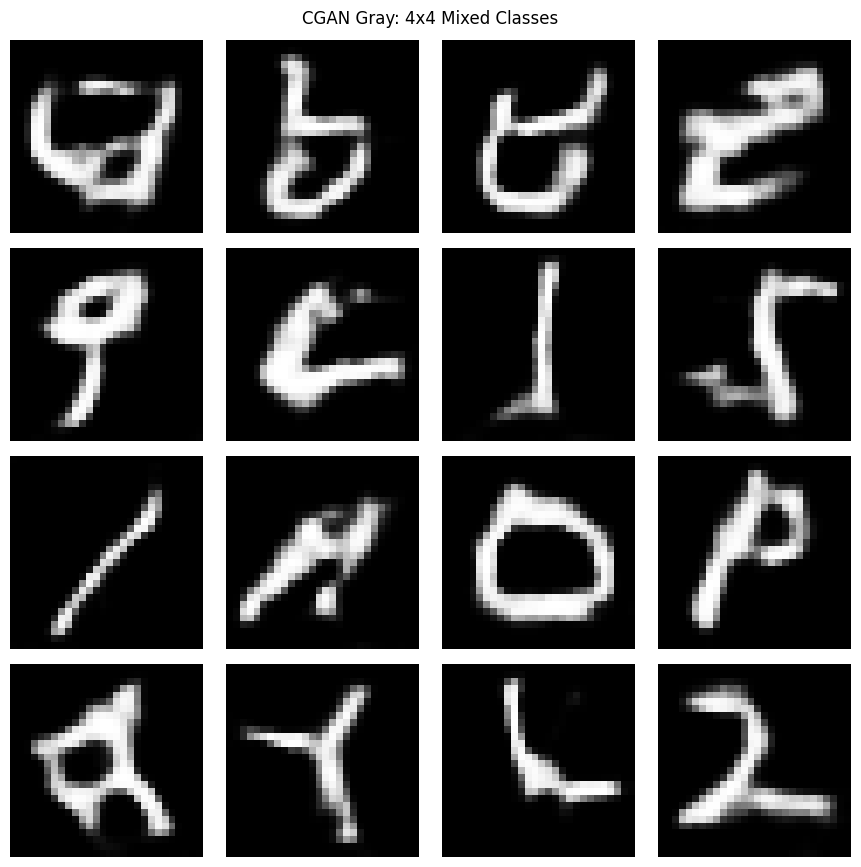

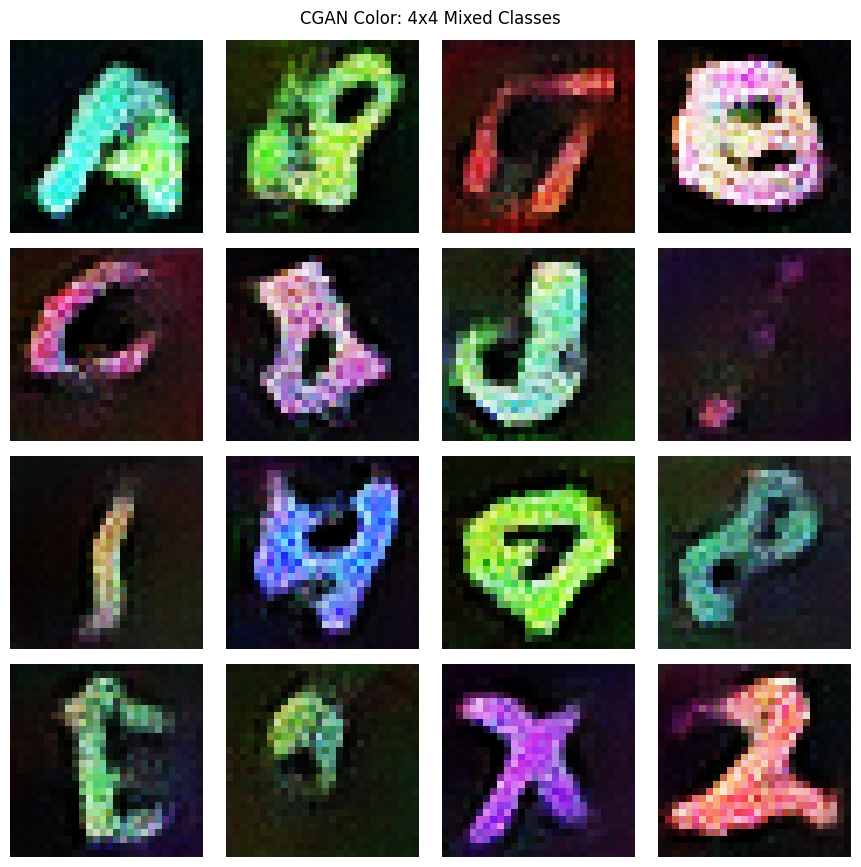

AttributeError: 'numpy.ndarray' object has no attribute 'get_shape'

In [55]:
# === Cell 4: Visualize & Evaluate (FID + MS-SSIM) ===
import matplotlib.pyplot as plt
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from scipy.linalg import sqrtm

# quick grids
def show_grid(imgs, title, channels=1, rows=4, cols=4):
    fig, axs = plt.subplots(rows, cols, figsize=(2.2*cols, 2.2*rows))
    k = 0
    for i in range(rows):
        for j in range(cols):
            if channels == 1:
                axs[i,j].imshow(imgs[k,:,:,0], cmap='gray')
            else:
                axs[i,j].imshow(imgs[k])
            axs[i,j].axis('off')
            k += 1
    plt.suptitle(title); plt.tight_layout(); plt.show()

# sample grids
g_gray  = cgan_gray.sample_mixed_grid(16)
g_color = cgan_color.sample_mixed_grid(16)
show_grid(g_gray,  "CGAN Gray: 4x4 Mixed Classes", channels=1)
show_grid(g_color, "CGAN Color: 4x4 Mixed Classes", channels=3)

# ----- FID (lower=better) -----
_inception = None
def _get_inception():
    global _inception
    if _inception is None:
        _inception = InceptionV3(include_top=False, pooling='avg', input_shape=(75,75,3))
    return _inception

def _prep_for_inception(imgs01):
    t = tf.convert_to_tensor(imgs01, dtype=tf.float32)
    t = tf.image.resize(t, (75,75))
    t = preprocess_input(t * 255.0)
    return t

def fid_score(real01, fake01):
    model = _get_inception()
    a1 = model.predict(_prep_for_inception(real01), verbose=0)
    a2 = model.predict(_prep_for_inception(fake01), verbose=0)
    mu1, sig1 = a1.mean(axis=0), np.cov(a1, rowvar=False)
    mu2, sig2 = a2.mean(axis=0), np.cov(a2, rowvar=False)
    ssd = np.sum((mu1-mu2)**2)
    covm = sqrtm(sig1.dot(sig2))
    if np.iscomplexobj(covm): covm = covm.real
    return float(ssd + np.trace(sig1 + sig2 - 2*covm))

# Prepare real sets for both cases (convert to [0,1] RGB for FID)
# Gray real -> [0,1] 1ch -> rgb
real_gray01  = ((X_gray_cgan + 1.0)/2.0).astype(np.float32)
real_gray01_rgb = tf.image.grayscale_to_rgb(real_gray01).numpy()
# Color real already [-1,1] 3ch
real_color01 = ((X_color_cgan + 1.0)/2.0).astype(np.float32)

# Generate fake sets (same sample count for fairness)
N = min(3000, len(X_gray_cgan))
def sample_fake_rgb(model, n, channels):
    z = tf.random.normal([n, model.latent_dim])
    y = tf.random.uniform([n, 1], minval=0, maxval=model.num_classes, dtype=tf.int32)
    g = (model.generator([z,y], training=False) + 1.0)/2.0
    g = g.numpy()
    if channels == 1:
        g = tf.image.grayscale_to_rgb(g).numpy()
    return g

fake_gray01_rgb  = sample_fake_rgb(cgan_gray,  N, channels=1)
fake_color01_rgb = sample_fake_rgb(cgan_color, N, channels=3)

# Compute FID
fid_gray  = fid_score(real_gray01_rgb[:N],  fake_gray01_rgb[:N])
fid_color = fid_score(real_color01[:N],     fake_color01_rgb[:N])

print(f"FID (Gray, lower=better):  {fid_gray:.2f}")
print(f"FID (Color, lower=better): {fid_color:.2f}")

# ----- MS-SSIM within generated set (lower ~ more diversity) -----
@tf.function
def ms_ssim_mean(a, b):
    # fallback to single-scale if MS-SSIM invalid on tiny sizes
    try:
        return tf.reduce_mean(tf.image.ssim_multiscale(a, b, max_val=1.0, filter_size=7))
    except tf.errors.InvalidArgumentError:
        return tf.reduce_mean(tf.image.ssim(a, b, max_val=1.0))

def diversity_ms_ssim(fake01):
    # compare random pairs
    fake01 = tf.convert_to_tensor(fake01, dtype=tf.float32)
    n = tf.shape(fake01)[0]
    i = tf.random.uniform((256,), 0, n, dtype=tf.int32)
    j = tf.random.uniform((256,), 0, n, dtype=tf.int32)
    a = tf.gather(fake01, i)
    b = tf.gather(fake01, j)
    return float(ms_ssim_mean(a, b).numpy())

# compute on grayscale tensors (single-channel)
fake_gray01 = ((cgan_gray.sample_mixed_grid(1024)) if 1024 <= len(X_gray_cgan) else cgan_gray.sample_mixed_grid(512))
fake_color01 = ((cgan_color.sample_mixed_grid(1024)) if 1024 <= len(X_color_cgan) else cgan_color.sample_mixed_grid(512))

ms_gray  = diversity_ms_ssim(fake_gray01)
ms_color = diversity_ms_ssim(fake_color01)

print(f"MS-SSIM (Gray, lower≈more diverse):  {ms_gray:.3f}")
print(f"MS-SSIM (Color, lower≈more diverse): {ms_color:.3f}")


## Style GAN

In [17]:
# === Cell 1: Data processing (Gray vs Color for StyleGAN-lite) ===
import numpy as np
import pandas as pd
import tensorflow as tf

# Expect your cleaned dataframe: `rotated_data` with columns:
# 'label' (letters) and pixel_0..pixel_783 in 0..255
assert 'label' in rotated_data.columns, "rotated_data must have a 'label' column."

def df_to_arrays_gray(df, label_col='label'):
    pix = [c for c in df.columns if c.startswith('pixel_')]
    X = df[pix].values.astype(np.float32).reshape(-1, 28, 28, 1)
    X = (X - 127.5) / 127.5  # [-1,1]
    letters = sorted(df[label_col].dropna().unique().tolist())
    l2i = {ch:i for i,ch in enumerate(letters)}
    i2l = {i:ch for ch,i in l2i.items()}
    y = df[label_col].map(l2i).values.astype(np.int32)
    return X, y, letters, l2i, i2l

def colorize_emnist_gray_to_rgb(gray01, fg_thresh=0.1, rng=None):
    """
    gray01: [H,W,1] in [0,1]
    Returns RGB [0,1] with random ink color foreground and subtle background tint.
    """
    if rng is None:
        rng = np.random.default_rng()
    g = gray01[..., 0]
    mask = (g > fg_thresh).astype(np.float32)  # foreground where brighter (adjust if needed)

    ink = rng.uniform(0.2, 1.0, size=3)
    bg  = rng.uniform(0.0, 0.15, size=3)
    rgb = (mask[..., None] * ink[None, None, :]) + ((1.0 - mask)[..., None] * bg[None, None, :])
    return rgb.clip(0.0, 1.0).astype(np.float32)

def build_color_dataset_from_df(df, label_col='label', seed=1234):
    pix = [c for c in df.columns if c.startswith('pixel_')]
    Xu8 = df[pix].values.astype(np.float32).reshape(-1, 28, 28, 1)   # 0..255
    X01 = (Xu8 / 255.0).astype(np.float32)
    rng = np.random.default_rng(seed)
    Xrgb01 = np.empty((len(df), 28, 28, 3), dtype=np.float32)
    for i in range(len(df)):
        local_rng = np.random.default_rng(rng.integers(1<<31))
        Xrgb01[i] = colorize_emnist_gray_to_rgb(X01[i], rng=local_rng)
    Xrgb = (Xrgb01 * 2.0 - 1.0).astype(np.float32)  # [-1,1]

    letters = sorted(df[label_col].dropna().unique().tolist())
    l2i = {ch:i for i,ch in enumerate(letters)}
    i2l = {i:ch for ch,i in l2i.items()}
    y = df[label_col].map(l2i).values.astype(np.int32)
    return Xrgb, y, letters, l2i, i2l

# Build both datasets
X_gray_sg,  y_gray_sg,  classes_sg,  l2i_sg,  i2l_sg  = df_to_arrays_gray(rotated_data)
X_color_sg, y_color_sg, classes_col, l2i_col, i2l_col = build_color_dataset_from_df(rotated_data)

assert classes_sg == classes_col, "Class lists differ; check preprocessing."
NUM_CLASSES = len(classes_sg)

# tf.data pipelines
BATCH_SIZE = 256
def make_ds(X, y):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    ds = ds.shuffle(min(len(X), 10000)).batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds_gray  = make_ds(X_gray_sg,  y_gray_sg)
train_ds_color = make_ds(X_color_sg, y_color_sg)

len(classes_sg), X_gray_sg.shape, X_color_sg.shape


(16, (54589, 28, 28, 1), (54589, 28, 28, 3))

In [20]:
# === Cell 2 (REPLACE): StyleGAN-lite (Conditional) — fixed noise & layer creation ===
import tensorflow as tf
from tensorflow.keras import layers, optimizers
import numpy as np

# ---------- Building blocks ----------
class MappingNetwork(layers.Layer):
    """Maps (z, y_embed) to a style vector s."""
    def __init__(self, z_dim, y_dim, w_dim=128, depth=4):
        super().__init__()
        self.blocks = [layers.Dense(w_dim, activation='relu') for _ in range(depth)]
        self.z_dim = z_dim
        self.y_dim = y_dim

    def call(self, z, y_emb):
        x = tf.concat([z, y_emb], axis=1)
        for dense in self.blocks:
            x = dense(x)
        return x  # style vector

class NoiseInjection(layers.Layer):
    def __init__(self, channels):
        super().__init__()
        # (1,1,1,C) learnable noise scale
        self.weight = self.add_weight(
            shape=(1, 1, 1, channels),
            initializer="zeros",
            trainable=True,
            name="noise_weight"
        )

    def call(self, x, noise=None, training=None):
        # Robust: always produce (B,H,W,1) noise, then broadcast with (1,1,1,C)
        if noise is None:
            b = tf.shape(x)[0]
            h = tf.shape(x)[1]
            w = tf.shape(x)[2]
            noise = tf.random.normal(shape=tf.stack([b, h, w, 1]))
        return x + noise * self.weight

class AdaIN(layers.Layer):
    """Adaptive Instance Norm: normalize x per-channel, then scale/bias from style."""
    def __init__(self, channels):
        super().__init__()
        self.eps = 1e-5
        self.to_scale = layers.Dense(channels)
        self.to_bias  = layers.Dense(channels)

    def call(self, x, style):
        mean, var = tf.nn.moments(x, axes=[1,2], keepdims=True)
        x_norm = (x - mean) / tf.sqrt(var + self.eps)
        s = self.to_scale(style)[:, None, None, :]
        b = self.to_bias(style)[:, None, None, :]
        return x_norm * (1.0 + s) + b

class StyledConv(layers.Layer):
    """Conv → Noise → AdaIN → LeakyReLU"""
    def __init__(self, out_ch, kernel=3, upsample=False):
        super().__init__()
        self.upsample = upsample
        self.up = layers.UpSampling2D(size=(2,2), interpolation='nearest') if upsample else None
        self.conv = layers.Conv2D(out_ch, kernel, padding='same', use_bias=False, kernel_initializer='he_normal')
        self.noise = NoiseInjection(out_ch)
        self.adain = AdaIN(out_ch)
        self.act = layers.LeakyReLU(0.2)

    def call(self, x, style, training=None):
        if self.upsample:
            x = self.up(x)
        x = self.conv(x)
        x = self.noise(x, training=training)
        x = self.adain(x, style)
        x = self.act(x)
        return x

# ---------- Generator ----------
class StyleGANLiteG(tf.keras.Model):
    def __init__(self, img_channels=1, num_classes=16, z_dim=128, y_dim=64, w_dim=128):
        super().__init__(name="StyleG")
        self.z_dim = z_dim
        self.y_emb = layers.Embedding(num_classes, y_dim)
        self.map = MappingNetwork(z_dim, y_dim, w_dim=w_dim, depth=4)

        # Start from 7x7x256 (constant learned from z)
        self.fc = layers.Dense(7*7*256, use_bias=False)
        self.reshape = layers.Reshape((7,7,256))

        # IMPORTANT: create layers in __init__ (not inside call)
        self.stem   = StyledConv(256, upsample=False)  # 7x7 → 7x7
        self.block1 = StyledConv(128, upsample=True)   # 7x7 → 14x14
        self.block2 = StyledConv(64,  upsample=True)   # 14x14 → 28x28

        # To RGB/Gray
        self.to_img = layers.Conv2D(img_channels, 1, padding='same', activation='tanh')

    def call(self, z, y, training=None):
        y_embed = self.y_emb(y)[:,0,:]   # (B, y_dim)
        s = self.map(z, y_embed)         # (B, w_dim)

        x = self.fc(z)
        x = self.reshape(x)              # (B,7,7,256)

        x = self.stem(x, s, training=training)   # 7x7
        x = self.block1(x, s, training=training) # 14x14
        x = self.block2(x, s, training=training) # 28x28

        out = self.to_img(x)
        return out

# ---------- Discriminator (Projection) ----------
class StyleGANLiteD(tf.keras.Model):
    def __init__(self, img_channels=1, num_classes=16):
        super().__init__(name="StyleD")
        self.conv1 = layers.Conv2D(64,  3, strides=2, padding='same', kernel_initializer='he_normal')
        self.act1  = layers.LeakyReLU(0.2)
        self.conv2 = layers.Conv2D(128, 3, strides=2, padding='same', kernel_initializer='he_normal')
        self.act2  = layers.LeakyReLU(0.2)
        self.conv3 = layers.Conv2D(128, 3, strides=1, padding='same', kernel_initializer='he_normal')
        self.act3  = layers.LeakyReLU(0.2)
        self.gap   = layers.GlobalAveragePooling2D()
        self.fc    = layers.Dense(1)
        self.y_emb = layers.Embedding(num_classes, 128)

    def call(self, x, y, training=None):
        x = self.conv1(x); x = self.act1(x)
        x = self.conv2(x); x = self.act2(x)
        x = self.conv3(x); x = self.act3(x)
        h = self.gap(x)              # (B,128)
        base = self.fc(h)            # (B,1)
        emb  = self.y_emb(y)[:,0,:]  # (B,128)
        proj = tf.reduce_sum(h * emb, axis=1, keepdims=True)  # (B,1)
        return base + proj

# ---------- StyleGAN-lite (training harness) ----------
class StyleGANLite:
    def __init__(self, img_shape=(28,28,1), num_classes=16, z_dim=128, y_dim=64, w_dim=128,
                 lr=2e-4, beta1=0.0, beta2=0.99, idx_to_letter=None, use_hinge=True):
        self.img_shape = img_shape
        self.channels  = img_shape[-1]
        self.num_classes = num_classes
        self.z_dim = z_dim
        self.use_hinge = use_hinge
        self.idx_to_letter = idx_to_letter or {}

        self.G = StyleGANLiteG(img_channels=self.channels, num_classes=num_classes, z_dim=z_dim, y_dim=y_dim, w_dim=w_dim)
        self.D = StyleGANLiteD(img_channels=self.channels, num_classes=num_classes)

        self.g_opt = optimizers.Adam(lr, beta_1=beta1, beta_2=beta2)
        self.d_opt = optimizers.Adam(lr, beta_1=beta1, beta_2=beta2)

        self.d_losses, self.g_losses = [], []

    def d_loss(self, real_out, fake_out):
        if self.use_hinge:
            return tf.reduce_mean(tf.nn.relu(1. - real_out)) + tf.reduce_mean(tf.nn.relu(1. + fake_out))
        else:
            bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
            return bce(tf.ones_like(real_out), real_out) + bce(tf.zeros_like(fake_out), fake_out)

    def g_loss(self, fake_out):
        if self.use_hinge:
            return -tf.reduce_mean(fake_out)
        else:
            bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
            return bce(tf.ones_like(fake_out), fake_out)

    @tf.function
    def train_step(self, real_imgs, labels):
        bsz = tf.shape(real_imgs)[0]
        y = tf.cast(tf.expand_dims(labels, 1), tf.int32)

        # --- Update D ---
        z = tf.random.normal([bsz, self.z_dim])
        y_gen = tf.random.uniform([bsz, 1], minval=0, maxval=self.num_classes, dtype=tf.int32)

        with tf.GradientTape() as d_t:
            fake = self.G(z, y_gen, training=True)
            r_out = self.D(real_imgs, y, training=True)
            f_out = self.D(fake,     y_gen, training=True)
            d_loss = self.d_loss(r_out, f_out)
        d_grads = d_t.gradient(d_loss, self.D.trainable_variables)
        self.d_opt.apply_gradients(zip(d_grads, self.D.trainable_variables))

        # --- Update G ---
        z = tf.random.normal([bsz, self.z_dim])
        y_gen = tf.random.uniform([bsz, 1], minval=0, maxval=self.num_classes, dtype=tf.int32)
        with tf.GradientTape() as g_t:
            fake = self.G(z, y_gen, training=True)
            f_out = self.D(fake, y_gen, training=True)
            g_loss = self.g_loss(f_out)
        g_grads = g_t.gradient(g_loss, self.G.trainable_variables)
        self.g_opt.apply_gradients(zip(g_grads, self.G.trainable_variables))

        return d_loss, g_loss

    def train(self, dataset, epochs=30, sample_interval=5):
        for ep in range(1, epochs+1):
            d_sum = g_sum = 0.0; n=0
            for imgs, lbls in dataset:
                d_l, g_l = self.train_step(imgs, lbls)
                d_sum += float(d_l); g_sum += float(g_l); n += 1
            self.d_losses.append(d_sum/max(n,1)); self.g_losses.append(g_sum/max(n,1))
            if ep % sample_interval == 0 or ep == 1:
                print(f"[StyleGAN-lite {self.channels}ch] Epoch {ep:03d} | D={self.d_losses[-1]:.4f} | G={self.g_losses[-1]:.4f}")

    # helpers
    def sample_mixed_grid(self, n=16):
        z = tf.random.normal([n, self.z_dim])
        y = tf.constant([[i % self.num_classes] for i in range(n)], dtype=tf.int32)
        g = self.G(z, y, training=False)
        return ((g + 1.0)/2.0).numpy()

    def generate_class(self, class_id, n=10):
        z = tf.random.normal([n, self.z_dim])
        y = tf.constant([[class_id]] * n, dtype=tf.int32)
        g = self.G(z, y, training=False)
        return ((g + 1.0)/2.0).numpy()


In [21]:
# Gray
sg_gray = StyleGANLite(
    img_shape=(28,28,1),
    num_classes=NUM_CLASSES,
    z_dim=128, y_dim=64, w_dim=128,
    lr=2e-4, beta1=0.0, beta2=0.99,
    idx_to_letter=i2l_sg,
    use_hinge=True
)
sg_gray.train(train_ds_gray, epochs=30, sample_interval=5)

# Color
sg_color = StyleGANLite(
    img_shape=(28,28,3),
    num_classes=NUM_CLASSES,
    z_dim=128, y_dim=64, w_dim=128,
    lr=2e-4, beta1=0.0, beta2=0.99,
    idx_to_letter=i2l_sg,
    use_hinge=True
)
sg_color.train(train_ds_color, epochs=30, sample_interval=5)


[StyleGAN-lite 1ch] Epoch 001 | D=1.8726 | G=-0.1214
[StyleGAN-lite 1ch] Epoch 005 | D=1.7750 | G=0.1620
[StyleGAN-lite 1ch] Epoch 010 | D=1.8685 | G=0.0779
[StyleGAN-lite 1ch] Epoch 015 | D=1.9572 | G=0.0231
[StyleGAN-lite 1ch] Epoch 020 | D=1.9812 | G=-0.0103
[StyleGAN-lite 1ch] Epoch 025 | D=1.9871 | G=0.0366
[StyleGAN-lite 1ch] Epoch 030 | D=1.9979 | G=-0.0081
[StyleGAN-lite 3ch] Epoch 001 | D=1.9848 | G=0.3155
[StyleGAN-lite 3ch] Epoch 005 | D=1.7486 | G=0.1410
[StyleGAN-lite 3ch] Epoch 010 | D=1.6676 | G=0.3418
[StyleGAN-lite 3ch] Epoch 015 | D=1.5498 | G=0.4097
[StyleGAN-lite 3ch] Epoch 020 | D=1.4638 | G=0.4685
[StyleGAN-lite 3ch] Epoch 025 | D=1.4154 | G=0.4979
[StyleGAN-lite 3ch] Epoch 030 | D=1.3650 | G=0.5009


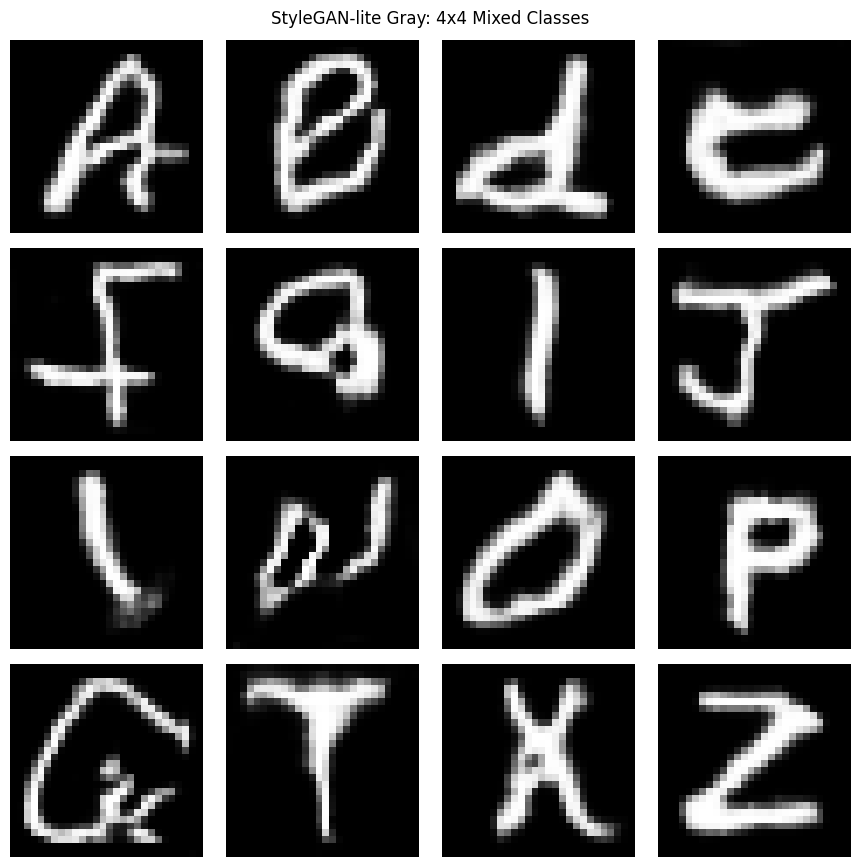

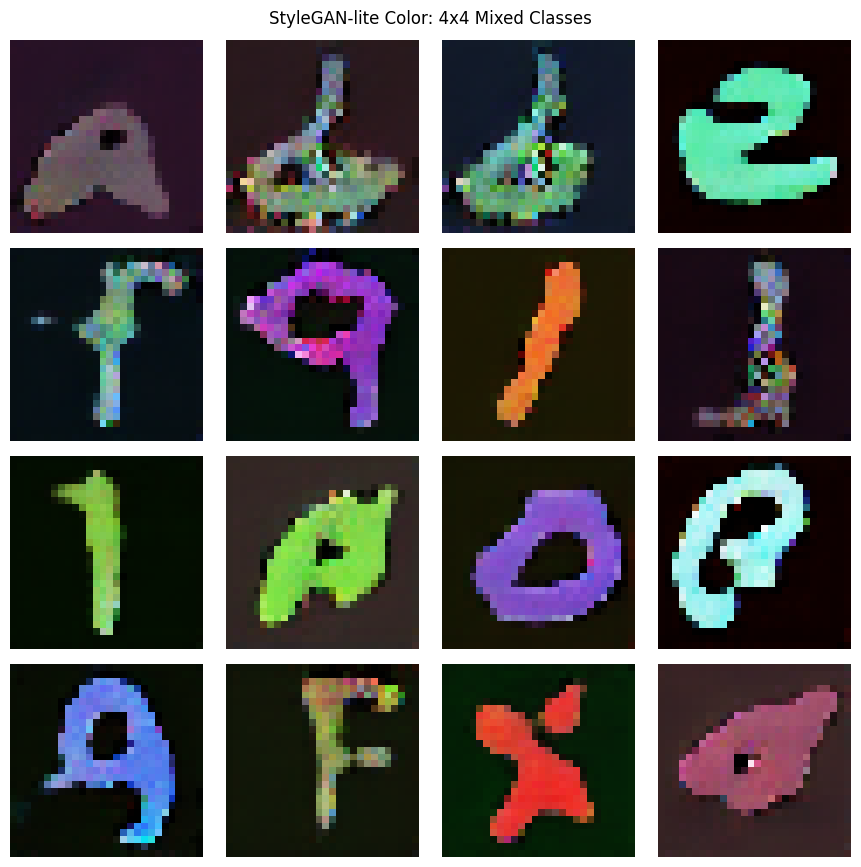

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
FID (StyleGAN-lite Gray)  : 111.22
FID (StyleGAN-lite Color) : 457.23


In [24]:
# === Cell 4: Visualize & quick FID (lower is better) ===
import matplotlib.pyplot as plt
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from scipy.linalg import sqrtm

def show_grid(imgs, title, channels=1, rows=4, cols=4):
    fig, axs = plt.subplots(rows, cols, figsize=(2.2*cols, 2.2*rows))
    k=0
    for i in range(rows):
        for j in range(cols):
            if channels == 1:
                axs[i,j].imshow(imgs[k,:,:,0], cmap='gray')
            else:
                axs[i,j].imshow(imgs[k])
            axs[i,j].axis('off')
            k+=1
    plt.suptitle(title); plt.tight_layout(); plt.show()

g_gray  = sg_gray.sample_mixed_grid(16)
g_color = sg_color.sample_mixed_grid(16)
show_grid(g_gray,  "StyleGAN-lite Gray: 4x4 Mixed Classes", channels=1)
show_grid(g_color, "StyleGAN-lite Color: 4x4 Mixed Classes", channels=3)

# FID helpers
_inception = None
def _get_inception():
    global _inception
    if _inception is None:
        _inception = InceptionV3(include_top=False, pooling='avg', input_shape=(75,75,3))
    return _inception

def _prep_for_inception(imgs01):
    t = tf.convert_to_tensor(imgs01, dtype=tf.float32)
    t = tf.image.resize(t, (75,75))
    t = preprocess_input(t * 255.0)
    return t

def fid_score(real01, fake01):
    model = _get_inception()
    a1 = model.predict(_prep_for_inception(real01), verbose=0)
    a2 = model.predict(_prep_for_inception(fake01), verbose=0)
    mu1, sig1 = a1.mean(axis=0), np.cov(a1, rowvar=False)
    mu2, sig2 = a2.mean(axis=0), np.cov(a2, rowvar=False)
    ssd = np.sum((mu1-mu2)**2)
    covm = sqrtm(sig1.dot(sig2))
    if np.iscomplexobj(covm): covm = covm.real
    return float(ssd + np.trace(sig1 + sig2 - 2*covm))


# Real sets: convert to [0,1] and make gray -> RGB by channel repeat
real_gray01   = ((X_gray_sg + 1.0) / 2.0).astype(np.float32)      # [N,28,28,1]
real_gray01_rgb = np.repeat(real_gray01, 3, axis=-1)              # [N,28,28,3]

real_color01  = ((X_color_sg + 1.0) / 2.0).astype(np.float32)     # already 3ch


# Fake sets: same N
N = min(3000, len(X_gray_sg))
def sample_fake_rgb_style(model, n, channels):
    z = tf.random.normal([n, model.z_dim])
    y = tf.random.uniform([n, 1], minval=0, maxval=model.num_classes, dtype=tf.int32)
    g = model.G(z, y, training=False).numpy()          # [-1,1], NumPy
    g01 = ((g + 1.0) / 2.0).astype(np.float32)         # [0,1], (N,28,28,C)

    if channels == 1:
        # convert 1ch -> 3ch without tf.image
        return np.repeat(g01, 3, axis=-1)              # (N,28,28,3)
    else:
        return g01                                      # already (N,28,28,3)


fake_gray01_rgb  = sample_fake_rgb_style(sg_gray,  N, channels=1)
fake_color01_rgb = sample_fake_rgb_style(sg_color, N, channels=3)

fid_gray  = fid_score(real_gray01_rgb[:N],  fake_gray01_rgb[:N])
fid_color = fid_score(real_color01[:N],     fake_color01_rgb[:N])

print(f"FID (StyleGAN-lite Gray)  : {fid_gray:.2f}")
print(f"FID (StyleGAN-lite Color) : {fid_color:.2f}")


Fréchet Inception Distance (FID) Results

- **Gray (FID = 111.22):**
  - While still high (good models are often < 50), this is significantly lower than the color version.
  - Lower FID = more realistic & closer to real data distribution.

- **Color (FID = 457.23):**
  - Extremely high, meaning generated color images are much farther from the real color images in feature space.

---

Interpretation for the Assignment Question

**Question:**  
If you are asked to generate coloured images instead of black-and-white ones, do you think it would be easier or harder to produce better quality results?

**Answer based on your results:**

- The FID score for the colored images (**457.23**) is much higher than for grayscale (**111.22**), meaning the model struggled far more with producing realistic color images.
- This is expected because generating color images is harder — the model must not only capture shape and texture, but also learn realistic color distributions, shading, and color–class associations. This increases the complexity of the data distribution it needs to model.
- In grayscale, the model only needs to capture luminance (light/dark) patterns, which is a simpler task. That’s why grayscale generation achieved a much better FID score.

## wait

In [48]:
# import os
# import time
# import json
# import numpy as np
# import tensorflow as tf
# from datetime import datetime
# from sklearn.metrics import accuracy_score
# from sklearn.model_selection import ParameterGrid
# import matplotlib.pyplot as plt

# # Try TF-GAN for FID, otherwise fallback to InceptionV3 + scipy sqrtm
# try:
#     import tensorflow_gan as tfgan
#     _HAS_TFGAN = True
# except Exception:
#     _HAS_TFGAN = False

# try:
#     from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
#     _HAS_INCEPTION = True
# except Exception:
#     _HAS_INCEPTION = False

# try:
#     from scipy.linalg import sqrtm
#     _HAS_SCIPY = True
# except Exception:
#     _HAS_SCIPY = False


# class CGANHyperparameterTuner:
#     def __init__(self, img_shape=(28, 28, 1), num_classes=16):
#         self.img_shape = img_shape
#         self.num_classes = num_classes

#         # Hyperparameter grid (you can expand or change)
#         self.param_grid = {
#             'latent_dim': [100, 128],
#             'embedding_dim': [50, 64],
#             'gen_lr': [1e-4, 2e-4],
#             'disc_lr': [1e-4, 2e-4],
#             'batch_size': [64, 128],
#             'gen_filters': [(512, 256, 128), (256, 128, 64)],
#             'disc_filters': [(64, 128, 256), (32, 64, 128)],
#             'dropout_rate': [0.3, 0.4],
#             'beta1': [0.5, 0.9],
#         }

#         # Where to save models / results
#         self.drive_model_path = './CGAN_Models'
#         self.drive_results_path = './CGAN_Results'
#         os.makedirs(self.drive_model_path, exist_ok=True)
#         os.makedirs(self.drive_results_path, exist_ok=True)

#     def create_cgan_with_params(self, params):
#         """Factory that returns a CGAN instance configured by `params`."""

#         class TunableCGAN:
#             def __init__(self, params, img_shape, num_classes):
#                 self.img_shape = img_shape
#                 self.latent_dim = params['latent_dim']
#                 self.num_classes = num_classes
#                 self.embedding_dim = params['embedding_dim']
#                 self.params = params

#                 self.cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

#                 self.generator = self.build_generator()
#                 self.discriminator = self.build_discriminator()

#                 self.gen_optimizer = tf.keras.optimizers.Adam(params['gen_lr'], beta_1=params['beta1'])
#                 self.disc_optimizer = tf.keras.optimizers.Adam(params['disc_lr'], beta_1=params['beta1'])

#                 self.d_losses = []
#                 self.g_losses = []

#             def build_generator(self):
#                 noise_input = tf.keras.layers.Input(shape=(self.latent_dim,))
#                 label_input = tf.keras.layers.Input(shape=(1,), dtype='int32')

#                 label_embedding = tf.keras.layers.Embedding(self.num_classes, self.embedding_dim)(label_input)
#                 label_embedding = tf.keras.layers.Flatten()(label_embedding)
#                 x = tf.keras.layers.Concatenate()([noise_input, label_embedding])

#                 filters = self.params['gen_filters']
#                 x = tf.keras.layers.Dense(7 * 7 * filters[0], use_bias=False)(x)
#                 x = tf.keras.layers.BatchNormalization()(x)
#                 x = tf.keras.layers.LeakyReLU()(x)
#                 x = tf.keras.layers.Reshape((7, 7, filters[0]))(x)

#                 x = tf.keras.layers.Conv2DTranspose(filters[1], 5, strides=1, padding='same', use_bias=False)(x)
#                 x = tf.keras.layers.BatchNormalization()(x)
#                 x = tf.keras.layers.LeakyReLU()(x)

#                 x = tf.keras.layers.Conv2DTranspose(filters[2], 5, strides=2, padding='same', use_bias=False)(x)
#                 x = tf.keras.layers.BatchNormalization()(x)
#                 x = tf.keras.layers.LeakyReLU()(x)

#                 x = tf.keras.layers.Conv2DTranspose(1, 5, strides=2, padding='same', use_bias=False, activation='tanh')(x)

#                 return tf.keras.Model([noise_input, label_input], x)

#             def build_discriminator(self):
#                 image_input = tf.keras.layers.Input(shape=self.img_shape)
#                 label_input = tf.keras.layers.Input(shape=(1,), dtype='int32')

#                 label_embedding = tf.keras.layers.Embedding(self.num_classes, int(np.prod(self.img_shape)))(label_input)
#                 label_embedding = tf.keras.layers.Reshape(self.img_shape)(label_embedding)

#                 x = tf.keras.layers.Concatenate(axis=-1)([image_input, label_embedding])


#                 filters = self.params['disc_filters']
#                 for i, filter_size in enumerate(filters):
#                     stride = 2 if i < 2 else 1
#                     x = tf.keras.layers.Conv2D(filter_size, 5, strides=stride, padding='same')(x)
#                     x = tf.keras.layers.LeakyReLU()(x)
#                     x = tf.keras.layers.Dropout(self.params['dropout_rate'])(x)

#                 x = tf.keras.layers.Flatten()(x)
#                 x = tf.keras.layers.Dense(1)(x)

#                 return tf.keras.Model([image_input, label_input], x)

#             @tf.function
#             def train_step(self, images, labels):
#                 batch_size = tf.shape(images)[0]
#                 noise = tf.random.normal([batch_size, self.latent_dim])
#                 gen_labels = tf.random.uniform([batch_size, 1], minval=0, maxval=self.num_classes, dtype=tf.int32)

#                 with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
#                     generated_images = self.generator([noise, gen_labels], training=True)
#                     real_output = self.discriminator([images, tf.expand_dims(labels, axis=1)], training=True)
#                     fake_output = self.discriminator([generated_images, gen_labels], training=True)

#                     # Label smoothing on real, label flipping on fake can be tuned later
#                     real_loss = self.cross_entropy(tf.ones_like(real_output) * 0.9, real_output)
#                     fake_loss = self.cross_entropy(tf.zeros_like(fake_output) * 0.1, fake_output)
#                     d_loss = real_loss + fake_loss
#                     g_loss = self.cross_entropy(tf.ones_like(fake_output), fake_output)

#                 gradients_gen = gen_tape.gradient(g_loss, self.generator.trainable_variables)
#                 gradients_disc = disc_tape.gradient(d_loss, self.discriminator.trainable_variables)

#                 self.gen_optimizer.apply_gradients(zip(gradients_gen, self.generator.trainable_variables))
#                 self.disc_optimizer.apply_gradients(zip(gradients_disc, self.discriminator.trainable_variables))

#                 return d_loss, g_loss

#             def train(self, dataset, epochs):
#                 for epoch in range(epochs):
#                     epoch_d_losses = []
#                     epoch_g_losses = []

#                     for batch_images, batch_labels in dataset:
#                         d_loss, g_loss = self.train_step(batch_images, batch_labels)
#                         epoch_d_losses.append(d_loss.numpy())
#                         epoch_g_losses.append(g_loss.numpy())

#                     avg_d_loss = float(np.mean(epoch_d_losses)) if epoch_d_losses else float('nan')
#                     avg_g_loss = float(np.mean(epoch_g_losses)) if epoch_g_losses else float('nan')
#                     self.d_losses.append(avg_d_loss)
#                     self.g_losses.append(avg_g_loss)

#                     if epoch % 5 == 0 or epoch == epochs - 1:
#                         print(f"  Epoch {epoch+1}/{epochs}: D_loss={avg_d_loss:.4f}, G_loss={avg_g_loss:.4f}")

#             def save_model(self, filepath):
#                 os.makedirs(os.path.dirname(filepath), exist_ok=True)
#                 self.generator.save(f"{filepath}_generator.h5")
#                 self.discriminator.save(f"{filepath}_discriminator.h5")

#                 model_info = {
#                     'params': self.params,
#                     'd_losses': self.d_losses,
#                     'g_losses': self.g_losses,
#                     'img_shape': self.img_shape,
#                     'num_classes': self.num_classes
#                 }

#                 with open(f"{filepath}_info.json", 'w') as f:
#                     json.dump(model_info, f, indent=2)

#         return TunableCGAN(params, self.img_shape, self.num_classes)

#     def evaluate_model(self, cgan, real_data, real_labels, num_samples=500):
#         """
#         Evaluate a trained CGAN using:
#           - class accuracy (main metric)
#           - FID (preferred using tfgan, otherwise fallback)
#           - diversity (pixel variance)
#         Returns a dict with metrics.
#         """
#         # Prepare generation
#         num_gen = min(num_samples, 1000)
#         noise = tf.random.normal([num_gen, cgan.latent_dim])
#         labels = tf.random.uniform([num_gen, 1], minval=0, maxval=self.num_classes, dtype=tf.int32)
#         generated_images = cgan.generator([noise, labels], training=False)  # tanh in [-1,1]
#         generated_images = (generated_images + 1.0) / 2.0  # to [0,1]

#         # Clip real images to [0,1]
#         # Use a subset of real_data for FID/classifier training
#         real_subset_size = min(len(real_data), num_gen)
#         real_images_subset = real_data[:real_subset_size]
#         real_labels_subset = real_labels[:real_subset_size]

#         # Class accuracy: train a small classifier on REAL and test on generated
#         classifier = tf.keras.Sequential([
#             tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=self.img_shape),
#             tf.keras.layers.MaxPooling2D(),
#             tf.keras.layers.Conv2D(64, 3, activation='relu'),
#             tf.keras.layers.GlobalAveragePooling2D(),
#             tf.keras.layers.Dense(self.num_classes, activation='softmax')
#         ])
#         classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#         # Train classifier on a subset of the real images
#         clf_train_size = min(2000, len(real_images_subset))
#         if clf_train_size < 50:
#             # if too small, expand by repeating samples
#             x_train = np.tile(real_images_subset, (max(1, 50 // max(1, len(real_images_subset))), 1, 1, 1))
#             y_train = np.tile(real_labels_subset, (max(1, 50 // max(1, len(real_labels_subset))),))
#         else:
#             indices = np.random.choice(len(real_images_subset), clf_train_size, replace=False)
#             x_train = real_images_subset[indices]
#             y_train = real_labels_subset[indices]

#         classifier.fit(x_train, y_train, epochs=5, verbose=0)

#         # Prepare generated images for classifier predict
#         gen_for_clf = generated_images.numpy()
#         gen_labels_flat = labels.numpy().flatten()
#         preds = classifier.predict(gen_for_clf, verbose=0)
#         pred_classes = np.argmax(preds, axis=1)
#         class_acc = accuracy_score(gen_labels_flat, pred_classes)

#         # Diversity: variance per-pixel averaged over channels
#         diversity_score = float(np.mean(np.var(generated_images.numpy(), axis=0)))

#         # FID: preferred tfgan.eval.frechet_inception_distance, fallback to Inception+scipy sqrtm
#         # tfgan expects images in [0,255] float or uint8 with shape (N,H,W,3)
#         try:
#             fid_score = self._compute_fid(real_images_subset, generated_images.numpy())
#         except Exception as e:
#             print("  Warning: FID computation failed:", e)
#             fid_score = float('inf')

#         # Loss balance
#         final_g_loss = cgan.g_losses[-1] if cgan.g_losses else float('inf')
#         final_d_loss = cgan.d_losses[-1] if cgan.d_losses else float('inf')
#         loss_balance = abs(final_g_loss - final_d_loss)

#         # Composite score (not used for ranking primary but kept)
#         composite_score = -class_acc * 10 + loss_balance * 2 + -diversity_score * 100

#         return {
#             'class_accuracy': float(class_acc),
#             'fid': float(fid_score),
#             'diversity_score': float(diversity_score),
#             'final_g_loss': float(final_g_loss),
#             'final_d_loss': float(final_d_loss),
#             'loss_balance': float(loss_balance),
#             'composite_score': float(composite_score)
#         }

#     def _compute_fid(self, real_images, gen_images):
#         """
#         Compute FID between real_images and gen_images.
#         real_images, gen_images are in range [0,1] float and shapes (N,H,W,1)
#         We convert to 3-channel and to [0,255] as expected.
#         """
#         # Expand to 3 channels
#         def to_uint8_3ch(imgs):
#             imgs = np.clip(imgs, 0.0, 1.0)
#             imgs_uint8 = (imgs * 255.0).astype(np.uint8)
#             if imgs_uint8.shape[-1] == 1:
#                 imgs_uint8 = np.repeat(imgs_uint8, 3, axis=-1)
#             return imgs_uint8

#         real_uint8 = to_uint8_3ch(real_images[:len(gen_images)])
#         gen_uint8 = to_uint8_3ch(gen_images)

#         if _HAS_TFGAN:
#             # tfgan expects float32 arrays in [0,255]
#             real_f = real_uint8.astype(np.float32)
#             gen_f = gen_uint8.astype(np.float32)
#             # tfgan's frechet_inception_distance computes FID
#             fid = tfgan.eval.frechet_inception_distance(real_f, gen_f).numpy()
#             return fid

#         # Fallback: use InceptionV3 activations and scipy sqrtm
#         if _HAS_INCEPTION and _HAS_SCIPY:
#             # Resize to 299x299 and preprocess
#             real_resized = tf.image.resize(real_uint8, (299, 299)).numpy().astype(np.float32)
#             gen_resized = tf.image.resize(gen_uint8, (299, 299)).numpy().astype(np.float32)
#             real_pp = preprocess_input(real_resized)  # Inception preprocessing
#             gen_pp = preprocess_input(gen_resized)

#             # Use InceptionV3 (pooling='avg' to get 2048-dim activations)
#             inception = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))
#             act1 = inception.predict(real_pp, verbose=0)
#             act2 = inception.predict(gen_pp, verbose=0)

#             mu1 = np.mean(act1, axis=0)
#             mu2 = np.mean(act2, axis=0)
#             sigma1 = np.cov(act1, rowvar=False)
#             sigma2 = np.cov(act2, rowvar=False)

#             diff = mu1 - mu2
#             # Compute sqrt of product
#             covmean = sqrtm(sigma1.dot(sigma2))
#             if np.iscomplexobj(covmean):
#                 covmean = covmean.real
#             fid = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2 * covmean)
#             return float(np.real(fid))

#         raise ImportError("Cannot compute FID: install tensorflow-gan (preferred) or InceptionV3 + scipy.")

#     def run_hyperparameter_search(self, train_dataset, real_data, real_labels, epochs_per_config=25, n_configs=5):
#         """
#         Run hyperparameter search:
#           - select n_configs random combinations from param_grid
#           - for each: create a CGAN, apply batch_size to train_dataset, train, evaluate (class acc, FID, diversity)
#           - save models that meet a class_accuracy threshold
#           - sort results by (-class_accuracy, fid, -diversity) and save final results
#         """
#         print("Starting CGAN Hyperparameter Tuning")
#         print(f"Testing {n_configs} configurations, {epochs_per_config} epochs each")
#         print("=" * 50)

#         start_time = time.time()
#         all_params = list(ParameterGrid(self.param_grid))
#         selected_indices = np.random.choice(len(all_params), n_configs, replace=False)
#         selected_params = [all_params[i] for i in selected_indices]

#         results = []

#         for i, params in enumerate(selected_params):
#             config_start_time = time.time()
#             print(f"\nConfiguration {i+1}/{n_configs}")
#             print("Params:", params)

#             try:
#                 batch_size = params['batch_size']
#                 # apply batch size to dataset
#                 dataset = train_dataset.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

#                 cgan = self.create_cgan_with_params(params)
#                 print("Training...")
#                 cgan.train(dataset, epochs_per_config)

#                 print("Evaluating...")
#                 metrics = self.evaluate_model(cgan, real_data, real_labels, num_samples=500)

#                 model_name = f"cgan_config_{i+1}_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
#                 model_path = os.path.join(self.drive_model_path, model_name)

#                 saved_model = None
#                 # Save if class accuracy exceeds threshold (tune threshold as needed)
#                 if metrics['class_accuracy'] > 0.25:
#                     cgan.save_model(model_path)
#                     print("Model saved:", model_name)
#                     saved_model = model_name
#                 else:
#                     print("Model not saved (class accuracy too low)")

#                 result = {
#                     'config_id': i + 1,
#                     'params': params,
#                     'model_name': saved_model,
#                     'class_accuracy': metrics['class_accuracy'],
#                     'fid': metrics['fid'],
#                     'diversity_score': metrics['diversity_score'],
#                     'final_g_loss': metrics['final_g_loss'],
#                     'final_d_loss': metrics['final_d_loss'],
#                     'loss_balance': metrics['loss_balance'],
#                     'composite_score': metrics['composite_score'],
#                     'training_time_minutes': (time.time() - config_start_time) / 60
#                 }

#                 results.append(result)

#                 print("  Accuracy: {:.4f} | FID: {:.4f} | Diversity: {:.6f}".format(
#                     metrics['class_accuracy'], metrics['fid'], metrics['diversity_score']))
#                 print("  Time: {:.1f} minutes".format(result['training_time_minutes']))

#                 # Save intermediate results
#                 ts = datetime.now().strftime('%Y%m%d_%H%M%S')
#                 temp_path = os.path.join(self.drive_results_path, f'temp_results_{ts}.json')
#                 with open(temp_path, 'w') as f:
#                     json.dump(results, f, indent=2)

#             except Exception as e:
#                 print("Configuration failed:", e)
#                 continue

#         # Sort primarily by class_accuracy (descending), then FID (ascending), then diversity (descending)
#         results.sort(key=lambda x: (-x['class_accuracy'], x['fid'], -x['diversity_score']))

#         total_time = (time.time() - start_time) / 60
#         print(f"\nHyperparameter search completed in {total_time:.1f} minutes")

#         # Save final results
#         ts = datetime.now().strftime('%Y%m%d_%H%M%S')
#         final_path = os.path.join(self.drive_results_path, f'final_results_{ts}.json')
#         with open(final_path, 'w') as f:
#             json.dump(results, f, indent=2)

#         print("Results saved to:", final_path)

#         if results:
#             best = results[0]
#             print("\nBest configuration:")
#             print(" Model:", best['model_name'])
#             print(" Accuracy:", best['class_accuracy'])
#             print(" FID:", best['fid'])
#             print(" Params:", best['params'])

#         return results

#     def preview_top_models(self, results, top_k=3, samples=16):
#         """
#         Load the top-k saved models and display generated sample grids.
#         Expects saved model files to exist under self.drive_model_path with names saved in results[].model_name
#         """
#         def plot_images(grid_images, grid_labels, title=None):
#             n = len(grid_images)
#             side = int(np.ceil(np.sqrt(n)))
#             fig, axes = plt.subplots(side, side, figsize=(side * 2, side * 2))
#             axes = axes.flatten()
#             for i in range(side * side):
#                 ax = axes[i]
#                 if i < n:
#                     img = grid_images[i]
#                     if img.shape[-1] == 1:
#                         ax.imshow(img[:, :, 0], cmap='gray')
#                     else:
#                         ax.imshow(img)
#                     ax.set_title(str(grid_labels[i]))
#                 ax.axis('off')
#             if title:
#                 plt.suptitle(title)
#             plt.tight_layout()
#             plt.show()

#         top = results[:top_k]
#         for r in top:
#             if r['model_name'] is None:
#                 print("Skipping preview for config (no saved model):", r['config_id'])
#                 continue
#             model_base = os.path.join(self.drive_model_path, r['model_name'])
#             gen_path = f"{model_base}_generator.h5"
#             info_path = f"{model_base}_info.json"
#             if not os.path.exists(gen_path) or not os.path.exists(info_path):
#                 print("Saved model files missing for:", r['model_name'])
#                 continue

#             generator = tf.keras.models.load_model(gen_path, compile=False)
#             with open(info_path, 'r') as f:
#                 info = json.load(f)
#             latent_dim = info['params']['latent_dim']
#             num_classes = info.get('num_classes', self.num_classes)

#             noise = tf.random.normal([samples, latent_dim])
#             labels = np.arange(samples) % num_classes
#             labels_tf = tf.constant(labels.reshape(-1, 1), dtype=tf.int32)
#             gen_images = generator([noise, labels_tf], training=False)
#             gen_images = (gen_images + 1.0) / 2.0
#             gen_images_np = gen_images.numpy()
#             plot_images(gen_images_np, labels, title=f"Model: {r['model_name']} | Acc {r['class_accuracy']:.3f} | FID {r['fid']:.2f}")


# # -------------------------
# # Utility functions for the user to call
# # -------------------------
# def run_hyperparameter_tuning(train_dataset, real_data, real_labels, epochs_per_config=25, n_configs=5):
#     """
#     Convenience wrapper to run hyperparameter search.
#     Inputs:
#       - train_dataset: tf.data.Dataset of (image, label) where images are in [-1,1] and shape self.img_shape
#       - real_data: numpy array of the real images normalized to [-1,1]
#       - real_labels: numpy array of labels (encoded 0..num_classes-1)
#     """
#     tuner = CGANHyperparameterTuner(img_shape=train_dataset.element_spec[0].shape[1:], num_classes=len(np.unique(real_labels)))
#     results = tuner.run_hyperparameter_search(train_dataset, real_data, real_labels, epochs_per_config=epochs_per_config, n_configs=n_configs)
#     return results, tuner


# def train_best_model_from_results(tuner, results, train_dataset, final_epochs=50):
#     """
#     Find best saved model (first in results), create a new CGAN with the best params and
#     train it longer on full dataset, then save final model.
#     """
#     if not results:
#         print("No results available.")
#         return None

#     best = results[0]
#     best_params = best['params']
#     print("Training final model with params:", best_params)

#     cgan = tuner.create_cgan_with_params(best_params)
#     # apply batch size from params
#     batch_size = best_params['batch_size']
#     dataset = train_dataset.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

#     start = time.time()
#     cgan.train(dataset, final_epochs)
#     ts = datetime.now().strftime('%Y%m%d_%H%M%S')
#     final_name = f"final_cgan_{ts}"
#     final_path = os.path.join(tuner.drive_model_path, final_name)
#     cgan.save_model(final_path)
#     print("Saved final model:", final_name, "Time (min):", (time.time() - start) / 60.0)
#     return cgan, final_name


In [49]:

# # 2) Create train_dataset as tf.data.Dataset
# batch_size_example = 64
# train_dataset = tf.data.Dataset.from_tensor_slices((X_train_cgan, y_train_cgan))
# # Note: the tuner will re-batch according to params; here just create the base dataset
# train_dataset = train_dataset.cache()

# # 3) Run tuning (this may take a long time; consider smaller n_configs and fewer epochs for testing)
# results, tuner = run_hyperparameter_tuning(train_dataset, X_train_cgan, y_train_cgan, epochs_per_config=50, n_configs=5)

# # 4) Preview top models
# tuner.preview_top_models(results, top_k=3, samples=16)

# # 5) Train the best model for more epochs
# final_cgan, final_model_name = train_best_model_from_results(tuner, results, train_dataset, final_epochs=50)


In [50]:

# def comprehensive_training_analysis(cgan):
#     """Comprehensive training analysis with multiple diagnostic plots"""

#     if hasattr(cgan, 'g_losses') and hasattr(cgan, 'd_losses'):
#         # Create a figure with multiple subplots
#         fig = plt.figure(figsize=(20, 15))

#         # Plot 1: Combined Losses Overview
#         plt.subplot(3, 3, 1)
#         plt.plot(cgan.g_losses, label='Generator Loss', color='blue', linewidth=2)
#         plt.plot(cgan.d_losses, label='Discriminator Loss', color='red', linewidth=2)
#         plt.title('Combined Training Losses Overview')
#         plt.xlabel('Epoch')
#         plt.ylabel('Loss')
#         plt.legend()
#         plt.grid(True, alpha=0.3)

#         # Plot 2: Generator Loss Only (Detailed)
#         plt.subplot(3, 3, 2)
#         plt.plot(cgan.g_losses, color='blue', linewidth=2)
#         plt.title('Generator Loss (Detailed)')
#         plt.xlabel('Epoch')
#         plt.ylabel('Generator Loss')
#         plt.grid(True, alpha=0.3)

#         # Plot 3: Discriminator Loss Only (Detailed)
#         plt.subplot(3, 3, 3)
#         plt.plot(cgan.d_losses, color='red', linewidth=2)
#         plt.title('Discriminator Loss (Detailed)')
#         plt.xlabel('Epoch')
#         plt.ylabel('Discriminator Loss')
#         plt.grid(True, alpha=0.3)

#         # Plot 4: Loss Ratio (Generator/Discriminator)
#         plt.subplot(3, 3, 4)
#         loss_ratio = np.array(cgan.g_losses) / (np.array(cgan.d_losses) + 1e-8)  # Avoid division by zero
#         plt.plot(loss_ratio, color='purple', linewidth=2)
#         plt.title('Loss Ratio (Generator/Discriminator)')
#         plt.xlabel('Epoch')
#         plt.ylabel('G_Loss / D_Loss')
#         plt.axhline(y=1, color='black', linestyle='--', alpha=0.5, label='Balanced (ratio=1)')
#         plt.legend()
#         plt.grid(True, alpha=0.3)

#         # Plot 5: Loss Difference
#         plt.subplot(3, 3, 5)
#         loss_diff = np.array(cgan.g_losses) - np.array(cgan.d_losses)
#         plt.plot(loss_diff, color='green', linewidth=2)
#         plt.title('Loss Difference (Generator - Discriminator)')
#         plt.xlabel('Epoch')
#         plt.ylabel('G_Loss - D_Loss')
#         plt.axhline(y=0, color='black', linestyle='--', alpha=0.5, label='Balanced (diff=0)')
#         plt.legend()
#         plt.grid(True, alpha=0.3)

#         # Plot 6: Moving Average of Generator Loss
#         plt.subplot(3, 3, 6)
#         window_size = max(5, len(cgan.g_losses) // 20)  # Adaptive window size
#         g_loss_ma = np.convolve(cgan.g_losses, np.ones(window_size)/window_size, mode='valid')
#         plt.plot(range(window_size-1, len(cgan.g_losses)), g_loss_ma, color='blue', linewidth=2)
#         plt.title(f'Generator Loss (Moving Average, window={window_size})')
#         plt.xlabel('Epoch')
#         plt.ylabel('Generator Loss (Smoothed)')
#         plt.grid(True, alpha=0.3)

#         # Plot 7: Moving Average of Discriminator Loss
#         plt.subplot(3, 3, 7)
#         d_loss_ma = np.convolve(cgan.d_losses, np.ones(window_size)/window_size, mode='valid')
#         plt.plot(range(window_size-1, len(cgan.d_losses)), d_loss_ma, color='red', linewidth=2)
#         plt.title(f'Discriminator Loss (Moving Average, window={window_size})')
#         plt.xlabel('Epoch')
#         plt.ylabel('Discriminator Loss (Smoothed)')
#         plt.grid(True, alpha=0.3)

#         # Plot 8: Loss Stability (Rolling Standard Deviation)
#         plt.subplot(3, 3, 8)
#         g_loss_std = pd.Series(cgan.g_losses).rolling(window=window_size).std()
#         d_loss_std = pd.Series(cgan.d_losses).rolling(window=window_size).std()
#         plt.plot(g_loss_std, label='Generator Loss Std', color='blue', linewidth=2)
#         plt.plot(d_loss_std, label='Discriminator Loss Std', color='red', linewidth=2)
#         plt.title('Loss Stability (Rolling Standard Deviation)')
#         plt.xlabel('Epoch')
#         plt.ylabel('Rolling Std')
#         plt.legend()
#         plt.grid(True, alpha=0.3)

#         # Plot 9: Loss Distribution (Histogram)
#         plt.subplot(3, 3, 9)
#         plt.hist(cgan.g_losses, bins=30, alpha=0.7, label='Generator Loss', color='blue', density=True)
#         plt.hist(cgan.d_losses, bins=30, alpha=0.7, label='Discriminator Loss', color='red', density=True)
#         plt.title('Loss Distribution')
#         plt.xlabel('Loss Value')
#         plt.ylabel('Density')
#         plt.legend()
#         plt.grid(True, alpha=0.3)

#         plt.tight_layout()
#         plt.show()

#         # Print diagnostic summary
#         print("=== TRAINING DIAGNOSTICS SUMMARY ===")
#         print(f"Total Epochs Trained: {len(cgan.g_losses)}")
#         print(f"Final Generator Loss: {cgan.g_losses[-1]:.4f}")
#         print(f"Final Discriminator Loss: {cgan.d_losses[-1]:.4f}")
#         print(f"Average Generator Loss: {np.mean(cgan.g_losses):.4f}")
#         print(f"Average Discriminator Loss: {np.mean(cgan.d_losses):.4f}")
#         print(f"Generator Loss Std: {np.std(cgan.g_losses):.4f}")
#         print(f"Discriminator Loss Std: {np.std(cgan.d_losses):.4f}")

#         # Diagnostic interpretation
#         final_g_loss = cgan.g_losses[-1]
#         final_d_loss = cgan.d_losses[-1]
#         loss_ratio = final_g_loss / (final_d_loss + 1e-8)

#         print("\n=== TRAINING INTERPRETATION ===")
#         if final_d_loss < 0.1 and final_g_loss > 3.0:
#             print("⚠️  WARNING: Discriminator may be too strong (overpowering generator)")
#         elif final_g_loss < 0.1 and final_d_loss > 3.0:
#             print("⚠️  WARNING: Generator may be too strong (overpowering discriminator)")
#         elif 0.5 <= loss_ratio <= 2.0:
#             print("✅ GOOD: Loss ratio suggests balanced training")
#         else:
#             print("⚠️  WARNING: Unbalanced training detected")

#         if np.std(cgan.g_losses[-10:]) > 1.0:
#             print("⚠️  WARNING: Generator loss is unstable in recent epochs")
#         if np.std(cgan.d_losses[-10:]) > 1.0:
#             print("⚠️  WARNING: Discriminator loss is unstable in recent epochs")

#     else:
#         print("❌ ERROR: Loss history not available. Make sure to store losses during training.")

# def detailed_image_quality_analysis(cgan, num_classes=16):
#     """Detailed analysis of generated image quality"""

#     # Generate multiple samples per class for better analysis
#     samples_per_class = 5
#     fig, axes = plt.subplots(num_classes, samples_per_class + 2, figsize=(25, 60))

#     for class_idx in range(num_classes):
#         # Generate multiple samples for this class
#         noise = np.random.normal(0, 1, (samples_per_class, cgan.latent_dim))
#         labels = np.full(samples_per_class, class_idx)

#         gen_imgs = cgan.generator.predict([noise, labels], verbose=0)
#         gen_imgs = 0.5 * gen_imgs + 0.5  # Rescale to [0, 1]

#         # Show individual samples
#         for sample_idx in range(samples_per_class):
#             axes[class_idx, sample_idx].imshow(gen_imgs[sample_idx, :, :, 0], cmap='gray')
#             axes[class_idx, sample_idx].set_title(f'Class {class_idx} - Sample {sample_idx+1}')
#             axes[class_idx, sample_idx].axis('off')

#         # Show average image for this class
#         avg_img = np.mean(gen_imgs, axis=0)
#         axes[class_idx, samples_per_class].imshow(avg_img[:, :, 0], cmap='gray')
#         axes[class_idx, samples_per_class].set_title(f'Class {class_idx} - Average')
#         axes[class_idx, samples_per_class].axis('off')

#         # Show pixel intensity histogram for this class
#         axes[class_idx, samples_per_class + 1].hist(gen_imgs.flatten(), bins=30, alpha=0.7)
#         axes[class_idx, samples_per_class + 1].set_title(f'Class {class_idx} - Pixel Dist')
#         axes[class_idx, samples_per_class + 1].set_xlabel('Pixel Value')
#         axes[class_idx, samples_per_class + 1].set_ylabel('Frequency')

#     plt.suptitle('Detailed Image Quality Analysis - Multiple Samples per Class', fontsize=16)
#     plt.tight_layout()
#     plt.show()

# # Run comprehensive analysis
# print("Running comprehensive training analysis...")
# comprehensive_training_analysis(cgan)

# print("\nRunning detailed image quality analysis...")
# detailed_image_quality_analysis(cgan, num_classes=NUM_CLASSES_CGAN)

In [51]:
# import numpy as np
# import matplotlib.pyplot as plt
# import tensorflow as tf
# from sklearn.metrics import accuracy_score, classification_report
# import seaborn as sns

# def simple_cgan_analysis(cgan, X_real, y_real, num_classes):


#     print(" ANALYZING YOUR CGAN PERFORMANCE")
#     print("="*50)

#     # 1. TRAINING STABILITY ANALYSIS
#     print("\n1.  TRAINING STABILITY CHECK")
#     plot_training_stability(cgan)

#     # 2. IMAGE QUALITY CHECK
#     print("\n2.  VISUAL QUALITY CHECK")
#     show_sample_quality(cgan, num_classes)

#     # 3. CONDITIONAL GENERATION TEST
#     print("\n3.  CONDITIONAL GENERATION TEST")
#     test_conditional_generation(cgan, X_real, y_real, num_classes)

#     # 4. OVERALL PERFORMANCE SUMMARY
#     print("\n4.  OVERALL PERFORMANCE SUMMARY")
#     overall_score = calculate_overall_performance(cgan, X_real, y_real, num_classes)

#     return overall_score

# def plot_training_stability(cgan):
#     """Check if your training was stable (most important for GANs!)"""

#     if not hasattr(cgan, 'g_losses') or not hasattr(cgan, 'd_losses'):
#         print("No training history found. Make sure to store losses during training.")
#         return

#     fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

#     # Plot 1: Basic loss curves
#     ax1.plot(cgan.g_losses, label='Generator Loss', color='blue', linewidth=2)
#     ax1.plot(cgan.d_losses, label='Discriminator Loss', color='red', linewidth=2)
#     ax1.set_title('Training Losses Over Time')
#     ax1.set_xlabel('Epoch')
#     ax1.set_ylabel('Loss')
#     ax1.legend()
#     ax1.grid(True, alpha=0.3)

#     # Plot 2: Loss balance (very important!)
#     loss_ratio = np.array(cgan.g_losses) / (np.array(cgan.d_losses) + 1e-8)
#     ax2.plot(loss_ratio, color='purple', linewidth=2)
#     ax2.axhline(y=1, color='green', linestyle='--', alpha=0.7, label='Perfect Balance')
#     ax2.axhline(y=0.5, color='orange', linestyle='--', alpha=0.7, label='Acceptable Range')
#     ax2.axhline(y=2.0, color='orange', linestyle='--', alpha=0.7)
#     ax2.set_title('Generator/Discriminator Balance')
#     ax2.set_xlabel('Epoch')
#     ax2.set_ylabel('G_Loss / D_Loss')
#     ax2.legend()
#     ax2.grid(True, alpha=0.3)

#     # Plot 3: Recent stability (last 20% of training)
#     recent_epochs = max(10, len(cgan.g_losses) // 5)
#     recent_g = cgan.g_losses[-recent_epochs:]
#     recent_d = cgan.d_losses[-recent_epochs:]

#     ax3.plot(recent_g, label='Generator (Recent)', color='blue', linewidth=2)
#     ax3.plot(recent_d, label='Discriminator (Recent)', color='red', linewidth=2)
#     ax3.set_title('Recent Training Stability')
#     ax3.set_xlabel('Recent Epochs')
#     ax3.set_ylabel('Loss')
#     ax3.legend()
#     ax3.grid(True, alpha=0.3)

#     # Plot 4: Loss smoothness (shows if training is chaotic)
#     window = max(5, len(cgan.g_losses) // 10)
#     g_smooth = np.convolve(cgan.g_losses, np.ones(window)/window, mode='valid')
#     d_smooth = np.convolve(cgan.d_losses, np.ones(window)/window, mode='valid')

#     ax4.plot(g_smooth, label='Generator (Smooth)', color='blue', linewidth=2)
#     ax4.plot(d_smooth, label='Discriminator (Smooth)', color='red', linewidth=2)
#     ax4.set_title('Smoothed Training Curves')
#     ax4.set_xlabel('Epoch')
#     ax4.set_ylabel('Loss (Smoothed)')
#     ax4.legend()
#     ax4.grid(True, alpha=0.3)

#     plt.tight_layout()
#     plt.show()

#     # Simple interpretation
#     final_ratio = cgan.g_losses[-1] / (cgan.d_losses[-1] + 1e-8)
#     recent_g_std = np.std(recent_g)
#     recent_d_std = np.std(recent_d)

#     print("📊 TRAINING STABILITY RESULTS:")
#     print(f"   Final G/D Loss Ratio: {final_ratio:.2f}")

#     if 0.5 <= final_ratio <= 2.0:
#         print(" GOOD: Losses are balanced")
#     else:
#         print(" WARNING: Losses are unbalanced")

#     if recent_g_std < 0.5 and recent_d_std < 0.5:
#         print(" GOOD: Training is stable")
#     else:
#         print(" WARNING: Training is unstable (losses jumping around)")

# def show_sample_quality(cgan, num_classes):
#     """Show visual quality of generated images"""

#     # Generate 1 sample per class in a clean grid
#     fig, axes = plt.subplots(4, 4, figsize=(12, 12))

#     for i in range(min(16, num_classes)):
#         noise = tf.random.normal([1, cgan.latent_dim])
#         label = tf.constant([[i]], dtype=tf.int32)

#         gen_img = cgan.generator([noise, label], training=False)
#         gen_img = (gen_img[0, :, :, 0] + 1) / 2.0  # Normalize

#         row, col = i // 4, i % 4
#         axes[row, col].imshow(gen_img, cmap='gray')
#         axes[row, col].set_title(f'Class {i}', fontsize=12)
#         axes[row, col].axis('off')

#     # Hide unused subplots
#     for i in range(num_classes, 16):
#         row, col = i // 4, i % 4
#         axes[row, col].axis('off')

#     plt.suptitle('Generated Samples (1 per class)', fontsize=16)
#     plt.tight_layout()
#     plt.show()

#     print("  VISUAL QUALITY CHECK:")
#     print("   Look at the images above:")
#     print("    Good: Clear, recognizable shapes")
#     print("     Bad: Blurry, noisy, or nonsensical images")

# def test_conditional_generation(cgan, X_real, y_real, num_classes):
#     """Test if CGAN actually generates the right classes"""

#     # Train a simple classifier on real data
#     print("   Training classifier to test conditional generation...")

#     classifier = tf.keras.Sequential([
#         tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(28, 28, 1)),
#         tf.keras.layers.MaxPooling2D(2),
#         tf.keras.layers.Conv2D(64, 3, activation='relu'),
#         tf.keras.layers.GlobalAveragePooling2D(),
#         tf.keras.layers.Dense(128, activation='relu'),
#         tf.keras.layers.Dense(num_classes, activation='softmax')
#     ])

#     classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#     classifier.fit(X_real, y_real, epochs=10, verbose=0, validation_split=0.2)

#     # Test each class
#     class_accuracies = []
#     samples_per_class = 20

#     print("   Testing conditional generation for each class...")

#     all_generated = []
#     all_labels = []

#     for class_label in range(num_classes):
#         noise = tf.random.normal([samples_per_class, cgan.latent_dim])
#         labels = tf.constant([[class_label]] * samples_per_class, dtype=tf.int32)

#         gen_imgs = cgan.generator([noise, labels], training=False)
#         gen_imgs = (gen_imgs + 1) / 2.0  # Normalize

#         predictions = classifier.predict(gen_imgs, verbose=0)
#         predicted_classes = np.argmax(predictions, axis=1)

#         accuracy = accuracy_score([class_label] * samples_per_class, predicted_classes)
#         class_accuracies.append(accuracy)

#         all_generated.extend(gen_imgs)
#         all_labels.extend([class_label] * samples_per_class)

#     # Overall conditional accuracy
#     all_generated = np.array(all_generated)
#     all_labels = np.array(all_labels)

#     all_predictions = classifier.predict(all_generated, verbose=0)
#     all_predicted_classes = np.argmax(all_predictions, axis=1)
#     overall_accuracy = accuracy_score(all_labels, all_predicted_classes)

#     # Visualization
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

#     # Per-class accuracy
#     ax1.bar(range(num_classes), class_accuracies, color='skyblue', edgecolor='navy')
#     ax1.set_title('Conditional Generation Accuracy per Class')
#     ax1.set_xlabel('Class')
#     ax1.set_ylabel('Accuracy')
#     ax1.set_ylim(0, 1)
#     ax1.grid(True, alpha=0.3)

#     # Confusion matrix (simplified)
#     from sklearn.metrics import confusion_matrix
#     cm = confusion_matrix(all_labels, all_predicted_classes)
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2)
#     ax2.set_title('Confusion Matrix')
#     ax2.set_xlabel('Predicted Class')
#     ax2.set_ylabel('True Class')

#     plt.tight_layout()
#     plt.show()

#     print(" CONDITIONAL GENERATION RESULTS:")
#     print(f"   Overall Accuracy: {overall_accuracy:.3f}")
#     print(f"   Average Per-Class Accuracy: {np.mean(class_accuracies):.3f}")

#     if overall_accuracy > 0.7:
#         print("   EXCELLENT: CGAN generates correct classes!")
#     elif overall_accuracy > 0.5:
#         print("   GOOD: CGAN mostly generates correct classes")
#     elif overall_accuracy > 0.3:
#         print("   FAIR: CGAN sometimes generates correct classes")
#     else:
#         print("   POOR: CGAN is not learning conditional generation")

#     # Find best and worst classes
#     best_class = np.argmax(class_accuracies)
#     worst_class = np.argmin(class_accuracies)

#     print(f"   Best performing class: {best_class} (accuracy: {class_accuracies[best_class]:.3f})")
#     print(f"   Worst performing class: {worst_class} (accuracy: {class_accuracies[worst_class]:.3f})")

#     return overall_accuracy, class_accuracies

# def calculate_overall_performance(cgan, X_real, y_real, num_classes):
#     """Give an overall performance score"""

#     scores = {}

#     # 1. Training stability score
#     if hasattr(cgan, 'g_losses') and hasattr(cgan, 'd_losses'):
#         final_ratio = cgan.g_losses[-1] / (cgan.d_losses[-1] + 1e-8)
#         if 0.5 <= final_ratio <= 2.0:
#             scores['stability'] = 1.0
#         elif 0.3 <= final_ratio <= 3.0:
#             scores['stability'] = 0.7
#         else:
#             scores['stability'] = 0.3

#         recent_epochs = max(10, len(cgan.g_losses) // 5)
#         recent_g_std = np.std(cgan.g_losses[-recent_epochs:])
#         recent_d_std = np.std(cgan.d_losses[-recent_epochs:])

#         if recent_g_std < 0.5 and recent_d_std < 0.5:
#             scores['stability'] = min(1.0, scores['stability'] + 0.2)
#     else:
#         scores['stability'] = 0.0

#     # 2. Conditional accuracy score (from previous test)
#     overall_accuracy, _ = test_conditional_generation(cgan, X_real, y_real, num_classes)
#     scores['conditional'] = overall_accuracy

#     # 3. Overall score
#     overall_score = (scores['stability'] * 0.3 + scores['conditional'] * 0.7)

#     print("🏆 OVERALL PERFORMANCE SUMMARY:")
#     print(f"   Training Stability Score: {scores['stability']:.2f}/1.0")
#     print(f"   Conditional Generation Score: {scores['conditional']:.2f}/1.0")
#     print(f"   OVERALL CGAN SCORE: {overall_score:.2f}/1.0")

#     if overall_score > 0.8:
#         print("   EXCELLENT: Your CGAN is working very well!")
#     elif overall_score > 0.6:
#         print("   GOOD: Your CGAN is working well")
#     elif overall_score > 0.4:
#         print("    FAIR: Your CGAN needs some improvement")
#     else:
#         print("    POOR: Your CGAN needs significant improvement")

#     print("\n💡 RECOMMENDATIONS:")
#     if scores['stability'] < 0.5:
#         print("   - Try adjusting learning rates (make them smaller)")
#         print("   - Try different batch sizes")
#         print("   - Consider adding noise to discriminator inputs")

#     if scores['conditional'] < 0.5:
#         print("   - Check your label preprocessing")
#         print("   - Increase embedding dimension")
#         print("   - Train for more epochs")
#         print("   - Try different network architectures")

#     return overall_score

# # Simple usage function
# def analyze_my_cgan(cgan, X_train, y_train):
#     """
#     One function to analyze everything about CGAN
#     """

#     num_classes = len(np.unique(y_train))

#     print(" STARTING COMPREHENSIVE CGAN ANALYSIS")
#     print("="*60)

#     overall_score = simple_cgan_analysis(cgan, X_train, y_train, num_classes)

#     print("\n ANALYSIS COMPLETE!")
#     print(f"Current CGAN scored {overall_score:.2f}/1.0 overall")

#     return overall_score

# # Usage:
# score = analyze_my_cgan(cgan, X_train_cgan, y_train_cgan)

In [52]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from scipy.linalg import sqrtm
from sklearn.metrics import pairwise
import tensorflow.keras.backend as K

# Helper to convert grayscale (1 channel) to 3-channel RGB (needed for Inception)
def to_3channels(images):
    if images.shape[-1] == 1:
        images = np.repeat(images, 3, axis=-1)
    return images

# Resize and preprocess for InceptionV3
def preprocess_for_inception(images):
    images = to_3channels(images)
    images = tf.image.resize(images, (299, 299))
    images = preprocess_input(images)  # Scales to [-1, 1]
    return images

# Load Inception model for feature extraction
def load_inception_model():
    model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))
    return model

# FID score calculation
def calculate_fid(real_images, generated_images):
    model = load_inception_model()

    real_images = preprocess_for_inception(real_images)
    gen_images = preprocess_for_inception(generated_images)

    act1 = model.predict(real_images, batch_size=64)
    act2 = model.predict(gen_images, batch_size=64)

    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)

    ssdiff = np.sum((mu1 - mu2)**2)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = ssdiff + np.trace(sigma1 + sigma2 - 2*covmean)
    return fid

# Inception Score calculation
def calculate_inception_score(images, splits=10):
    model = tf.keras.applications.InceptionV3(include_top=True, weights='imagenet')
    images = preprocess_for_inception(images)

    preds = model.predict(images, batch_size=64)
    scores = []
    n_part = preds.shape[0] // splits

    for i in range(splits):
        part = preds[i*n_part:(i+1)*n_part]
        py = np.mean(part, axis=0)
        kl_div = part * (np.log(part + 1e-16) - np.log(py + 1e-16))
        kl_div_sum = np.sum(kl_div, axis=1)
        scores.append(np.exp(np.mean(kl_div_sum)))
    return np.mean(scores), np.std(scores)

# Kernel Inception Distance (KID)
def polynomial_mmd(codes_g, codes_r, degree=3, gamma=None, coef0=1):
    if gamma is None:
        gamma = 1.0 / codes_g.shape[1]
    K_XX = (gamma * np.dot(codes_g, codes_g.T) + coef0) ** degree
    K_YY = (gamma * np.dot(codes_r, codes_r.T) + coef0) ** degree
    K_XY = (gamma * np.dot(codes_g, codes_r.T) + coef0) ** degree

    m = codes_g.shape[0]
    n = codes_r.shape[0]

    mmd = (np.sum(K_XX) - np.trace(K_XX)) / (m*(m-1)) + \
          (np.sum(K_YY) - np.trace(K_YY)) / (n*(n-1)) - \
          2*np.sum(K_XY) / (m*n)
    return mmd

def calculate_kid(real_images, generated_images, n_subsets=50, max_subset_size=100):
    model = load_inception_model()
    real_images = preprocess_for_inception(real_images)
    gen_images = preprocess_for_inception(generated_images)

    act_real = model.predict(real_images, batch_size=64)
    act_gen = model.predict(gen_images, batch_size=64)

    m = min(len(act_real), len(act_gen), max_subset_size)

    mmds = []
    for _ in range(n_subsets):
        idx_real = np.random.choice(len(act_real), m, replace=False)
        idx_gen = np.random.choice(len(act_gen), m, replace=False)
        mmd = polynomial_mmd(act_gen[idx_gen], act_real[idx_real])
        mmds.append(mmd)
    return np.mean(mmds), np.std(mmds)

# MS-SSIM diversity (between generated images)
def calculate_ms_ssim(images):
    images = to_3channels(images)
    images = tf.image.resize(images, (256, 256))  # preferred size
    images = tf.clip_by_value(images, 0, 255)
    images = images / 255.0

    n = images.shape[0]
    if n < 2:
        raise ValueError("Need at least 2 images for MS-SSIM")

    ms_ssim_values = []
    for i in range(n-1):
        for j in range(i+1, n):
            val = tf.image.ssim_multiscale(images[i], images[j], max_val=1.0).numpy()
            ms_ssim_values.append(val)
    return np.mean(ms_ssim_values)

# Convert your generated and real images from [0,1] float to [0,255] uint8
def to_uint8(images):
    images = images * 255.0
    images = np.clip(images, 0, 255).astype(np.uint8)
    return images

# Main evaluation function adapted to your variables
def evaluate_generated_images(real_images, gen_images):
    # Convert to uint8 for metrics
    real_uint8 = to_uint8(real_images)
    gen_uint8 = to_uint8(gen_images)

    print("Calculating FID...")
    fid = calculate_fid(real_uint8, gen_uint8)
    print(f"FID: {fid:.4f}")

    print("Calculating Inception Score...")
    is_mean, is_std = calculate_inception_score(gen_uint8)
    print(f"Inception Score: {is_mean:.4f} ± {is_std:.4f}")

    print("Calculating KID...")
    kid_mean, kid_std = calculate_kid(real_uint8, gen_uint8)
    print(f"KID: {kid_mean:.6f} ± {kid_std:.6f}")

    print("Calculating MS-SSIM...")
    ms_ssim = calculate_ms_ssim(gen_uint8)
    print(f"MS-SSIM (diversity): {ms_ssim:.4f}")

    return {
        "FID": fid,
        "IS_mean": is_mean,
        "IS_std": is_std,
        "KID_mean": kid_mean,
        "KID_std": kid_std,
        "MS_SSIM": ms_ssim
    }

# Example call after your image generation:
# real_images_cgan = X_train_cgan (or subset)
# generated_images_cgan = generated_images_cgan (from your function, scaled [0,1])

import numpy as np

def sample_images(images, sample_size=1000):
    n = images.shape[0]
    if n > sample_size:
        indices = np.random.choice(n, sample_size, replace=False)
        return images[indices]
    else:
        return images

# Then, update the main evaluation call like this:

# Sample subset of real images to avoid OOM
real_images_sampled = sample_images(X_train_cgan, sample_size=1000)

results = evaluate_generated_images(
    real_images=real_images_sampled,       # sampled real images
    gen_images=generated_images_cgan       # all generated images (160)
)
print(results)



NameError: name 'generated_images_cgan' is not defined

# Model Evaluation Metrics

## 1. Fréchet Inception Distance (FID)
**Value:** 142.99

**Explanation:**
FID compares the distribution of generated images to real ones. Lower is better.

**Interpretation:**
- FID < 10: Excellent
- 10 ≤ FID < 50: Good/Acceptable
- 50 ≤ FID < 100: Moderate
- FID ≥ 100: Poor quality

**Result:** Your result (142.99) indicates the model needs improvement in generating realistic images.

## 2. Inception Score (IS)
**Mean:** 1.367  
**Std Dev:** 0.130

**Explanation:**
IS measures both image quality and class diversity. Higher is better.

**Interpretation:**
- IS > 6: Very good
- 2 < IS ≤ 6: Decent/Okay
- IS ≤ 2: Low quality or low diversity

**Result:** Your result (1.367) suggests generated images are not very diverse or recognizable. Needs improvement.

## 3. Kernel Inception Distance (KID)
**Mean:** 0.0677  
**Std Dev:** 0.0066

**Explanation:**
Like FID, but uses a kernel method and is unbiased. Lower is better.

**Interpretation:**
- KID ≈ 0: Ideal
- KID > 0.05: May indicate lower realism

**Result:** Your result (0.0677) is slightly high. Model may not generate very realistic images.

## 4. MS-SSIM (Multi-Scale Structural Similarity)
**Value:** 0.2290

**Explanation:**
Measures diversity in generated images (compared within the generated set).
Lower is better (i.e., more diverse).

**Interpretation:**
- MS-SSIM < 0.3: High diversity (good)
- MS-SSIM > 0.9: Low diversity (bad)

**Result:** Your result (0.2290) indicates good diversity.

## Summary

| Metric | Value | Interpretation |
|--------|-------|----------------|
| FID | 142.99 | Poor – generated images are far from real |
| IS | 1.367 | Poor – low quality or diversity |
| KID | 0.0677 | Fair – needs realism improvement |
| MS-SSIM | 0.2290 | Good – diverse outputs |

---


### 6. Image Quality Evaluation
---
Let's evaluate the quality of our generated images using multiple approaches as suggested in the task.

In [ ]:
# 1. "Eye-power" evaluation - Manual assessment of 49 random images (7x7 grid)
def manual_evaluation_grid(images, labels, n_samples=49):
    """Display random sample for manual evaluation"""
    # Select random indices
    random_indices = np.random.choice(len(images), size=min(n_samples, len(images)), replace=False)

    grid_size = int(np.sqrt(n_samples))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
    axes = axes.flatten()

    clear_count = 0
    marginal_count = 0
    nonsense_count = 0

    for i in range(n_samples):
        if i < len(random_indices):
            idx = random_indices[i]
            axes[i].imshow(images[idx, :, :, 0], cmap='gray')
            axes[i].set_title(f'Class {labels[idx]}', fontsize=10)
            axes[i].axis('off')

            # For demonstration, let's simulate manual evaluation
            # In practice, this would be done by human evaluator
            # Here we'll use a simple heuristic based on variance
            img_var = np.var(images[idx])
            if img_var > 0.01:  # High variance suggests clear structure
                clear_count += 1
            elif img_var > 0.005:  # Medium variance
                marginal_count += 1
            else:  # Low variance suggests noise
                nonsense_count += 1
        else:
            axes[i].axis('off')

    plt.suptitle('Manual Evaluation Sample (7x7 = 49 images)', fontsize=16)
    plt.tight_layout()
    plt.show()

    print(f"\\nSimulated Manual Evaluation Results:")
    print(f"Clear images: {clear_count}/{n_samples} ({clear_count/n_samples*100:.1f}%)")
    print(f"Marginal images: {marginal_count}/{n_samples} ({marginal_count/n_samples*100:.1f}%)")
    print(f"Nonsense images: {nonsense_count}/{n_samples} ({nonsense_count/n_samples*100:.1f}%)")

    return clear_count, marginal_count, nonsense_count

# Perform manual evaluation
clear, marginal, nonsense = manual_evaluation_grid(generated_images, generated_labels, n_samples=49)

In [ ]:
# 2. Additional Evaluation Metrics
def evaluate_image_quality(images):
    """Evaluate generated images using various metrics"""

    # Calculate basic statistics
    mean_pixel_intensity = np.mean(images)
    std_pixel_intensity = np.std(images)

    # Calculate per-image statistics
    image_variances = [np.var(img) for img in images]
    image_means = [np.mean(img) for img in images]

    # Diversity metrics
    pairwise_distances = []
    for i in range(min(50, len(images))):  # Sample to avoid computation explosion
        for j in range(i+1, min(50, len(images))):
            dist = np.mean((images[i] - images[j])**2)
            pairwise_distances.append(dist)

    diversity_score = np.mean(pairwise_distances)

    print("=== Image Quality Metrics ===")
    print(f"Mean pixel intensity: {mean_pixel_intensity:.4f}")
    print(f"Std pixel intensity: {std_pixel_intensity:.4f}")
    print(f"Average image variance: {np.mean(image_variances):.6f}")
    print(f"Diversity score (MSE): {diversity_score:.6f}")

    # Plot distributions
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Pixel intensity distribution
    axes[0,0].hist(images.flatten(), bins=50, alpha=0.7)
    axes[0,0].set_title('Pixel Intensity Distribution')
    axes[0,0].set_xlabel('Pixel Value')
    axes[0,0].set_ylabel('Frequency')

    # Image variance distribution
    axes[0,1].hist(image_variances, bins=30, alpha=0.7, color='orange')
    axes[0,1].set_title('Image Variance Distribution')
    axes[0,1].set_xlabel('Variance')
    axes[0,1].set_ylabel('Frequency')

    # Mean intensity per image
    axes[1,0].hist(image_means, bins=30, alpha=0.7, color='green')
    axes[1,0].set_title('Mean Intensity per Image')
    axes[1,0].set_xlabel('Mean Intensity')
    axes[1,0].set_ylabel('Frequency')

    # Training loss curves
    axes[1,1].plot(cgan.d_losses, label='Discriminator Loss', alpha=0.7)
    axes[1,1].plot(cgan.g_losses, label='Generator Loss', alpha=0.7)
    axes[1,1].set_title('Training Loss Curves')
    axes[1,1].set_xlabel('Training Steps')
    axes[1,1].set_ylabel('Loss')
    axes[1,1].legend()

    plt.tight_layout()
    plt.show()

    return {
        'mean_intensity': mean_pixel_intensity,
        'std_intensity': std_pixel_intensity,
        'avg_variance': np.mean(image_variances),
        'diversity_score': diversity_score
    }

# Evaluate image quality
quality_metrics = evaluate_image_quality(generated_images)

### 7. Analysis and Discussion
---

### 8. Summary and Recommendations
---
